In [1]:
### HIGHLIGHTS ###

# cumulative turning angles are significant:
# 1. AM vs PM
# 2. AM --> E2 vs Met, contrast YES
# 3. PM --> E2 vs Met, contrast YES

# average turn angle per event is significant:
# 1. AM vs PM
# 2. PM --> E2 vs Met, contrast YES
# 3. AM --> contrast YES

# bout frequency is significant:
# 1. AM vs PM
# 2. AM --> E2 vs Met, contrast YES
# 3. PM --> E2 vs Met, contrast YES


# NO ILLUMINATION

# cumulative turning angles are not significant

# average turn angle per event is significant:
# 1. AM vs PM
# 2. AM --> E2 vs Met
# 2. PM --> E2 vs Met

# bout frequency is significant:
# 1. AM vs PM
# 2. AM --> E2 vs Met

# Imports

In [2]:
import os, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy.stats import norm
from scipy import stats
import seaborn as sns
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter1d
import matplotlib.font_manager as font_manager
from scipy.optimize import curve_fit
import math
from scipy.special import expit
from scipy import signal
import statsmodels.api as sm
from statsmodels.formula.api import ols
import pingouin as pg

# Division / Preprocessing Functions

In [62]:
def divide_data_by_flow_direction(data):
    '''Dividing raw data from one fish into 2 dataframes with either left or right OMR flow'''
    data.columns = ['X_coord', 'Y_coord', 'heading_direction', \
                'cumulative_direction','beat_freq', 'beat_amp', \
                'tail_move?', 'timestamp', 'contrast_level', 'flow_direction']
    right = pd.DataFrame(data[data.flow_direction == 1])
    left = pd.DataFrame(data[data.flow_direction == 2])
    zero = pd.DataFrame(data[data.flow_direction == 0])

    return right, left, zero

def divide_data_by_contrast(data):
    '''Dividing raw data from one fish and one flow direction into contrast levels'''
    C_0 = pd.DataFrame(data[data.contrast_level == 0])
    C_01 = pd.DataFrame(data[data.contrast_level == 0.01])
    C_1 = pd.DataFrame(data[data.contrast_level == 0.1])
    C_2 = pd.DataFrame(data[data.contrast_level == 0.2])
    C_3 = pd.DataFrame(data[data.contrast_level == 0.3])
    C_5 = pd.DataFrame(data[data.contrast_level == 0.5])
    C_7 = pd.DataFrame(data[data.contrast_level == 0.7])
    C_10 = pd.DataFrame(data[data.contrast_level == 1])
    return C_0, C_01, C_1, C_2, C_3, C_5, C_7, C_10

def divide_C0(C0):
    C0 = C0.reset_index()
    C0['counter'] = 0
    counter = 0
    first_index = 0
    for i, r in C0[:-1].iterrows():
        if C0.iloc[i+1]['index'] - r['index'] != 1:
            counter +=1
            last_index = r['index']
            C0.loc[first_index:i,'counter'] = counter
            first_index = i+1
    
    C0_0 = pd.DataFrame(C0[C0.counter == 0]).drop(columns=['counter','index']).reset_index().drop(columns=['index'])
    C0_1 = pd.DataFrame(C0[C0.counter == 1]).drop(columns=['counter','index']).reset_index().drop(columns=['index'])
    C0_2 = pd.DataFrame(C0[C0.counter == 2]).drop(columns=['counter','index']).reset_index().drop(columns=['index'])
    C0_3 = pd.DataFrame(C0[C0.counter == 3]).drop(columns=['counter','index']).reset_index().drop(columns=['index'])
    C0_4 = pd.DataFrame(C0[C0.counter == 4]).drop(columns=['counter','index']).reset_index().drop(columns=['index'])
    C0_5 = pd.DataFrame(C0[C0.counter == 5]).drop(columns=['counter','index']).reset_index().drop(columns=['index'])
    C0_6 = pd.DataFrame(C0[C0.counter == 6]).drop(columns=['counter','index']).reset_index().drop(columns=['index'])
    C0_7 = pd.DataFrame(C0[C0.counter == 7]).drop(columns=['counter','index']).reset_index().drop(columns=['index'])
    C0_8 = pd.DataFrame(C0[C0.counter == 8]).drop(columns=['counter','index']).reset_index().drop(columns=['index'])
    C0_9 = pd.DataFrame(C0[C0.counter == 9]).drop(columns=['counter','index']).reset_index().drop(columns=['index'])
    C0_10 = pd.DataFrame(C0[C0.counter == 10]).drop(columns=['counter','index']).reset_index().drop(columns=['index'])
    C0_11 = pd.DataFrame(C0[C0.counter == 11]).drop(columns=['counter','index']).reset_index().drop(columns=['index'])
    C0_12 = pd.DataFrame(C0[C0.counter == 12]).drop(columns=['counter','index']).reset_index().drop(columns=['index'])
    
    return C0_0, C0_1, C0_2, C0_3, C0_4, C0_5, C0_6, C0_7, C0_8, C0_9, C0_10, C0_11, C0_12

def omr_preprocess(data):
    # remove timestamp and extras
    # keep x, y, heading, cumulative, timestamp
    data.columns = ['X_coord', 'Y_coord', 'heading_direction', \
                'cumulative_direction','beat_freq', 'beat_amp', \
                'tail_move?', 'timestamp', 'contrast_level', 'flow_direction']
    new = data.drop(columns = ['beat_freq', 'beat_amp','tail_move?', 'contrast_level', 'flow_direction'])
    
    # resetting index
    new = pd.DataFrame(new)
    new = new.set_index('timestamp').reset_index()


    # remove time points where there was an angle change of more than pi from one frame to another
    for i, row in new.iterrows():
        if i+1 == len(new):
            break
            # modify to add the exclusion zone
        if np.abs(new.at[i+1,'cumulative_direction']-new.at[i,'cumulative_direction']) >= 2.5:
            new.at[i+1, 'cumulative_direction'] = new.at[i,'cumulative_direction']

    tstp = np.arange(0,30,30/len(new))
    if len(new['timestamp']) != len(tstp):
        tstp = tstp[:-1]
    tstpdate = pd.to_datetime(tstp,unit='s')
    new['timestamp'] = tstp
    new['tstpdate'] = tstpdate
    new = new.set_index('tstpdate')
    new_df = new.resample('10ms')
    new_df = new_df.first()
    new_df.interpolate(method='linear',inplace=True)

    interp = new_df.copy()
    # setting first cumulative_angle to zero and ajdusting all others
    interp.iloc[:,4] -= interp.iloc[0,4]


    # calculating distance traveled between each timeframe
    # distance = sqrt((x2-x1)**2 + (y2-y1)**2)
    interp['distance_pts'] = 0
    for row in range(1,len(interp),1):
        distance = np.sqrt((interp['X_coord'][row]-interp['X_coord'][row-1])**2\
                            +(interp['Y_coord'][row]-interp['Y_coord'][row-1])**2)
        interp.iloc[row,5] = distance


    #cleaning the timestamps
    interp.insert(0, 'new_timestamp', range(1, 1 + len(interp)))
    interp = interp.drop(columns=['timestamp']).rename(columns={'new_timestamp':'timestamp'})
    interp['timestamp'] = interp['timestamp']/100

    #resetting index to integers
    interp = interp.reset_index()
    interp = interp.drop(columns=['tstpdate'])

    return np.array(interp)

def combine_fish_data(*args):
    '''Combines preprocessed data from all fish into a 3D numpy array'''
    combined_fish = np.stack((args),axis=0)
    return combined_fish

def make_event_table(contrast): 
    fish_distance = contrast[:,-1]
    if np.sum(np.isnan(fish_distance)) > 0:
        np.nan_to_num(fish_distance,copy=False,nan=0)
    t = np.arange(0, 3000, 1)
    sig = fish_distance #composite signal
    sig_clean = sig #copy for later comparison
    minsignal, maxsignal = sig.min(), sig.max()
    widths = np.arange(1, 3000)
    cwtmatr = signal.cwt(sig, signal.ricker, widths)
    t = np.arange(0, 3000, 1)
    cwt_sig = cwtmatr[25,:] #composite signal
    signal_clean = sig #copy for later comparison
    minsignal, maxsignal = cwt_sig.min(), cwt_sig.max()
    ## Compute Fourier Transform
    n = len(t)
    fhat = np.fft.fft(cwt_sig, n) #computes the fft
    psd = fhat * np.conj(fhat)/n
    freq = (1/(1*n)) * np.arange(n) #frequency array
    idxs_half = np.arange(1, np.floor(n/2), dtype=np.int32) #first half index
    ## Filter out noise
    threshold = 1
    psd_idxs = psd > threshold #array of 0 and 1
    psd_clean = psd * psd_idxs #zero out all the unnecessary powers
    fhat_clean = psd_idxs * fhat #used to retrieve the signal
    signal_filtered = np.fft.ifft(fhat_clean) #inverse fourier transform
    fft_signal = signal_filtered.real
    fft_gauss = gaussian_filter1d(fft_signal,sigma=5)
    fish_distance_2 = []
    for frame in fft_gauss:
        if frame<=1:
            frame=0
        fish_distance_2.append(frame)
    fft_gauss = fish_distance_2
    
    # fiter out events mid-beginning and mid-end 
    if fft_gauss[0] != 0:
        zero_start = fft_gauss.index(0)
        fft_gauss[:zero_start] = [0]*(zero_start)
    if fft_gauss[-1] != 0:
        end_zero = -(fft_gauss[::-1].index(0))
        fft_gauss[end_zero:] = [0]*(-end_zero) 
    

    indices = []
    for val in fft_gauss:
        if val == 0:
            indices.append(0)
        else:
            indices.append(fft_gauss.index(val))


    df = pd.DataFrame(fft_gauss,columns=['fft_gauss'])
    df['ind'] = indices
    df['init_cum'] = contrast[:,4]
    df['init_dist'] = contrast[:,5]
    df['event'] = 0


    counter = 1 
    for index, row in df.iterrows():  
        if row['fft_gauss'] != 0:
            df.at[index,'event'] = counter
            if df.at[index+1,'fft_gauss'] == 0:
                counter += 1


    event_df = pd.DataFrame(columns=['event','duration_s','delta_theta_rad','distance','start_ind','end_ind','latency_s'])
    event_df['event'] = df['event'].unique()[1:]

    event_df['duration_s'] = [((df['event']==event).sum())/100 for event in (df['event']).unique()[1:]]

    event_df['start_ind'] = [int(df[df['event']==event].reset_index().iloc[0][0]) for event in (df['event']).unique()[1:]]
    event_df['end_ind'] = [int(df[df['event']==event].reset_index().iloc[-1][0]) for event in (df['event']).unique()[1:]]

    event_df['delta_theta_rad'] = [df['init_cum'][r['end_ind']]-df['init_cum'][r['start_ind']] \
                                   for i, r in event_df.iterrows()]

    event_df['latency_s'] = [None if i-1 == -1 else (event_df['start_ind'][i]-event_df['end_ind'][i-1])/100 \
                             for i, r in event_df.iterrows()]

    # event_df['distance'] = ADD all frames per event except first one
    event_df['distance'] = [df[df['event']==ev]['init_dist'].sum() - df[df['event']==ev]['init_dist'].reset_index()\
                            ['init_dist'][0] for ev in df['event'].unique()[1:]]

    event_df = event_df.drop(columns=['start_ind','end_ind'])
    
    return event_df

def sem_with_zero_division_exception(events,fish):
    try:
        return stats.sem(events.loc[(events['fish_n']==fish)]['latency_s'][1:]) 
    except ZeroDivisionError as e:
        return None

def make_fish_list(events):    
    fish_list = pd.DataFrame(columns=['fish_n','bouts_Hz','duration_avg','duration_sem','latency_avg',\
                                      'latency_sem','distance_avg','distance_sem','total_distance'])


    fish_list['fish_n'] = [fish for fish in events['fish_n'].unique()]
    fish_list['bouts_Hz'] = [events.loc[(events['fish_n']==fish)].max()[1]/30 \
                             for fish in events['fish_n'].unique()]
    fish_list['duration_avg'] = [np.mean(events.loc[(events['fish_n']==fish)]['duration_s']) \
                                 for fish in events['fish_n'].unique()]
    fish_list['duration_sem'] = [stats.sem(events.loc[(events['fish_n']==fish)]['duration_s']) \
                                 for fish in events['fish_n'].unique()]
    fish_list['latency_avg'] = [np.mean(events.loc[(events['fish_n']==fish)]['latency_s']) \
                                for fish in events['fish_n'].unique()]
    fish_list['latency_sem'] = [sem_with_zero_division_exception(events,fish) \
                                for fish in events['fish_n'].unique()]
    fish_list['distance_avg'] = [np.mean(events.loc[(events['fish_n']==fish)]['distance']) \
                                for fish in events['fish_n'].unique()]
    fish_list['distance_sem'] = [stats.sem(events.loc[(events['fish_n']==fish)]['distance']) \
                               for fish in events['fish_n'].unique()]
    fish_list['total_distance'] = [events.loc[(events['fish_n']==fish)]['distance'].sum() \
                                  for fish in events['fish_n'].unique()]
    # fish_list['final_cumulative_angle'] = None

    return fish_list

def gauss(x, mu, sigma, A):
    return A*np.exp(-(x-mu)**2/2/sigma**2)

def bimodal(x, mu1, sigma1, A1, mu2, sigma2, A2):
    return gauss(x,mu1,sigma1,A1)+gauss(x,mu2,sigma2,A2)

def straight_line(x, A, B): # this is your 'straight line' y=f(x)
    return np.multiply(A,x) + B

# popt, pcov = curve_fit(f, x, y) # your data x, y to fit

def fit_straight_line(ydata):
    xdata = [1,10,20,30,50,70,100]
#     p0 = [max(ydata), np.median(xdata),1,min(ydata)] # this is an mandatory initial guess
    popt, pcov = curve_fit(straight_line, xdata, ydata)
    y = straight_line(xdata, popt[0],popt[1])
    new_x = np.linspace(0,100,50)
    new_y = straight_line(new_x, popt[0],popt[1])
    return new_y

# Reading and Preprocessing Files

In [4]:
### MORNING E2 ###

for e in range(1,36):
    exec(f'am_e{e} = pd.read_csv("../raw_data/AM/E2/xy_hc_fai_tstp_E2_{e}_AM.csv")')

for e in range(1,36):
    exec(f'am_Re{e},am_Le{e},am_Ze{e} = divide_data_by_flow_direction(am_e{e})')
    
for flow in ['R','L','Z']:
    for e in range(1,36):
        exec(f'am_{flow}e{e}C_0, am_{flow}e{e}C_1, am_{flow}e{e}C_10, am_{flow}e{e}C_20, am_{flow}e{e}C_30, \
            am_{flow}e{e}C_50, am_{flow}e{e}C_70, am_{flow}e{e}C_100 = divide_data_by_contrast(am_{flow}e{e})')

for flow in ['R','L']:
    for contrast in ['1','10','20','30','50','70','100']:
        for e in range(1,36):
            exec(f'am_{flow}e{e}C_{contrast} = omr_preprocess(am_{flow}e{e}C_{contrast})')

for e in range(1,36):
    exec(f'am_e_C0_{e}_0,am_e_C0_{e}_1,am_e_C0_{e}_2,am_e_C0_{e}_3,am_e_C0_{e}_4,am_e_C0_{e}_5,am_e_C0_{e}_6,\
        am_e_C0_{e}_7,am_e_C0_{e}_8,am_e_C0_{e}_9,am_e_C0_{e}_10,am_e_C0_{e}_11,am_e_C0_{e}_12 = divide_C0(am_Ze{e})')
    
for n in ['0','1','2','3','4','5','6','7','8','9','10','11','12']:
    for e in range(1,36):
        exec(f'am_e_C0_{e}_{n} = omr_preprocess(am_e_C0_{e}_{n})')

In [6]:
### MORNING METHIONINE ###

for me in range(1,36):
    exec(f'am_me{me} = pd.read_csv("../raw_data/AM/Met/xy_hc_fai_tstp_Me_{me}_AM.csv")')
    
for me in range(1,36):
    exec(f'am_Rme{me},am_Lme{me},am_Zme{me} = divide_data_by_flow_direction(am_me{me})')

for flow in ['R','L','Z']:
    for me in range(1,36):
        exec(f'am_{flow}me{me}C_0, am_{flow}me{me}C_1, am_{flow}me{me}C_10, am_{flow}me{me}C_20, am_{flow}me{me}C_30,\
        am_{flow}me{me}C_50, am_{flow}me{me}C_70, am_{flow}me{me}C_100 = divide_data_by_contrast(am_{flow}me{me})')

for flow in ['R','L']:
    for contrast in ['1','10','20','30','50','70','100']:
        for me in range(1,36):
            exec(f'am_{flow}me{me}C_{contrast} = omr_preprocess(am_{flow}me{me}C_{contrast})')
            
for me in range(1,36):
    exec(f'am_me_C0_{me}_0,am_me_C0_{me}_1,am_me_C0_{me}_2,am_me_C0_{me}_3,am_me_C0_{me}_4,am_me_C0_{me}_5,\
        am_me_C0_{me}_6,am_me_C0_{me}_7,am_me_C0_{me}_8,am_me_C0_{me}_9,am_me_C0_{me}_10,am_me_C0_{me}_11,\
        am_me_C0_{me}_12 = divide_C0(am_Zme{me})')
    
for n in ['0','1','2','3','4','5','6','7','8','9','10','11','12']:
    for me in range(1,36):
        exec(f'am_me_C0_{me}_{n} = omr_preprocess(am_me_C0_{me}_{n})')

In [7]:
### AFTERNOON E2 ###

for e in range(1,51):
    exec(f'pm_e{e} = pd.read_csv("../raw_data/PM/E2/xy_hc_fai_tstp_E2_{e}_PM.csv")')
    
for e in range(1,51):
    exec(f'pm_Re{e},pm_Le{e},pm_Ze{e} = divide_data_by_flow_direction(pm_e{e})')

for flow in ['R','L','Z']:
    for e in range(1,51):
        exec(f'pm_{flow}e{e}C_0, pm_{flow}e{e}C_1, pm_{flow}e{e}C_10, pm_{flow}e{e}C_20, pm_{flow}e{e}C_30, \
            pm_{flow}e{e}C_50, pm_{flow}e{e}C_70, pm_{flow}e{e}C_100 = divide_data_by_contrast(pm_{flow}e{e})')

for flow in ['R','L']:
    for contrast in ['1','10','20','30','50','70','100']:
        for e in range(1,51):
            exec(f'pm_{flow}e{e}C_{contrast} = omr_preprocess(pm_{flow}e{e}C_{contrast})')
            
for e in range(1,51):
    exec(f'pm_e_C0_{e}_0,pm_e_C0_{e}_1,pm_e_C0_{e}_2,pm_e_C0_{e}_3,pm_e_C0_{e}_4,pm_e_C0_{e}_5,pm_e_C0_{e}_6,\
        pm_e_C0_{e}_7,pm_e_C0_{e}_8,pm_e_C0_{e}_9,pm_e_C0_{e}_10,pm_e_C0_{e}_11,pm_e_C0_{e}_12 = divide_C0(pm_Ze{e})')
    
for n in ['0','1','2','3','4','5','6','7','8','9','10','11','12']:
    for e in range(1,51):
        exec(f'pm_e_C0_{e}_{n} = omr_preprocess(pm_e_C0_{e}_{n})')

In [8]:
### AFTERNOON METHIONINE ###

for me in range(1,51):
    exec(f'pm_me{me} = pd.read_csv("../raw_data/PM/Met/xy_hc_fai_tstp_Me_{me}_PM.csv")')
    
for me in range(1,51):
    exec(f'pm_Rme{me},pm_Lme{me},pm_Zme{me} = divide_data_by_flow_direction(pm_me{me})')

for flow in ['R','L','Z']:
    for me in range(1,51):
        exec(f'pm_{flow}me{me}C_0,pm_{flow}me{me}C_1,pm_{flow}me{me}C_10,pm_{flow}me{me}C_20,pm_{flow}me{me}C_30,\
            pm_{flow}me{me}C_50,pm_{flow}me{me}C_70,pm_{flow}me{me}C_100 = divide_data_by_contrast(pm_{flow}me{me})')

for flow in ['R','L']:
    for contrast in ['1','10','20','30','50','70','100']:
        for me in range(1,51):
            exec(f'pm_{flow}me{me}C_{contrast} = omr_preprocess(pm_{flow}me{me}C_{contrast})')
            
for me in range(1,51):
    exec(f'pm_me_C0_{me}_0,pm_me_C0_{me}_1,pm_me_C0_{me}_2,pm_me_C0_{me}_3,pm_me_C0_{me}_4,pm_me_C0_{me}_5,\
            pm_me_C0_{me}_6,pm_me_C0_{me}_7,pm_me_C0_{me}_8,pm_me_C0_{me}_9,pm_me_C0_{me}_10,pm_me_C0_{me}_11,\
            pm_me_C0_{me}_12 = divide_C0(pm_Zme{me})')
    
for n in ['0','1','2','3','4','5','6','7','8','9','10','11','12']:
    for me in range(1,51):
        exec(f'pm_me_C0_{me}_{n} = omr_preprocess(pm_me_C0_{me}_{n})')

# Contrast Analysis

## Filtering Data

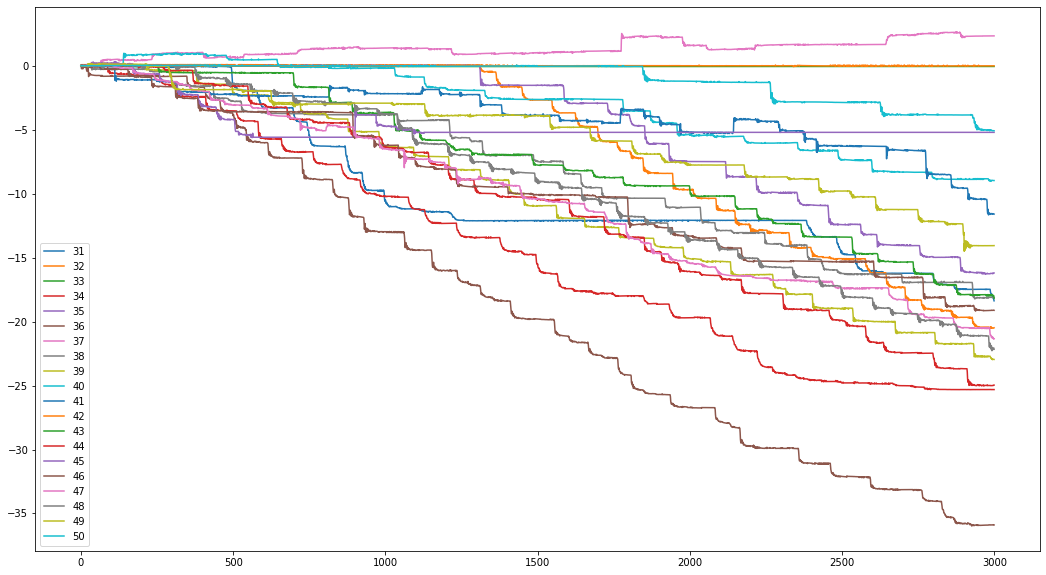

In [9]:
fig, ax = plt.subplots(1,1,figsize=(18,10))

# plt.plot(pm_Re23C_100[:,4], label='23')
# plt.plot(pm_Re24C_100[:,4], label='24')
# plt.plot(pm_Re25C_100[:,4], label='25')
# plt.plot(pm_Re26C_100[:,4], label='26')
# plt.plot(pm_Re27C_100[:,4], label='27')
# plt.plot(pm_Re28C_100[:,4], label='28')
# plt.plot(pm_Re29C_100[:,4], label='29')
# plt.plot(pm_Re30C_100[:,4], label='30')
plt.plot(pm_Re31C_100[:,4], label='31')
plt.plot(pm_Re32C_100[:,4], label='32')
plt.plot(pm_Re33C_100[:,4], label='33')
plt.plot(pm_Re34C_100[:,4], label='34')
plt.plot(pm_Re35C_100[:,4], label='35')
plt.plot(pm_Re36C_100[:,4], label='36')
plt.plot(pm_Re37C_100[:,4], label='37')
plt.plot(pm_Re38C_100[:,4], label='38')
plt.plot(pm_Re39C_100[:,4], label='39')
plt.plot(pm_Re40C_100[:,4], label='40')
plt.plot(pm_Re41C_100[:,4], label='41')
plt.plot(pm_Re42C_100[:,4], label='42')
plt.plot(pm_Re43C_100[:,4], label='43')
plt.plot(pm_Re44C_100[:,4], label='44')
plt.plot(pm_Re45C_100[:,4], label='45')
plt.plot(pm_Re46C_100[:,4], label='46')
plt.plot(pm_Re47C_100[:,4], label='47')
plt.plot(pm_Re48C_100[:,4], label='48')
plt.plot(pm_Re49C_100[:,4], label='49')
plt.plot(pm_Re50C_100[:,4], label='50')

plt.legend()

## Combining Fish into 3D Arrays

In [10]:
pm_comb_LeC1 = combine_fish_data(pm_Le1C_1,pm_Le2C_1,pm_Le3C_1,pm_Le4C_1,pm_Le5C_1,pm_Le6C_1,pm_Le8C_1,pm_Le10C_1,\
                                 pm_Le11C_1,pm_Le12C_1,pm_Le13C_1,pm_Le14C_1,pm_Le17C_1,pm_Le18C_1,pm_Le19C_1,\
                                 pm_Le20C_1,pm_Le21C_1,pm_Le22C_1,pm_Le23C_1,pm_Le24C_1,pm_Le25C_1,pm_Le26C_1,\
                                 pm_Le27C_1,pm_Le28C_1,pm_Le29C_1,pm_Le30C_1,pm_Le31C_1,pm_Le32C_1,pm_Le33C_1,\
                                 pm_Le34C_1,pm_Le35C_1,pm_Le36C_1,pm_Le37C_1,pm_Le38C_1,pm_Le39C_1,pm_Le40C_1,\
                                 pm_Le41C_1,pm_Le42C_1,pm_Le43C_1,pm_Le44C_1,pm_Le45C_1,pm_Le46C_1,pm_Le47C_1,\
                                 pm_Le48C_1,pm_Le49C_1,pm_Le50C_1)
pm_comb_LeC10 = combine_fish_data(pm_Le1C_10,pm_Le2C_10,pm_Le3C_10,pm_Le4C_10,pm_Le5C_10,pm_Le6C_10,pm_Le7C_10,\
                                  pm_Le8C_10,pm_Le10C_10,pm_Le12C_10,pm_Le13C_10,pm_Le14C_10,pm_Le16C_10,pm_Le19C_10,\
                                  pm_Le20C_10,pm_Le21C_10,pm_Le22C_10,pm_Le23C_10,pm_Le24C_10,pm_Le25C_10,\
                                  pm_Le26C_10,pm_Le27C_10,pm_Le28C_10,pm_Le29C_10,pm_Le30C_10,pm_Le31C_10,\
                                  pm_Le32C_10,pm_Le33C_10,pm_Le34C_10,pm_Le35C_10,pm_Le36C_10,pm_Le37C_10,\
                                  pm_Le38C_10,pm_Le39C_10,pm_Le40C_10,pm_Le41C_10,pm_Le42C_10,pm_Le43C_10,\
                                  pm_Le44C_10,pm_Le45C_10,pm_Le46C_10,pm_Le47C_10,pm_Le48C_10,pm_Le49C_10,\
                                  pm_Le50C_10)
pm_comb_LeC20 = combine_fish_data(pm_Le2C_20,pm_Le3C_20,pm_Le4C_20,pm_Le5C_20,pm_Le6C_20,pm_Le7C_20,pm_Le8C_20,\
                                  pm_Le10C_20,pm_Le13C_20,pm_Le14C_20,pm_Le15C_20,pm_Le16C_20,pm_Le18C_20,\
                                  pm_Le19C_20,pm_Le20C_20,pm_Le21C_20,pm_Le22C_20,pm_Le23C_20,pm_Le24C_20,\
                                  pm_Le25C_20,pm_Le26C_20,pm_Le27C_20,pm_Le28C_20,pm_Le29C_20,pm_Le30C_20,\
                                  pm_Le31C_20,pm_Le32C_20,pm_Le33C_20,pm_Le34C_20,pm_Le35C_20,pm_Le36C_20,\
                                  pm_Le37C_20,pm_Le38C_20,pm_Le39C_20,pm_Le40C_20,pm_Le41C_20,pm_Le42C_20,\
                                  pm_Le43C_20,pm_Le44C_20,pm_Le46C_20,pm_Le47C_20,pm_Le48C_20,pm_Le49C_20,pm_Le50C_20)
pm_comb_LeC30 = combine_fish_data(pm_Le1C_30,pm_Le2C_30,pm_Le3C_30,pm_Le4C_30,pm_Le5C_30,pm_Le6C_30,pm_Le7C_30,\
                                  pm_Le8C_30,pm_Le11C_30,pm_Le13C_30,pm_Le14C_30,pm_Le15C_30,pm_Le17C_30,\
                                  pm_Le19C_30,pm_Le20C_30,pm_Le21C_30,pm_Le22C_30,pm_Le23C_30,pm_Le24C_30,\
                                  pm_Le25C_30,pm_Le26C_30,pm_Le27C_30,pm_Le28C_30,pm_Le29C_30,pm_Le30C_30,\
                                  pm_Le31C_30,pm_Le32C_30,pm_Le33C_30,pm_Le34C_30,pm_Le35C_30,pm_Le36C_30,\
                                  pm_Le37C_30,pm_Le38C_30,pm_Le39C_30,pm_Le40C_30,pm_Le41C_30,pm_Le42C_30,\
                                  pm_Le43C_30,pm_Le44C_30,pm_Le45C_30,pm_Le46C_30,pm_Le47C_30,pm_Le48C_30,\
                                  pm_Le49C_30,pm_Le50C_30)
pm_comb_LeC50 = combine_fish_data(pm_Le1C_50,pm_Le2C_50,pm_Le3C_50,pm_Le4C_50,pm_Le5C_50,pm_Le6C_50,pm_Le7C_50,\
                                  pm_Le8C_50,pm_Le11C_50,pm_Le16C_50,pm_Le18C_50,pm_Le19C_50,pm_Le20C_50,pm_Le21C_50,\
                                  pm_Le22C_50,pm_Le23C_50,pm_Le24C_50,pm_Le25C_50,pm_Le27C_50,pm_Le28C_50,\
                                  pm_Le29C_50,pm_Le30C_50,pm_Le31C_50,pm_Le32C_50,pm_Le33C_50,pm_Le34C_50,\
                                  pm_Le35C_50,pm_Le36C_50,pm_Le37C_50,pm_Le38C_50,pm_Le39C_50,pm_Le40C_50,\
                                  pm_Le41C_50,pm_Le42C_50,pm_Le43C_50,pm_Le44C_50,pm_Le45C_50,pm_Le46C_50,\
                                  pm_Le47C_50,pm_Le48C_50,pm_Le49C_50,pm_Le50C_50)
pm_comb_LeC70 = combine_fish_data(pm_Le1C_70,pm_Le2C_70,pm_Le3C_70,pm_Le4C_70,pm_Le5C_70,pm_Le6C_70,pm_Le7C_70,\
                                  pm_Le8C_70,pm_Le9C_70,pm_Le10C_70,pm_Le11C_70,pm_Le13C_70,pm_Le14C_70,pm_Le15C_70,\
                                  pm_Le17C_70,pm_Le18C_70,pm_Le19C_70,pm_Le21C_70,pm_Le22C_70,pm_Le23C_70,\
                                  pm_Le24C_70,pm_Le25C_70,pm_Le26C_70,pm_Le27C_70,pm_Le28C_70,pm_Le29C_70,\
                                  pm_Le30C_70,pm_Le31C_70,pm_Le32C_70,pm_Le33C_70,pm_Le34C_70,pm_Le35C_70,\
                                  pm_Le36C_70,pm_Le37C_70,pm_Le38C_70,pm_Le39C_70,pm_Le40C_70,pm_Le41C_70,\
                                  pm_Le42C_70,pm_Le43C_70,pm_Le44C_70,pm_Le45C_70,pm_Le46C_70,pm_Le47C_70,\
                                  pm_Le48C_70,pm_Le49C_70,pm_Le50C_70)
pm_comb_LeC100 = combine_fish_data(pm_Le1C_100,pm_Le2C_100,pm_Le3C_100,pm_Le4C_100,pm_Le5C_100,pm_Le6C_100,\
                                   pm_Le7C_100,pm_Le8C_100,pm_Le10C_100,pm_Le11C_100,pm_Le12C_100,pm_Le13C_100,\
                                   pm_Le14C_100,pm_Le16C_100,pm_Le18C_100,pm_Le19C_100,pm_Le20C_100,pm_Le21C_100,\
                                   pm_Le22C_100,pm_Le23C_100,pm_Le24C_100,pm_Le25C_100,pm_Le26C_100,pm_Le27C_100,\
                                   pm_Le28C_100,pm_Le29C_100,pm_Le30C_100,pm_Le31C_100,pm_Le32C_100,pm_Le34C_100,\
                                   pm_Le35C_100,pm_Le36C_100,pm_Le37C_100,pm_Le38C_100,pm_Le39C_100,pm_Le40C_100,\
                                   pm_Le42C_100,pm_Le43C_100,pm_Le44C_100,pm_Le45C_100,pm_Le46C_100,pm_Le47C_100,\
                                   pm_Le48C_100,pm_Le49C_100,pm_Le50C_100)

pm_comb_ReC1 = combine_fish_data(pm_Re1C_1,pm_Re2C_1,pm_Re3C_1,pm_Re4C_1,pm_Re5C_1,pm_Re6C_1,pm_Re8C_1,pm_Re10C_1,\
                                 pm_Re13C_1,pm_Re14C_1,pm_Re16C_1,pm_Re17C_1,pm_Re18C_1,pm_Re19C_1,pm_Re20C_1,\
                                 pm_Re21C_1,pm_Re22C_1,pm_Re23C_1,pm_Re24C_1,pm_Re25C_1,pm_Re26C_1,pm_Re27C_1,\
                                 pm_Re28C_1,pm_Re29C_1,pm_Re30C_1,pm_Re31C_1,pm_Re32C_1,pm_Re33C_1,pm_Re34C_1,\
                                 pm_Re35C_1,pm_Re36C_1,pm_Re37C_1,pm_Re38C_1,pm_Re39C_1,pm_Re40C_1,pm_Re41C_1,\
                                 pm_Re42C_1,pm_Re43C_1,pm_Re45C_1,pm_Re46C_1,pm_Re47C_1,pm_Re48C_1,pm_Re49C_1,\
                                 pm_Re50C_1)
pm_comb_ReC10 = combine_fish_data(pm_Re1C_10,pm_Re2C_10,pm_Re3C_10,pm_Re4C_10,pm_Re5C_10,pm_Re6C_10,pm_Re7C_10,\
                                  pm_Re8C_10,pm_Re11C_10,pm_Re12C_10,pm_Re13C_10,pm_Re14C_10,pm_Re17C_10,\
                                  pm_Re18C_10,pm_Re19C_10,pm_Re20C_10,pm_Re21C_10,pm_Re22C_10,pm_Re23C_10,\
                                  pm_Re24C_10,pm_Re25C_10,pm_Re26C_10,pm_Re27C_10,pm_Re28C_10,pm_Re29C_10,\
                                  pm_Re30C_10,pm_Re31C_10,pm_Re32C_10,pm_Re33C_10,pm_Re34C_10,pm_Re36C_10,\
                                  pm_Re37C_10,pm_Re38C_10,pm_Re39C_10,pm_Re40C_10,pm_Re41C_10,pm_Re42C_10,\
                                  pm_Re43C_10,pm_Re44C_10,pm_Re45C_10,pm_Re46C_10,pm_Re47C_10,pm_Re48C_10,\
                                  pm_Re49C_10,pm_Re50C_10)
pm_comb_ReC20 = combine_fish_data(pm_Re1C_20,pm_Re2C_20,pm_Re3C_20,pm_Re4C_20,pm_Re5C_20,pm_Re6C_20,pm_Re8C_20,\
                                  pm_Re9C_20,pm_Re10C_20,pm_Re11C_20,pm_Re13C_20,pm_Re14C_20,pm_Re15C_20,pm_Re16C_20,\
                                  pm_Re18C_20,pm_Re19C_20,pm_Re20C_20,pm_Re21C_20,pm_Re22C_20,pm_Re23C_20,\
                                  pm_Re24C_20,pm_Re25C_20,pm_Re26C_20,pm_Re27C_20,pm_Re28C_20,pm_Re29C_20,\
                                  pm_Re30C_20,pm_Re31C_20,pm_Re32C_20,pm_Re33C_20,pm_Re34C_20,pm_Re35C_20,\
                                  pm_Re36C_20,pm_Re37C_20,pm_Re38C_20,pm_Re39C_20,pm_Re40C_20,pm_Re41C_20,\
                                  pm_Re42C_20,pm_Re43C_20,pm_Re44C_20,pm_Re45C_20,pm_Re46C_20,pm_Re47C_20,\
                                  pm_Re48C_20,pm_Re49C_20,pm_Re50C_20)
pm_comb_ReC30 = combine_fish_data(pm_Re1C_30,pm_Re2C_30,pm_Re3C_30,pm_Re4C_30,pm_Re5C_30,pm_Re6C_30,pm_Re8C_30,\
                                  pm_Re11C_30,pm_Re12C_30,pm_Re13C_30,pm_Re15C_30,pm_Re17C_30,pm_Re18C_30,\
                                  pm_Re19C_30,pm_Re20C_30,pm_Re21C_30,pm_Re22C_30,pm_Re23C_30,pm_Re24C_30,\
                                  pm_Re25C_30,pm_Re26C_30,pm_Re27C_30,pm_Re28C_30,pm_Re29C_30,pm_Re30C_30,\
                                  pm_Re31C_30,pm_Re32C_30,pm_Re33C_30,pm_Re34C_30,pm_Re35C_30,pm_Re36C_30,\
                                  pm_Re37C_30,pm_Re38C_30,pm_Re39C_30,pm_Re40C_30,pm_Re41C_30,pm_Re42C_30,\
                                  pm_Re43C_30,pm_Re44C_30,pm_Re45C_30,pm_Re46C_30,pm_Re47C_30,pm_Re48C_30,\
                                  pm_Re49C_30,pm_Re50C_30)
pm_comb_ReC50 = combine_fish_data(pm_Re1C_50,pm_Re2C_50,pm_Re3C_50,pm_Re4C_50,pm_Re5C_50,pm_Re6C_50,pm_Re8C_50,\
                                  pm_Re11C_50,pm_Re13C_50,pm_Re14C_50,pm_Re15C_50,pm_Re16C_50,pm_Re17C_50,\
                                  pm_Re18C_50,pm_Re19C_50,pm_Re20C_50,pm_Re21C_50,pm_Re22C_50,pm_Re23C_50,\
                                  pm_Re24C_50,pm_Re25C_50,pm_Re26C_50,pm_Re27C_50,pm_Re28C_50,pm_Re29C_50,\
                                  pm_Re30C_50,pm_Re31C_50,pm_Re32C_50,pm_Re33C_50,pm_Re35C_50,pm_Re36C_50,\
                                  pm_Re37C_50,pm_Re38C_50,pm_Re39C_50,pm_Re40C_50,pm_Re41C_50,pm_Re42C_50,\
                                  pm_Re43C_50,pm_Re44C_50,pm_Re45C_50,pm_Re46C_50,pm_Re47C_50,pm_Re48C_50,\
                                  pm_Re49C_50,pm_Re50C_50)
pm_comb_ReC70 = combine_fish_data(pm_Re1C_70,pm_Re2C_70,pm_Re3C_70,pm_Re4C_70,pm_Re5C_70,pm_Re6C_70,pm_Re8C_70,\
                                  pm_Re12C_70,pm_Re13C_70,pm_Re14C_70,pm_Re16C_70,pm_Re17C_70,pm_Re18C_70,\
                                  pm_Re19C_70,pm_Re20C_70,pm_Re21C_70,pm_Re22C_70,pm_Re23C_70,pm_Re24C_70,\
                                  pm_Re25C_70,pm_Re27C_70,pm_Re28C_70,pm_Re29C_70,pm_Re30C_70,pm_Re31C_70,\
                                  pm_Re33C_70,pm_Re34C_70,pm_Re35C_70,pm_Re36C_70,pm_Re37C_70,pm_Re38C_70,\
                                  pm_Re39C_70,pm_Re40C_70,pm_Re41C_70,pm_Re43C_70,pm_Re44C_70,pm_Re45C_70,\
                                  pm_Re46C_70,pm_Re47C_70,pm_Re48C_70,pm_Re49C_70,pm_Re50C_70)
pm_comb_ReC100 = combine_fish_data(pm_Re1C_100,pm_Re2C_100,pm_Re3C_100,pm_Re4C_100,pm_Re5C_100,pm_Re6C_100,\
                                   pm_Re8C_100,pm_Re10C_100,pm_Re11C_100,pm_Re13C_100,pm_Re14C_100,pm_Re17C_100,\
                                   pm_Re18C_100,pm_Re19C_100,pm_Re21C_100,pm_Re22C_100,pm_Re23C_100,pm_Re24C_100,\
                                   pm_Re25C_100,pm_Re26C_100,pm_Re27C_100,pm_Re28C_100,pm_Re29C_100,pm_Re30C_100,\
                                   pm_Re31C_100,pm_Re32C_100,pm_Re33C_100,pm_Re34C_100,pm_Re35C_100,pm_Re36C_100,\
                                   pm_Re37C_100,pm_Re38C_100,pm_Re39C_100,pm_Re40C_100,pm_Re41C_100,pm_Re42C_100,\
                                   pm_Re43C_100,pm_Re44C_100,pm_Re45C_100,pm_Re46C_100,pm_Re47C_100,pm_Re48C_100,\
                                   pm_Re49C_100,pm_Re50C_100)


In [11]:
pm_comb_LmeC1 = combine_fish_data(pm_Lme1C_1,pm_Lme2C_1,pm_Lme3C_1,pm_Lme4C_1,pm_Lme5C_1,pm_Lme6C_1,pm_Lme7C_1,\
                                  pm_Lme8C_1,pm_Lme9C_1,pm_Lme10C_1,pm_Lme12C_1,pm_Lme13C_1,pm_Lme14C_1,pm_Lme16C_1,\
                                  pm_Lme17C_1,pm_Lme19C_1,pm_Lme20C_1,pm_Lme21C_1,pm_Lme23C_1,pm_Lme24C_1,\
                                  pm_Lme25C_1,pm_Lme26C_1,pm_Lme27C_1,pm_Lme28C_1,pm_Lme29C_1,pm_Lme30C_1,\
                                  pm_Lme31C_1,pm_Lme32C_1,pm_Lme33C_1,pm_Lme34C_1,pm_Lme35C_1,pm_Lme36C_1,\
                                  pm_Lme37C_1,pm_Lme38C_1,pm_Lme39C_1,pm_Lme40C_1,pm_Lme41C_1,pm_Lme42C_1,\
                                  pm_Lme43C_1,pm_Lme44C_1,pm_Lme45C_1,pm_Lme46C_1,pm_Lme47C_1,pm_Lme48C_1,\
                                  pm_Lme49C_1,pm_Lme50C_1)
pm_comb_LmeC10 = combine_fish_data(pm_Lme1C_10,pm_Lme2C_10,pm_Lme3C_10,pm_Lme4C_10,pm_Lme5C_10,pm_Lme6C_10,\
                                   pm_Lme7C_10,pm_Lme8C_10,pm_Lme10C_10,pm_Lme11C_10,pm_Lme12C_10,pm_Lme14C_10,\
                                   pm_Lme15C_10,pm_Lme16C_10,pm_Lme17C_10,pm_Lme18C_10,pm_Lme21C_10,pm_Lme22C_10,\
                                   pm_Lme23C_10,pm_Lme25C_10,pm_Lme26C_10,pm_Lme27C_10,pm_Lme28C_10,pm_Lme29C_10,\
                                   pm_Lme30C_10,pm_Lme31C_10,pm_Lme32C_10,pm_Lme33C_10,pm_Lme34C_10,pm_Lme35C_10,\
                                   pm_Lme36C_10,pm_Lme37C_10,pm_Lme38C_10,pm_Lme39C_10,pm_Lme40C_10,pm_Lme41C_10,\
                                   pm_Lme42C_10,pm_Lme43C_10,pm_Lme44C_10,pm_Lme45C_10,pm_Lme46C_10,pm_Lme47C_10,\
                                   pm_Lme48C_10,pm_Lme49C_10,pm_Lme50C_10)
pm_comb_LmeC20 = combine_fish_data(pm_Lme1C_20,pm_Lme2C_20,pm_Lme3C_20,pm_Lme4C_20,pm_Lme5C_20,pm_Lme6C_20,\
                                   pm_Lme7C_20,pm_Lme8C_20,pm_Lme9C_20,pm_Lme10C_20,pm_Lme11C_20,pm_Lme12C_20,\
                                   pm_Lme14C_20,pm_Lme15C_20,pm_Lme17C_20,pm_Lme18C_20,pm_Lme20C_20,pm_Lme21C_20,\
                                   pm_Lme22C_20,pm_Lme23C_20,pm_Lme24C_20,pm_Lme25C_20,pm_Lme26C_20,pm_Lme27C_20,\
                                   pm_Lme28C_20,pm_Lme29C_20,pm_Lme31C_20,pm_Lme32C_20,pm_Lme33C_20,pm_Lme34C_20,\
                                   pm_Lme35C_20,pm_Lme36C_20,pm_Lme37C_20,pm_Lme38C_20,pm_Lme39C_20,pm_Lme40C_20,\
                                   pm_Lme41C_20,pm_Lme42C_20,pm_Lme43C_20,pm_Lme44C_20,pm_Lme45C_20,pm_Lme46C_20,\
                                   pm_Lme47C_20,pm_Lme48C_20,pm_Lme49C_20,pm_Lme50C_20)
pm_comb_LmeC30 = combine_fish_data(pm_Lme1C_30,pm_Lme2C_30,pm_Lme3C_30,pm_Lme4C_30,pm_Lme5C_30,pm_Lme6C_30,\
                                   pm_Lme7C_30,pm_Lme8C_30,pm_Lme9C_30,pm_Lme10C_30,pm_Lme11C_30,pm_Lme12C_30,\
                                   pm_Lme14C_30,pm_Lme15C_30,pm_Lme16C_30,pm_Lme17C_30,pm_Lme18C_30,pm_Lme20C_30,\
                                   pm_Lme23C_30,pm_Lme24C_30,pm_Lme25C_30,pm_Lme26C_30,pm_Lme27C_30,pm_Lme28C_30,\
                                   pm_Lme29C_30,pm_Lme30C_30,pm_Lme31C_30,pm_Lme32C_30,pm_Lme33C_30,pm_Lme34C_30,\
                                   pm_Lme35C_30,pm_Lme36C_30,pm_Lme37C_30,pm_Lme38C_30,pm_Lme39C_30,pm_Lme40C_30,\
                                   pm_Lme41C_30,pm_Lme42C_30,pm_Lme43C_30,pm_Lme44C_30,pm_Lme45C_30,pm_Lme46C_30,\
                                   pm_Lme47C_30,pm_Lme48C_30,pm_Lme49C_30,pm_Lme50C_30)
pm_comb_LmeC50 = combine_fish_data(pm_Lme1C_50,pm_Lme2C_50,pm_Lme3C_50,pm_Lme4C_50,pm_Lme5C_50,pm_Lme6C_50,\
                                   pm_Lme7C_50,pm_Lme8C_50,pm_Lme9C_50,pm_Lme10C_50,pm_Lme11C_50,pm_Lme13C_50,\
                                   pm_Lme14C_50,pm_Lme15C_50,pm_Lme16C_50,pm_Lme17C_50,pm_Lme18C_50,pm_Lme19C_50,\
                                   pm_Lme20C_50,pm_Lme21C_50,pm_Lme22C_50,pm_Lme23C_50,pm_Lme24C_50,pm_Lme25C_50,\
                                   pm_Lme26C_50,pm_Lme27C_50,pm_Lme28C_50,pm_Lme29C_50,pm_Lme30C_50,pm_Lme31C_50,\
                                   pm_Lme32C_50,pm_Lme33C_50,pm_Lme34C_50,pm_Lme35C_50,pm_Lme36C_50,pm_Lme37C_50,\
                                   pm_Lme38C_50,pm_Lme39C_50,pm_Lme40C_50,pm_Lme41C_50,pm_Lme42C_50,pm_Lme43C_50,\
                                   pm_Lme44C_50,pm_Lme45C_50,pm_Lme46C_50,pm_Lme47C_50,pm_Lme48C_50,pm_Lme49C_50,\
                                   pm_Lme50C_50)
pm_comb_LmeC70 = combine_fish_data(pm_Lme1C_70,pm_Lme2C_70,pm_Lme4C_70,pm_Lme5C_70,pm_Lme6C_70,pm_Lme7C_70,\
                                   pm_Lme8C_70,pm_Lme9C_70,pm_Lme10C_70,pm_Lme11C_70,pm_Lme12C_70,pm_Lme13C_70,\
                                   pm_Lme15C_70,pm_Lme16C_70,pm_Lme17C_70,pm_Lme18C_70,pm_Lme20C_70,pm_Lme21C_70,\
                                   pm_Lme22C_70,pm_Lme23C_70,pm_Lme24C_70,pm_Lme25C_70,pm_Lme26C_70,pm_Lme27C_70,\
                                   pm_Lme28C_70,pm_Lme29C_70,pm_Lme30C_70,pm_Lme31C_70,pm_Lme32C_70,pm_Lme33C_70,\
                                   pm_Lme34C_70,pm_Lme35C_70,pm_Lme36C_70,pm_Lme37C_70,pm_Lme38C_70,pm_Lme39C_70,\
                                   pm_Lme40C_70,pm_Lme41C_70,pm_Lme42C_70,pm_Lme43C_70,pm_Lme44C_70,pm_Lme45C_70,\
                                   pm_Lme46C_70,pm_Lme47C_70,pm_Lme48C_70,pm_Lme49C_70,pm_Lme50C_70)
pm_comb_LmeC100 = combine_fish_data(pm_Lme4C_100,pm_Lme6C_100,pm_Lme7C_100,pm_Lme8C_100,pm_Lme11C_100,pm_Lme12C_100,\
                                    pm_Lme15C_100,pm_Lme17C_100,pm_Lme18C_100,pm_Lme20C_100,pm_Lme21C_100,\
                                    pm_Lme22C_100,pm_Lme24C_100,pm_Lme25C_100,pm_Lme26C_100,pm_Lme27C_100,\
                                    pm_Lme28C_100,pm_Lme30C_100,pm_Lme31C_100,pm_Lme32C_100,pm_Lme33C_100,\
                                    pm_Lme34C_100,pm_Lme35C_100,pm_Lme36C_100,pm_Lme37C_100,pm_Lme38C_100,\
                                    pm_Lme39C_100,pm_Lme40C_100,pm_Lme41C_100,pm_Lme42C_100,pm_Lme43C_100,\
                                    pm_Lme44C_100,pm_Lme45C_100,pm_Lme46C_100,pm_Lme47C_100,pm_Lme48C_100,\
                                    pm_Lme49C_100,pm_Lme50C_100)

pm_comb_RmeC1 = combine_fish_data(pm_Rme1C_1,pm_Rme2C_1,pm_Rme3C_1,pm_Rme4C_1,pm_Rme5C_1,pm_Rme6C_1,pm_Rme7C_1,\
                                  pm_Rme8C_1,pm_Rme10C_1,pm_Rme12C_1,pm_Rme14C_1,pm_Rme16C_1,pm_Rme21C_1,pm_Rme22C_1,\
                                  pm_Rme23C_1,pm_Rme24C_1,pm_Rme25C_1,pm_Rme26C_1,pm_Rme27C_1,pm_Rme28C_1,\
                                  pm_Rme29C_1,pm_Rme30C_1,pm_Rme31C_1,pm_Rme32C_1,pm_Rme33C_1,pm_Rme34C_1,\
                                  pm_Rme35C_1,pm_Rme36C_1,pm_Rme37C_1,pm_Rme38C_1,pm_Rme39C_1,pm_Rme40C_1,\
                                  pm_Rme41C_1,pm_Rme42C_1,pm_Rme43C_1,pm_Rme44C_1,pm_Rme45C_1,pm_Rme46C_1,\
                                  pm_Rme47C_1,pm_Rme48C_1,pm_Rme49C_1,pm_Rme50C_1)
pm_comb_RmeC10 = combine_fish_data(pm_Rme1C_10,pm_Rme2C_10,pm_Rme3C_10,pm_Rme4C_10,pm_Rme5C_10,pm_Rme6C_10,\
                                   pm_Rme7C_10,pm_Rme10C_10,pm_Rme11C_10,pm_Rme12C_10,pm_Rme14C_10,pm_Rme18C_10,\
                                   pm_Rme21C_10,pm_Rme22C_10,pm_Rme23C_10,pm_Rme24C_10,pm_Rme25C_10,pm_Rme26C_10,\
                                   pm_Rme27C_10,pm_Rme28C_10,pm_Rme29C_10,pm_Rme30C_10,pm_Rme31C_10,pm_Rme32C_10,\
                                   pm_Rme33C_10,pm_Rme34C_10,pm_Rme35C_10,pm_Rme36C_10,pm_Rme37C_10,pm_Rme38C_10,\
                                   pm_Rme39C_10,pm_Rme41C_10,pm_Rme42C_10,pm_Rme43C_10,pm_Rme44C_10,pm_Rme45C_10,\
                                   pm_Rme46C_10,pm_Rme47C_10,pm_Rme48C_10,pm_Rme49C_10,pm_Rme50C_10)
pm_comb_RmeC20 = combine_fish_data(pm_Rme1C_20,pm_Rme2C_20,pm_Rme3C_20,pm_Rme4C_20,pm_Rme5C_20,pm_Rme6C_20,\
                                   pm_Rme7C_20,pm_Rme8C_20,pm_Rme9C_20,pm_Rme10C_20,pm_Rme11C_20,pm_Rme12C_20,\
                                   pm_Rme13C_20,pm_Rme14C_20,pm_Rme15C_20,pm_Rme16C_20,pm_Rme17C_20,pm_Rme19C_20,\
                                   pm_Rme21C_20,pm_Rme22C_20,pm_Rme23C_20,pm_Rme24C_20,pm_Rme25C_20,pm_Rme26C_20,\
                                   pm_Rme27C_20,pm_Rme28C_20,pm_Rme29C_20,pm_Rme31C_20,pm_Rme32C_20,pm_Rme33C_20,\
                                   pm_Rme34C_20,pm_Rme35C_20,pm_Rme37C_20,pm_Rme38C_20,pm_Rme39C_20,pm_Rme40C_20,\
                                   pm_Rme41C_20,pm_Rme42C_20,pm_Rme43C_20,pm_Rme44C_20,pm_Rme45C_20,pm_Rme46C_20,\
                                   pm_Rme47C_20,pm_Rme48C_20,pm_Rme49C_20,pm_Rme50C_20)
pm_comb_RmeC30 = combine_fish_data(pm_Rme1C_30,pm_Rme2C_30,pm_Rme3C_30,pm_Rme4C_30,pm_Rme5C_30,pm_Rme6C_30,\
                                   pm_Rme7C_30,pm_Rme8C_30,pm_Rme12C_30,pm_Rme13C_30,pm_Rme14C_30,pm_Rme17C_30,\
                                   pm_Rme18C_30,pm_Rme19C_30,pm_Rme21C_30,pm_Rme22C_30,pm_Rme23C_30,pm_Rme24C_30,\
                                   pm_Rme25C_30,pm_Rme26C_30,pm_Rme27C_30,pm_Rme28C_30,pm_Rme29C_30,pm_Rme30C_30,\
                                   pm_Rme31C_30,pm_Rme32C_30,pm_Rme33C_30,pm_Rme34C_30,pm_Rme35C_30,pm_Rme36C_30,\
                                   pm_Rme37C_30,pm_Rme38C_30,pm_Rme39C_30,pm_Rme40C_30,pm_Rme41C_30,pm_Rme42C_30,\
                                   pm_Rme43C_30,pm_Rme44C_30,pm_Rme45C_30,pm_Rme46C_30,pm_Rme47C_30,pm_Rme48C_30,\
                                   pm_Rme49C_30,pm_Rme50C_30)
pm_comb_RmeC50 = combine_fish_data(pm_Rme1C_50,pm_Rme2C_50,pm_Rme3C_50,pm_Rme4C_50,pm_Rme5C_50,pm_Rme6C_50,\
                                   pm_Rme7C_50,pm_Rme8C_50,pm_Rme9C_50,pm_Rme10C_50,pm_Rme11C_50,pm_Rme12C_50,\
                                   pm_Rme13C_50,pm_Rme14C_50,pm_Rme15C_50,pm_Rme16C_50,pm_Rme17C_50,pm_Rme18C_50,\
                                   pm_Rme22C_50,pm_Rme23C_50,pm_Rme24C_50,pm_Rme25C_50,pm_Rme26C_50,pm_Rme27C_50,\
                                   pm_Rme28C_50,pm_Rme29C_50,pm_Rme30C_50,pm_Rme31C_50,pm_Rme32C_50,pm_Rme33C_50,\
                                   pm_Rme34C_50,pm_Rme35C_50,pm_Rme36C_50,pm_Rme37C_50,pm_Rme38C_50,pm_Rme39C_50,\
                                   pm_Rme40C_50,pm_Rme41C_50,pm_Rme42C_50,pm_Rme43C_50,pm_Rme44C_50,pm_Rme45C_50,\
                                   pm_Rme46C_50,pm_Rme47C_50,pm_Rme48C_50,pm_Rme49C_50,pm_Rme50C_50)
pm_comb_RmeC70 = combine_fish_data(pm_Rme1C_70,pm_Rme2C_70,pm_Rme3C_70,pm_Rme4C_70,pm_Rme5C_70,pm_Rme6C_70,\
                                   pm_Rme7C_70,pm_Rme8C_70,pm_Rme9C_70,pm_Rme10C_70,pm_Rme12C_70,pm_Rme13C_70,\
                                   pm_Rme14C_70,pm_Rme15C_70,pm_Rme16C_70,pm_Rme17C_70,pm_Rme18C_70,pm_Rme19C_70,\
                                   pm_Rme20C_70,pm_Rme21C_70,pm_Rme22C_70,pm_Rme23C_70,pm_Rme24C_70,pm_Rme25C_70,\
                                   pm_Rme26C_70,pm_Rme27C_70,pm_Rme28C_70,pm_Rme30C_70,pm_Rme31C_70,pm_Rme32C_70,\
                                   pm_Rme33C_70,pm_Rme34C_70,pm_Rme35C_70,pm_Rme36C_70,pm_Rme37C_70,pm_Rme38C_70,\
                                   pm_Rme39C_70,pm_Rme40C_70,pm_Rme41C_70,pm_Rme42C_70,pm_Rme43C_70,pm_Rme44C_70,\
                                   pm_Rme45C_70,pm_Rme46C_70,pm_Rme47C_70,pm_Rme48C_70,pm_Rme49C_70,pm_Rme50C_70)
pm_comb_RmeC100 = combine_fish_data(pm_Rme2C_100,pm_Rme3C_100,pm_Rme4C_100,pm_Rme5C_100,pm_Rme6C_100,pm_Rme7C_100,\
                                    pm_Rme8C_100,pm_Rme9C_100,pm_Rme10C_100,pm_Rme12C_100,pm_Rme13C_100,\
                                    pm_Rme14C_100,pm_Rme15C_100,pm_Rme16C_100,pm_Rme17C_100,pm_Rme18C_100,\
                                    pm_Rme21C_100,pm_Rme22C_100,pm_Rme23C_100,pm_Rme25C_100,pm_Rme26C_100,\
                                    pm_Rme27C_100,pm_Rme28C_100,pm_Rme29C_100,pm_Rme30C_100,pm_Rme31C_100,\
                                    pm_Rme32C_100,pm_Rme33C_100,pm_Rme34C_100,pm_Rme35C_100,pm_Rme36C_100,\
                                    pm_Rme37C_100,pm_Rme38C_100,pm_Rme39C_100,pm_Rme40C_100,pm_Rme41C_100,\
                                    pm_Rme42C_100,pm_Rme43C_100,pm_Rme44C_100,pm_Rme45C_100,pm_Rme46C_100,\
                                    pm_Rme47C_100,pm_Rme48C_100,pm_Rme49C_100,pm_Rme50C_100)

In [12]:
am_comb_LmeC1 = combine_fish_data(am_Lme3C_1,am_Lme4C_1,am_Lme6C_1,am_Lme7C_1,am_Lme8C_1,am_Lme9C_1,am_Lme12C_1,\
                                  am_Lme14C_1,am_Lme15C_1,am_Lme16C_1,am_Lme18C_1,am_Lme19C_1,am_Lme20C_1,\
                                  am_Lme21C_1,am_Lme22C_1,am_Lme23C_1,am_Lme24C_1,am_Lme25C_1,am_Lme26C_1,\
                                  am_Lme27C_1,am_Lme28C_1,am_Lme29C_1,am_Lme30C_1,am_Lme31C_1,am_Lme32C_1,\
                                  am_Lme33C_1,am_Lme34C_1,am_Lme35C_1)
am_comb_LmeC10 = combine_fish_data(am_Lme1C_10,am_Lme2C_10,am_Lme3C_10,am_Lme4C_10,am_Lme6C_10,am_Lme7C_10,\
                                   am_Lme8C_10,am_Lme9C_10,am_Lme10C_10,am_Lme12C_10,am_Lme13C_10,am_Lme14C_10,\
                                   am_Lme17C_10,am_Lme18C_10,am_Lme19C_10,am_Lme21C_10,am_Lme22C_10,am_Lme23C_10,\
                                   am_Lme24C_10,am_Lme25C_10,am_Lme26C_10,am_Lme27C_10,am_Lme28C_10,am_Lme29C_10,\
                                   am_Lme30C_10,am_Lme31C_10,am_Lme32C_10,am_Lme34C_10,am_Lme35C_10)
am_comb_LmeC20 = combine_fish_data(am_Lme1C_20,am_Lme2C_20,am_Lme6C_20,am_Lme7C_20,am_Lme9C_20,am_Lme10C_20,\
                                   am_Lme13C_20,am_Lme14C_20,am_Lme15C_20,am_Lme16C_20,am_Lme19C_20,am_Lme20C_20,\
                                   am_Lme21C_20,am_Lme22C_20,am_Lme23C_20,am_Lme24C_20,am_Lme25C_20,am_Lme26C_20,\
                                   am_Lme27C_20,am_Lme28C_20,am_Lme29C_20,am_Lme30C_20,am_Lme31C_20,am_Lme32C_20,\
                                   am_Lme33C_20,am_Lme34C_20,am_Lme35C_20)
am_comb_LmeC30 = combine_fish_data(am_Lme1C_30,am_Lme2C_30,am_Lme3C_30,am_Lme4C_30,am_Lme5C_30,am_Lme7C_30,\
                                   am_Lme8C_30,am_Lme9C_30,am_Lme10C_30,am_Lme11C_30,am_Lme12C_30,am_Lme13C_30,\
                                   am_Lme14C_30,am_Lme15C_30,am_Lme16C_30,am_Lme17C_30,am_Lme18C_30,am_Lme19C_30,\
                                   am_Lme20C_30,am_Lme21C_30,am_Lme22C_30,am_Lme23C_30,am_Lme24C_30,am_Lme25C_30,\
                                   am_Lme26C_30,am_Lme27C_30,am_Lme28C_30,am_Lme29C_30,am_Lme30C_30,am_Lme31C_30,\
                                   am_Lme32C_30,am_Lme33C_30,am_Lme34C_30,am_Lme35C_30)
am_comb_LmeC50 = combine_fish_data(am_Lme1C_50,am_Lme3C_50,am_Lme4C_50,am_Lme6C_50,am_Lme7C_50,am_Lme9C_50,\
                                   am_Lme10C_50,am_Lme13C_50,am_Lme15C_50,am_Lme17C_50,am_Lme18C_50,am_Lme20C_50,\
                                   am_Lme21C_50,am_Lme22C_50,am_Lme23C_50,am_Lme25C_50,am_Lme26C_50,am_Lme27C_50,\
                                   am_Lme28C_50,am_Lme29C_50,am_Lme30C_50,am_Lme31C_50,am_Lme32C_50,am_Lme33C_50,\
                                   am_Lme34C_50,am_Lme35C_50)
am_comb_LmeC70 = combine_fish_data(am_Lme1C_70,am_Lme2C_70,am_Lme3C_70,am_Lme4C_70,am_Lme7C_70,am_Lme10C_70,\
                                   am_Lme13C_70,am_Lme14C_70,am_Lme15C_70,am_Lme16C_70,am_Lme17C_70,am_Lme18C_70,\
                                   am_Lme19C_70,am_Lme21C_70,am_Lme22C_70,am_Lme23C_70,am_Lme24C_70,am_Lme25C_70,\
                                   am_Lme26C_70,am_Lme27C_70,am_Lme28C_70,am_Lme29C_70,am_Lme30C_70,am_Lme31C_70,\
                                   am_Lme32C_70,am_Lme33C_70,am_Lme34C_70,am_Lme35C_70)
am_comb_LmeC100 = combine_fish_data(am_Lme1C_100,am_Lme3C_100,am_Lme4C_100,am_Lme5C_100,am_Lme6C_100,am_Lme9C_100,\
                                    am_Lme10C_100,am_Lme11C_100,am_Lme13C_100,am_Lme16C_100,am_Lme17C_100,\
                                    am_Lme18C_100,am_Lme22C_100,am_Lme23C_100,am_Lme24C_100,am_Lme25C_100,\
                                    am_Lme26C_100,am_Lme27C_100,am_Lme28C_100,am_Lme29C_100,am_Lme30C_100,\
                                    am_Lme31C_100,am_Lme32C_100,am_Lme33C_100,am_Lme34C_100,am_Lme35C_100)

am_comb_RmeC1 = combine_fish_data(am_Rme1C_1,am_Rme2C_1,am_Rme3C_1,am_Rme4C_1,am_Rme5C_1,am_Rme7C_1,am_Rme8C_1,\
                                  am_Rme9C_1,am_Rme11C_1,am_Rme13C_1,am_Rme14C_1,am_Rme16C_1,am_Rme18C_1,am_Rme19C_1,\
                                  am_Rme20C_1,am_Rme21C_1,am_Rme22C_1,am_Rme23C_1,am_Rme24C_1,am_Rme25C_1,\
                                  am_Rme26C_1,am_Rme27C_1,am_Rme28C_1,am_Rme29C_1,am_Rme30C_1,am_Rme31C_1,\
                                  am_Rme32C_1,am_Rme33C_1,am_Rme34C_1,am_Rme35C_1)
am_comb_RmeC10 = combine_fish_data(am_Rme1C_10,am_Rme2C_10,am_Rme3C_10,am_Rme4C_10,am_Rme5C_10,am_Rme6C_10,\
                                   am_Rme7C_10,am_Rme8C_10,am_Rme9C_10,am_Rme11C_10,am_Rme13C_10,am_Rme14C_10,\
                                   am_Rme16C_10,am_Rme17C_10,am_Rme18C_10,am_Rme19C_10,am_Rme21C_10,am_Rme22C_10,\
                                   am_Rme23C_10,am_Rme24C_10,am_Rme25C_10,am_Rme26C_10,am_Rme27C_10,am_Rme28C_10,\
                                   am_Rme29C_10,am_Rme30C_10,am_Rme31C_10,am_Rme32C_10,am_Rme33C_10,am_Rme34C_10,\
                                   am_Rme35C_10)
am_comb_RmeC20 = combine_fish_data(am_Rme1C_20,am_Rme2C_20,am_Rme3C_20,am_Rme4C_20,am_Rme5C_20,am_Rme6C_20,\
                                   am_Rme7C_20,am_Rme9C_20,am_Rme13C_20,am_Rme14C_20,am_Rme15C_20,am_Rme16C_20,\
                                   am_Rme17C_20,am_Rme18C_20,am_Rme19C_20,am_Rme20C_20,am_Rme21C_20,am_Rme22C_20,\
                                   am_Rme23C_20,am_Rme24C_20,am_Rme25C_20,am_Rme26C_20,am_Rme27C_20,am_Rme28C_20,\
                                   am_Rme29C_20,am_Rme30C_20,am_Rme31C_20,am_Rme32C_20,am_Rme34C_20,am_Rme35C_20)
am_comb_RmeC30 = combine_fish_data(am_Rme1C_30,am_Rme2C_30,am_Rme3C_30,am_Rme4C_30,am_Rme5C_30,am_Rme7C_30,\
                                   am_Rme9C_30,am_Rme10C_30,am_Rme11C_30,am_Rme13C_30,am_Rme14C_30,am_Rme15C_30,\
                                   am_Rme16C_30,am_Rme17C_30,am_Rme18C_30,am_Rme19C_30,am_Rme21C_30,am_Rme22C_30,\
                                   am_Rme23C_30,am_Rme24C_30,am_Rme25C_30,am_Rme26C_30,am_Rme27C_30,am_Rme28C_30,\
                                   am_Rme29C_30,am_Rme30C_30,am_Rme31C_30,am_Rme32C_30,am_Rme33C_30,am_Rme34C_30,\
                                   am_Rme35C_30)
am_comb_RmeC50 = combine_fish_data(am_Rme1C_50,am_Rme3C_50,am_Rme4C_50,am_Rme5C_50,am_Rme6C_50,am_Rme7C_50,\
                                   am_Rme9C_50,am_Rme11C_50,am_Rme13C_50,am_Rme14C_50,\
                                   am_Rme15C_50,am_Rme16C_50,am_Rme17C_50,am_Rme18C_50,am_Rme19C_50,am_Rme20C_50,\
                                   am_Rme21C_50,am_Rme23C_50,am_Rme24C_50,am_Rme25C_50,am_Rme26C_50,am_Rme27C_50,\
                                   am_Rme28C_50,am_Rme29C_50,am_Rme30C_50,am_Rme31C_50,am_Rme32C_50,am_Rme33C_50,\
                                   am_Rme34C_50,am_Rme35C_50)
am_comb_RmeC70 = combine_fish_data(am_Rme1C_70,am_Rme2C_70,am_Rme3C_70,am_Rme4C_70,am_Rme5C_70,am_Rme6C_70,\
                                   am_Rme7C_70,am_Rme8C_70,am_Rme9C_70,am_Rme10C_70,am_Rme13C_70,\
                                   am_Rme14C_70,am_Rme15C_70,am_Rme16C_70,am_Rme17C_70,am_Rme19C_70,am_Rme20C_70,\
                                   am_Rme22C_70,am_Rme23C_70,am_Rme24C_70,am_Rme25C_70,am_Rme26C_70,am_Rme27C_70,\
                                   am_Rme28C_70,am_Rme29C_70,am_Rme30C_70,am_Rme31C_70,am_Rme32C_70,am_Rme33C_70,\
                                   am_Rme34C_70,am_Rme35C_70)
am_comb_RmeC100 = combine_fish_data(am_Rme1C_100,am_Rme3C_100,am_Rme6C_100,am_Rme7C_100,am_Rme10C_100,\
                                    am_Rme12C_100,am_Rme14C_100,am_Rme15C_100,am_Rme16C_100,am_Rme17C_100,\
                                    am_Rme18C_100,am_Rme19C_100,am_Rme22C_100,am_Rme23C_100,am_Rme25C_100,\
                                    am_Rme26C_100,am_Rme27C_100,am_Rme28C_100,am_Rme29C_100,am_Rme30C_100,\
                                    am_Rme31C_100,am_Rme32C_100,am_Rme33C_100,am_Rme34C_100,am_Rme35C_100) 

In [13]:
am_comb_LeC1 = combine_fish_data(am_Le2C_1,am_Le3C_1,am_Le4C_1,am_Le5C_1,am_Le6C_1,am_Le7C_1,am_Le9C_1,am_Le10C_1,\
                                 am_Le11C_1,am_Le12C_1,am_Le13C_1,am_Le14C_1,am_Le15C_1,am_Le17C_1,am_Le18C_1,\
                                 am_Le19C_1,am_Le20C_1,am_Le21C_1,am_Le22C_1,am_Le23C_1,am_Le24C_1,am_Le25C_1,\
                                 am_Le26C_1,am_Le27C_1,am_Le28C_1,am_Le29C_1,am_Le30C_1,am_Le31C_1,am_Le32C_1,\
                                 am_Le33C_1,am_Le34C_1,am_Le35C_1)
am_comb_LeC10 = combine_fish_data(am_Le1C_10,am_Le2C_10,am_Le3C_10,am_Le4C_10,am_Le5C_10,am_Le6C_10,am_Le7C_10,\
                                  am_Le8C_10,am_Le11C_10,am_Le12C_10,am_Le13C_10,am_Le14C_10,am_Le15C_10,am_Le17C_10,\
                                  am_Le19C_10,am_Le20C_10,am_Le21C_10,am_Le22C_10,am_Le23C_10,am_Le24C_10,\
                                  am_Le25C_10,am_Le26C_10,am_Le27C_10,am_Le28C_10,am_Le29C_10,am_Le30C_10,\
                                  am_Le31C_10,am_Le33C_10,am_Le34C_10)
am_comb_LeC20 = combine_fish_data(am_Le1C_20,am_Le3C_20,am_Le4C_20,am_Le6C_20,am_Le9C_20,am_Le10C_20,am_Le11C_20,\
                                  am_Le12C_20,am_Le13C_20,am_Le14C_20,am_Le15C_20,am_Le16C_20,am_Le17C_20,\
                                  am_Le18C_20,am_Le20C_20,am_Le21C_20,am_Le22C_20,am_Le23C_20,am_Le24C_20,\
                                  am_Le25C_20,am_Le26C_20,am_Le27C_20,am_Le28C_20,am_Le29C_20,am_Le30C_20,\
                                  am_Le31C_20,am_Le32C_20,am_Le33C_20,am_Le34C_20,am_Le35C_20)
am_comb_LeC30 = combine_fish_data(am_Le1C_30,am_Le2C_30,am_Le3C_30,am_Le4C_30,am_Le5C_30,am_Le6C_30,am_Le7C_30,\
                                  am_Le8C_30,am_Le9C_30,am_Le11C_30,am_Le12C_30,am_Le14C_30,am_Le15C_30,am_Le16C_30,\
                                  am_Le17C_30,am_Le18C_30,am_Le20C_30,am_Le21C_30,am_Le22C_30,am_Le23C_30,\
                                  am_Le24C_30,am_Le25C_30,am_Le26C_30,am_Le27C_30,am_Le28C_30,am_Le29C_30,\
                                  am_Le30C_30,am_Le31C_30,am_Le32C_30,am_Le33C_30,am_Le34C_30,am_Le35C_30)
am_comb_LeC50 = combine_fish_data(am_Le1C_50,am_Le2C_50,am_Le3C_50,am_Le4C_50,am_Le6C_50,am_Le7C_50,am_Le8C_50,\
                                  am_Le9C_50,am_Le13C_50,am_Le14C_50,am_Le15C_50,am_Le16C_50,am_Le17C_50,\
                                  am_Le18C_50,am_Le19C_50,am_Le20C_50,am_Le21C_50,am_Le22C_50,am_Le23C_50,\
                                  am_Le24C_50,am_Le25C_50,am_Le26C_50,am_Le27C_50,am_Le28C_50,am_Le29C_50,\
                                  am_Le30C_50,am_Le31C_50,am_Le32C_50,am_Le33C_50,am_Le34C_50,am_Le35C_50)
am_comb_LeC70 = combine_fish_data(am_Le1C_70,am_Le2C_70,am_Le3C_70,am_Le4C_70,am_Le6C_70,am_Le7C_70,am_Le9C_70,\
                                  am_Le10C_70,am_Le11C_70,am_Le12C_70,am_Le13C_70,am_Le14C_70,am_Le15C_70,\
                                  am_Le16C_70,am_Le17C_70,am_Le19C_70,am_Le20C_70,am_Le21C_70,am_Le22C_70,\
                                  am_Le23C_70,am_Le24C_70,am_Le25C_70,am_Le26C_70,am_Le27C_70,am_Le28C_70,\
                                  am_Le30C_70,am_Le31C_70,am_Le32C_70,am_Le33C_70,am_Le34C_70,am_Le35C_70)
am_comb_LeC100 = combine_fish_data(am_Le1C_100,am_Le3C_100,am_Le8C_100,am_Le9C_100,am_Le10C_100,am_Le11C_100,\
                                   am_Le14C_100,am_Le15C_100,am_Le16C_100,am_Le21C_100,am_Le23C_100,am_Le24C_100,\
                                   am_Le25C_100,am_Le26C_100,am_Le27C_100,am_Le28C_100,am_Le29C_100,am_Le30C_100,\
                                   am_Le31C_100,am_Le32C_100,am_Le33C_100,am_Le34C_100,am_Le35C_100)

am_comb_ReC1 = combine_fish_data(am_Re2C_1,am_Re4C_1,am_Re5C_1,am_Re6C_1,am_Re7C_1,am_Re8C_1,am_Re9C_1,am_Re10C_1,\
                                 am_Re12C_1,am_Re13C_1,am_Re15C_1,am_Re16C_1,am_Re17C_1,am_Re18C_1,am_Re19C_1,\
                                 am_Re20C_1,am_Re21C_1,am_Re22C_1,am_Re23C_1,am_Re24C_1,am_Re25C_1,am_Re26C_1,\
                                 am_Re27C_1,am_Re28C_1,am_Re29C_1,am_Re30C_1,am_Re31C_1,am_Re32C_1,am_Re33C_1,\
                                 am_Re34C_1,am_Re35C_1)
am_comb_ReC10 = combine_fish_data(am_Re1C_10,am_Re2C_10,am_Re3C_10,am_Re4C_10,am_Re5C_10,am_Re6C_10,am_Re7C_10,\
                                  am_Re8C_10,am_Re9C_10,am_Re12C_10,am_Re13C_10,am_Re14C_10,am_Re15C_10,am_Re16C_10,\
                                  am_Re17C_10,am_Re18C_10,am_Re19C_10,am_Re20C_10,am_Re21C_10,am_Re22C_10,\
                                  am_Re23C_10,am_Re24C_10,am_Re25C_10,am_Re26C_10,am_Re27C_10,am_Re28C_10,\
                                  am_Re29C_10,am_Re30C_10,am_Re31C_10,am_Re32C_10,am_Re33C_10,am_Re34C_10,am_Re35C_10)
am_comb_ReC20 = combine_fish_data(am_Re1C_20,am_Re2C_20,am_Re3C_20,am_Re4C_20,am_Re5C_20,am_Re6C_20,am_Re7C_20,\
                                  am_Re8C_20,am_Re9C_20,am_Re11C_20,am_Re12C_20,am_Re13C_20,am_Re14C_20,am_Re15C_20,\
                                  am_Re16C_20,am_Re17C_20,am_Re18C_20,am_Re20C_20,am_Re21C_20,am_Re22C_20,\
                                  am_Re23C_20,am_Re24C_20,am_Re25C_20,am_Re26C_20,am_Re27C_20,am_Re28C_20,\
                                  am_Re29C_20,am_Re30C_20,am_Re31C_20,am_Re32C_20,am_Re33C_20,am_Re34C_20,am_Re35C_20)
am_comb_ReC30 = combine_fish_data(am_Re1C_30,am_Re2C_30,am_Re3C_30,am_Re4C_30,am_Re5C_30,am_Re6C_30,am_Re8C_30,\
                                  am_Re9C_30,am_Re11C_30,am_Re12C_30,am_Re14C_30,am_Re15C_30,am_Re16C_30,\
                                  am_Re17C_30,am_Re18C_30,am_Re19C_30,am_Re20C_30,am_Re21C_30,am_Re22C_30,\
                                  am_Re23C_30,am_Re24C_30,am_Re25C_30,am_Re26C_30,am_Re27C_30,am_Re28C_30,\
                                  am_Re29C_30,am_Re30C_30,am_Re31C_30,am_Re32C_30,am_Re33C_30,am_Re34C_30,am_Re35C_30)
am_comb_ReC50 = combine_fish_data(am_Re1C_50,am_Re2C_50,am_Re3C_50,am_Re4C_50,am_Re5C_50,am_Re6C_50,am_Re7C_50,\
                                  am_Re9C_50,am_Re11C_50,am_Re13C_50,am_Re14C_50,am_Re15C_50,am_Re16C_50,am_Re17C_50,\
                                  am_Re18C_50,am_Re19C_50,am_Re20C_50,am_Re21C_50,am_Re22C_50,am_Re23C_50,\
                                  am_Re24C_50,am_Re25C_50,am_Re26C_50,am_Re27C_50,am_Re28C_50,am_Re29C_50,\
                                  am_Re30C_50,am_Re31C_50,am_Re32C_50,am_Re33C_50,am_Re34C_50,am_Re35C_50)
am_comb_ReC70 = combine_fish_data(am_Re1C_70,am_Re2C_70,am_Re3C_70,am_Re4C_70,am_Re5C_70,am_Re6C_70,am_Re7C_70,\
                                  am_Re8C_70,am_Re9C_70,am_Re10C_70,am_Re11C_70,am_Re12C_70,am_Re13C_70,am_Re14C_70,\
                                  am_Re15C_70,am_Re16C_70,am_Re17C_70,am_Re18C_70,am_Re19C_70,am_Re20C_70,\
                                  am_Re21C_70,am_Re22C_70,am_Re23C_70,am_Re24C_70,am_Re25C_70,am_Re26C_70,\
                                  am_Re27C_70,am_Re28C_70,am_Re29C_70,am_Re30C_70,am_Re31C_70,am_Re32C_70,\
                                  am_Re33C_70,am_Re34C_70,am_Re35C_70)
am_comb_ReC100 = combine_fish_data(am_Re1C_100,am_Re2C_100,am_Re3C_100,am_Re7C_100,am_Re8C_100,am_Re9C_100,\
                                   am_Re11C_100,am_Re12C_100,am_Re14C_100,am_Re15C_100,am_Re16C_100,am_Re17C_100,\
                                   am_Re19C_100,am_Re23C_100,am_Re24C_100,am_Re25C_100,am_Re28C_100,am_Re29C_100,\
                                   am_Re30C_100,am_Re31C_100,am_Re32C_100,am_Re33C_100,am_Re35C_100)

## Plotting Average Trajectories

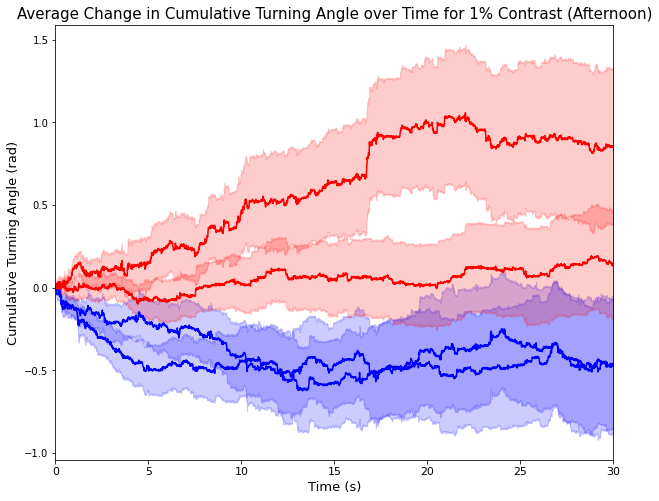

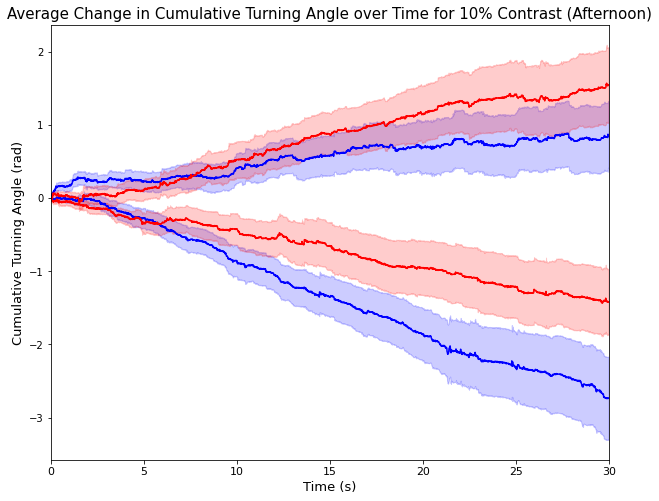

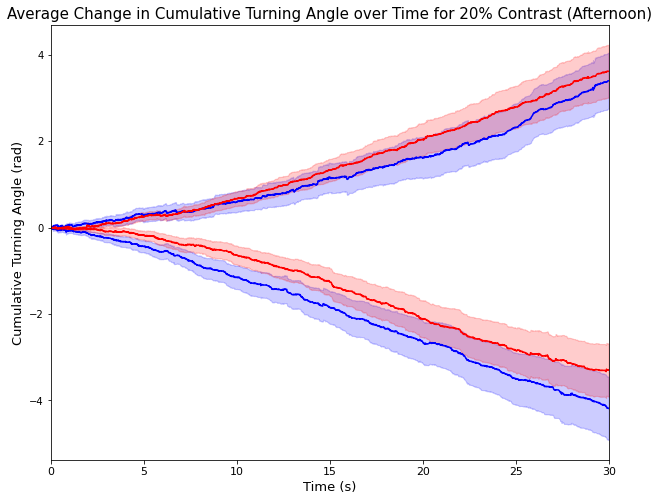

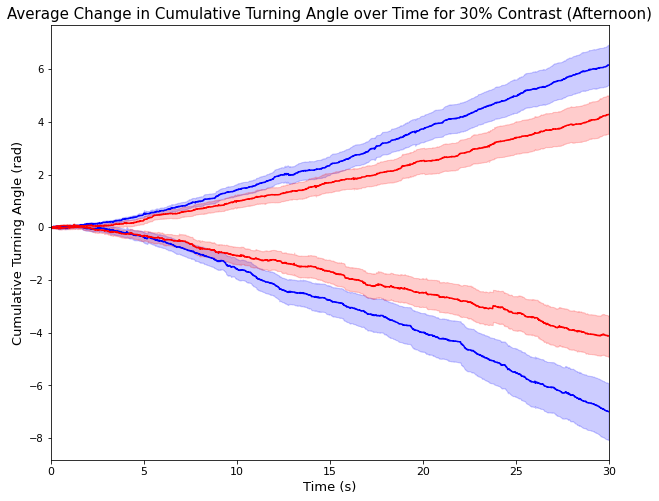

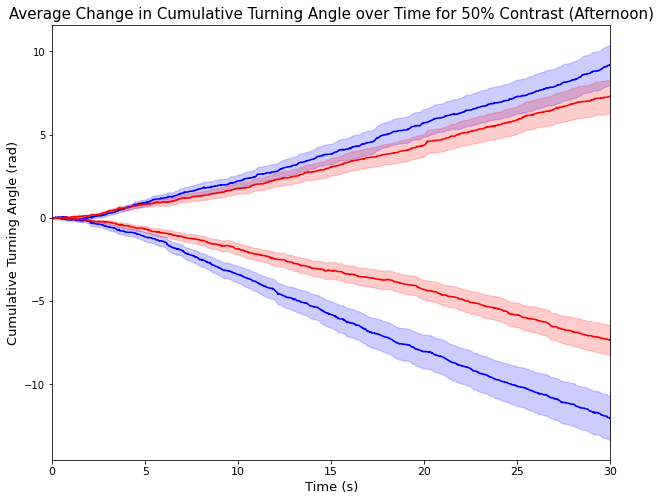

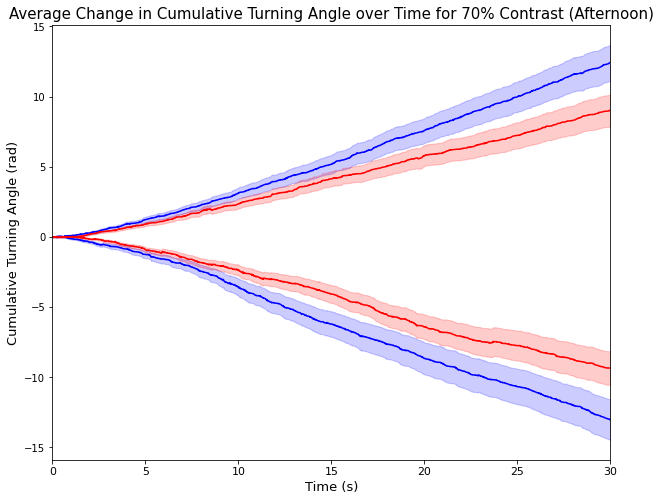

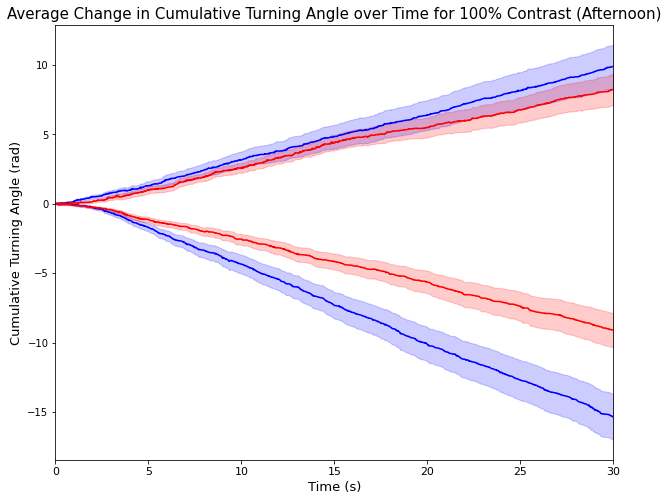

In [14]:
for c in ['1','10','20','30','50','70','100']:
    exec(f'avg_pm_LeC{c}_trajectory = np.mean(pm_comb_LeC{c}[:,:,4],axis=0)')
    exec(f'avg_pm_ReC{c}_trajectory = np.mean(pm_comb_ReC{c}[:,:,4],axis=0)')

    exec(f'avg_pm_LeC{c}_SEM = stats.sem(pm_comb_LeC{c}[:,:,4],axis=0)')
    exec(f'avg_pm_ReC{c}_SEM = stats.sem(pm_comb_ReC{c}[:,:,4],axis=0)')
    
    exec(f'avg_pm_LmeC{c}_trajectory = np.mean(pm_comb_LmeC{c}[:,:,4],axis=0)')
    exec(f'avg_pm_RmeC{c}_trajectory = np.mean(pm_comb_RmeC{c}[:,:,4],axis=0)')

    exec(f'avg_pm_LmeC{c}_SEM = stats.sem(pm_comb_LmeC{c}[:,:,4],axis=0)')
    exec(f'avg_pm_RmeC{c}_SEM = stats.sem(pm_comb_RmeC{c}[:,:,4],axis=0)')

    exec(f'fig, ax = plt.subplots(1,1,figsize=(10,8))')
    exec(f'plt.title("Average Change in Cumulative Turning Angle over Time for {c}% Contrast (Afternoon)",fontsize=15)')
    exec(f'ax.set_xlabel("Time (s)",fontsize=13)')
    exec(f'ax.set_ylabel("Cumulative Turning Angle (rad)",fontsize=13)')
    exec(f'ax.set_xlim(0,3000)')
    exec(f'x_ticks = [0, 500, 1000, 1500, 2000, 2500, 3000]')
    exec(f'x_labels = [0, 5, 10, 15, 20, 25, 30] ')
    exec(f'plt.xticks(x_ticks,x_labels,fontsize=11)')
    exec(f'ax.plot(avg_pm_LeC{c}_trajectory,c="b")')
    exec(f'ax.plot(avg_pm_ReC{c}_trajectory,c="b")')
    exec(f'ax.plot(avg_pm_LmeC{c}_trajectory,c="r")')
    exec(f'ax.plot(avg_pm_RmeC{c}_trajectory,c="r")')
    exec(f'ax.fill_between(range(0,3000), avg_pm_LeC{c}_trajectory-avg_pm_LeC{c}_SEM, avg_pm_LeC{c}_trajectory+\
            avg_pm_LeC{c}_SEM,color="b",alpha=0.2)')
    exec(f'ax.fill_between(range(0,3000), avg_pm_ReC{c}_trajectory-avg_pm_ReC{c}_SEM, avg_pm_ReC{c}_trajectory+\
            avg_pm_ReC{c}_SEM,color="b",alpha=0.2)')
    exec(f'ax.fill_between(range(0,3000), avg_pm_LmeC{c}_trajectory-avg_pm_LmeC{c}_SEM, avg_pm_LmeC{c}_trajectory+\
            avg_pm_LmeC{c}_SEM,color="r",alpha=0.2)')
    exec(f'ax.fill_between(range(0,3000), avg_pm_RmeC{c}_trajectory-avg_pm_RmeC{c}_SEM, avg_pm_RmeC{c}_trajectory+\
            avg_pm_RmeC{c}_SEM,color="r",alpha=0.2)')
    exec(f'plt.show()')

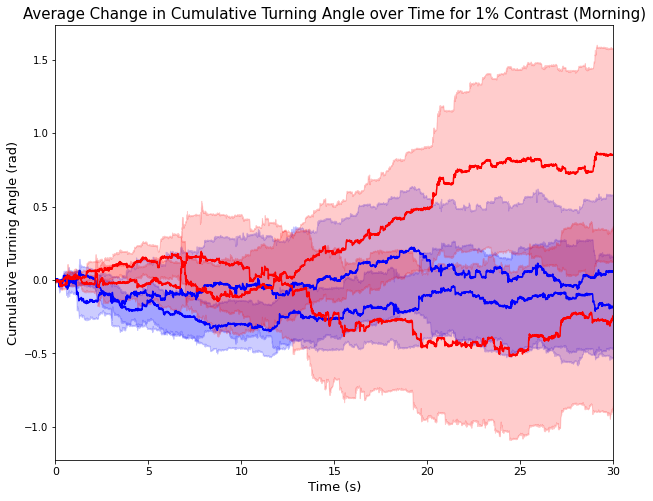

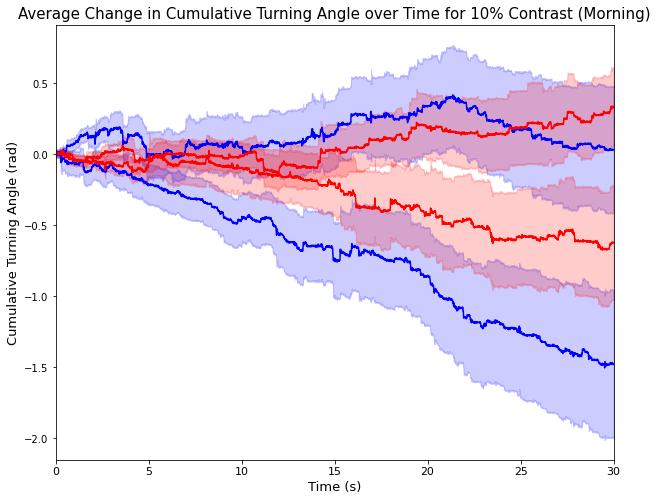

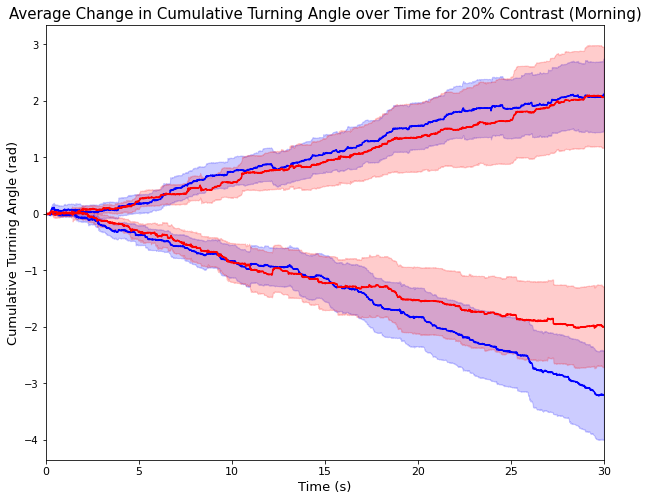

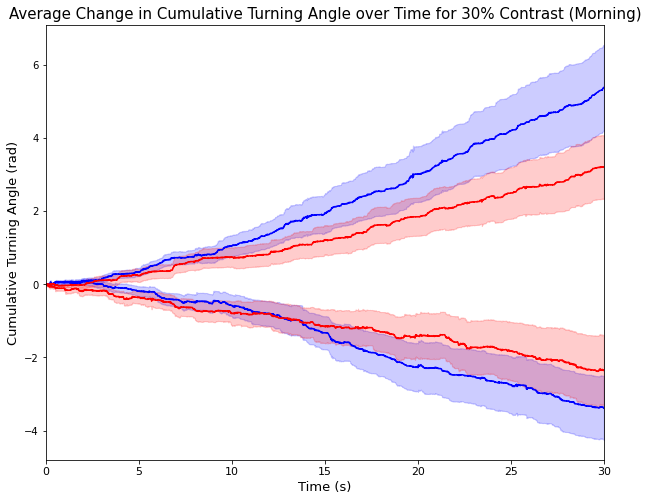

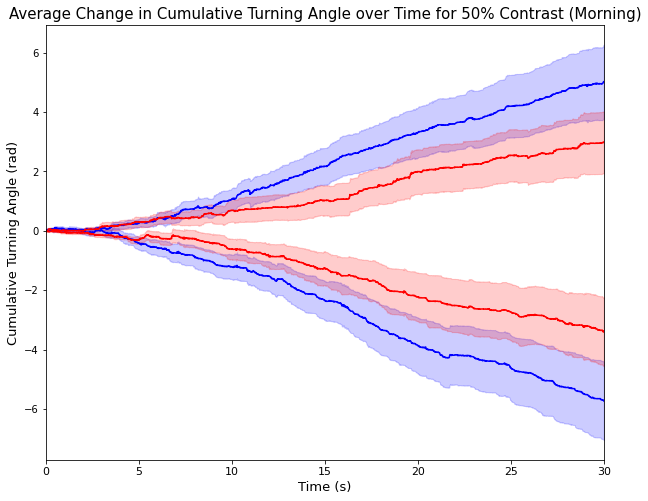

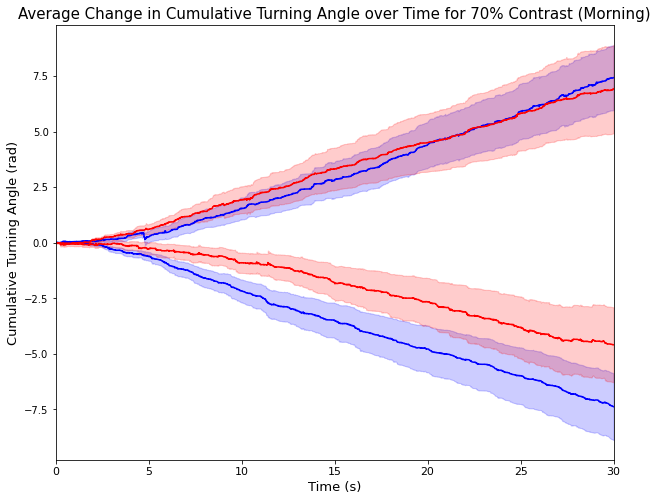

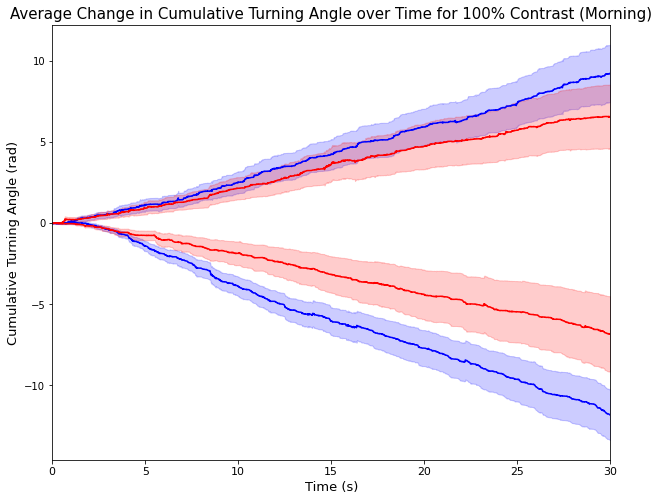

In [15]:
for c in ['1','10','20','30','50','70','100']:
    exec(f'avg_am_LeC{c}_trajectory = np.mean(am_comb_LeC{c}[:,:,4],axis=0)')
    exec(f'avg_am_ReC{c}_trajectory = np.mean(am_comb_ReC{c}[:,:,4],axis=0)')

    exec(f'avg_am_LeC{c}_SEM = stats.sem(am_comb_LeC{c}[:,:,4],axis=0)')
    exec(f'avg_am_ReC{c}_SEM = stats.sem(am_comb_ReC{c}[:,:,4],axis=0)')
    
    exec(f'avg_am_LmeC{c}_trajectory = np.mean(am_comb_LmeC{c}[:,:,4],axis=0)')
    exec(f'avg_am_RmeC{c}_trajectory = np.mean(am_comb_RmeC{c}[:,:,4],axis=0)')

    exec(f'avg_am_LmeC{c}_SEM = stats.sem(am_comb_LmeC{c}[:,:,4],axis=0)')
    exec(f'avg_am_RmeC{c}_SEM = stats.sem(am_comb_RmeC{c}[:,:,4],axis=0)')

    exec(f'fig, ax = plt.subplots(1,1,figsize=(10,8))')
    exec(f'plt.title("Average Change in Cumulative Turning Angle over Time for {c}% Contrast (Morning)",fontsize=15)')
    exec(f'ax.set_xlabel("Time (s)",fontsize=13)')
    exec(f'ax.set_ylabel("Cumulative Turning Angle (rad)",fontsize=13)')
    exec(f'ax.set_xlim(0,3000)')
    exec(f'x_ticks = [0, 500, 1000, 1500, 2000, 2500, 3000]')
    exec(f'x_labels = [0, 5, 10, 15, 20, 25, 30] ')
    exec(f'plt.xticks(x_ticks,x_labels,fontsize=11)')
    exec(f'ax.plot(avg_am_LeC{c}_trajectory,c="b")')
    exec(f'ax.plot(avg_am_ReC{c}_trajectory,c="b")')
    exec(f'ax.plot(avg_am_LmeC{c}_trajectory,c="r")')
    exec(f'ax.plot(avg_am_RmeC{c}_trajectory,c="r")')
    exec(f'ax.fill_between(range(0,3000), avg_am_LeC{c}_trajectory-avg_am_LeC{c}_SEM, avg_am_LeC{c}_trajectory+\
            avg_am_LeC{c}_SEM,color="b",alpha=0.2)')
    exec(f'ax.fill_between(range(0,3000), avg_am_ReC{c}_trajectory-avg_am_ReC{c}_SEM, avg_am_ReC{c}_trajectory+\
            avg_am_ReC{c}_SEM,color="b",alpha=0.2)')
    exec(f'ax.fill_between(range(0,3000), avg_am_LmeC{c}_trajectory-avg_am_LmeC{c}_SEM, avg_am_LmeC{c}_trajectory+\
            avg_am_LmeC{c}_SEM,color="r",alpha=0.2)')
    exec(f'ax.fill_between(range(0,3000), avg_am_RmeC{c}_trajectory-avg_am_RmeC{c}_SEM, avg_am_RmeC{c}_trajectory+\
            avg_am_RmeC{c}_SEM,color="r",alpha=0.2)')
    exec(f'plt.show()')

## Combining Left and Right Flows

In [16]:
pm_comb_ReC100[:,-1,4]

array([-1.25554300e+01, -1.41120800e+01, -4.38491000e+00, -1.62367360e+01,
       -1.41446540e+01, -1.63969500e+01, -3.68364400e+01, -1.90449100e+01,
        9.13079000e-01, -2.08150000e+01, -6.41373500e-01,  1.12029000e+00,
       -4.54720000e+00, -1.52269009e+01, -1.91186014e+01, -6.06758000e+00,
       -2.05602000e+01, -1.78635800e+01, -4.62366300e+01, -2.04948300e+01,
       -2.60604970e+01, -3.15523600e+01, -2.64660000e+00, -7.81818000e+00,
       -1.83774890e+01, -2.04882540e+01, -5.92000000e-02, -2.53152100e+01,
       -1.62007820e+01, -3.58956250e+01,  2.33095000e+00, -1.81203000e+01,
       -2.29604000e+01, -8.97459100e+00, -1.15970740e+01, -9.85000000e-03,
       -1.81944000e+01, -2.49651900e+01, -5.20894000e+00, -1.91169030e+01,
       -2.13472170e+01, -2.21699300e+01, -1.40618100e+01, -5.08411800e+00])

In [17]:
pm_L100_ttest =  pm_comb_LeC100[:,-1,4]
pm_R100_ttest = abs(pm_comb_ReC100[:,-1,4])

am_L100_ttest = am_comb_LeC100[:,-1,4]
am_R100_ttest = abs(am_comb_ReC100[:,-1,4])

In [18]:
pm_L70_ttest =  pm_comb_LeC70[:,-1,4]
pm_R70_ttest = abs(pm_comb_ReC70[:,-1,4])

am_L70_ttest = am_comb_LeC70[:,-1,4]
am_R70_ttest = abs(am_comb_ReC70[:,-1,4])

In [19]:
pm_L50_ttest =  pm_comb_LeC50[:,-1,4]
pm_R50_ttest = abs(pm_comb_ReC50[:,-1,4])

am_L50_ttest = am_comb_LeC50[:,-1,4]
am_R50_ttest = abs(am_comb_ReC50[:,-1,4])

In [20]:
stats.ttest_ind(pm_L50_ttest,pm_R50_ttest)

Ttest_indResult(statistic=-1.6983431938197902, pvalue=0.09310098922805728)

In [21]:
stats.ttest_ind(am_L50_ttest,am_R50_ttest)

Ttest_indResult(statistic=-0.8447730230556244, pvalue=0.4015387537465561)

In [22]:
stats.ttest_ind(pm_L70_ttest,pm_R70_ttest)

Ttest_indResult(statistic=-0.4936910554245918, pvalue=0.622768442904942)

In [23]:
stats.ttest_ind(pm_L100_ttest,pm_R100_ttest)

Ttest_indResult(statistic=-2.548206832300571, pvalue=0.012583185530772282)

In [24]:
stats.ttest_ind(am_L70_ttest,am_R70_ttest)

Ttest_indResult(statistic=-0.1596320412669635, pvalue=0.873673666842292)

In [25]:
stats.ttest_ind(am_L100_ttest,am_R100_ttest)

Ttest_indResult(statistic=-1.1293152531804151, pvalue=0.26488428718930235)

In [26]:
pm_comb_ReC1[:,:,4] = abs(pm_comb_ReC1[:,:,4])
pm_comb_ReC10[:,:,4] = abs(pm_comb_ReC10[:,:,4])
pm_comb_ReC20[:,:,4] = abs(pm_comb_ReC20[:,:,4])
pm_comb_ReC30[:,:,4] = abs(pm_comb_ReC30[:,:,4])
pm_comb_ReC50[:,:,4] = abs(pm_comb_ReC50[:,:,4])
pm_comb_ReC70[:,:,4] = abs(pm_comb_ReC70[:,:,4])
pm_comb_ReC100[:,:,4] = abs(pm_comb_ReC100[:,:,4])

In [27]:
am_comb_ReC1[:,:,4] = abs(am_comb_ReC1[:,:,4])
am_comb_ReC10[:,:,4] = abs(am_comb_ReC10[:,:,4])
am_comb_ReC20[:,:,4] = abs(am_comb_ReC20[:,:,4])
am_comb_ReC30[:,:,4] = abs(am_comb_ReC30[:,:,4])
am_comb_ReC50[:,:,4] = abs(am_comb_ReC50[:,:,4])
am_comb_ReC70[:,:,4] = abs(am_comb_ReC70[:,:,4])
am_comb_ReC100[:,:,4] = abs(am_comb_ReC100[:,:,4])

In [28]:
pm_comb_RmeC1[:,:,4] = abs(pm_comb_RmeC1[:,:,4])
pm_comb_RmeC10[:,:,4] = abs(pm_comb_RmeC10[:,:,4])
pm_comb_RmeC20[:,:,4] = abs(pm_comb_RmeC20[:,:,4])
pm_comb_RmeC30[:,:,4] = abs(pm_comb_RmeC30[:,:,4])
pm_comb_RmeC50[:,:,4] = abs(pm_comb_RmeC50[:,:,4])
pm_comb_RmeC70[:,:,4] = abs(pm_comb_RmeC70[:,:,4])
pm_comb_RmeC100[:,:,4] = abs(pm_comb_RmeC100[:,:,4])

In [29]:
am_comb_RmeC1[:,:,4] = abs(am_comb_RmeC1[:,:,4])
am_comb_RmeC10[:,:,4] = abs(am_comb_RmeC10[:,:,4])
am_comb_RmeC20[:,:,4] = abs(am_comb_RmeC20[:,:,4])
am_comb_RmeC30[:,:,4] = abs(am_comb_RmeC30[:,:,4])
am_comb_RmeC50[:,:,4] = abs(am_comb_RmeC50[:,:,4])
am_comb_RmeC70[:,:,4] = abs(am_comb_RmeC70[:,:,4])
am_comb_RmeC100[:,:,4] = abs(am_comb_RmeC100[:,:,4])

In [30]:
pm_eC1 = np.vstack((pm_comb_LeC1,pm_comb_ReC1))
pm_eC10 = np.vstack((pm_comb_LeC10,pm_comb_ReC10))
pm_eC20 = np.vstack((pm_comb_LeC20,pm_comb_ReC20))
pm_eC30 = np.vstack((pm_comb_LeC30,pm_comb_ReC30))
pm_eC50 = np.vstack((pm_comb_LeC50,pm_comb_ReC50))
pm_eC70 = np.vstack((pm_comb_LeC70,pm_comb_ReC70))
pm_eC100 = np.vstack((pm_comb_LeC100,pm_comb_ReC100))

In [31]:
pm_eC100.shape

(89, 3000, 6)

In [32]:
am_eC1 = np.vstack((am_comb_LeC1,am_comb_ReC1))
am_eC10 = np.vstack((am_comb_LeC10,am_comb_ReC10))
am_eC20 = np.vstack((am_comb_LeC20,am_comb_ReC20))
am_eC30 = np.vstack((am_comb_LeC30,am_comb_ReC30))
am_eC50 = np.vstack((am_comb_LeC50,am_comb_ReC50))
am_eC70 = np.vstack((am_comb_LeC70,am_comb_ReC70))
am_eC100 = np.vstack((am_comb_LeC100,am_comb_ReC100))

In [33]:
pm_meC1 = np.vstack((pm_comb_LmeC1,pm_comb_RmeC1))
pm_meC10 = np.vstack((pm_comb_LmeC10,pm_comb_RmeC10))
pm_meC20 = np.vstack((pm_comb_LmeC20,pm_comb_RmeC20))
pm_meC30 = np.vstack((pm_comb_LmeC30,pm_comb_RmeC30))
pm_meC50 = np.vstack((pm_comb_LmeC50,pm_comb_RmeC50))
pm_meC70 = np.vstack((pm_comb_LmeC70,pm_comb_RmeC70))
pm_meC100 = np.vstack((pm_comb_LmeC100,pm_comb_RmeC100))

In [34]:
am_meC1 = np.vstack((am_comb_LmeC1,am_comb_RmeC1))
am_meC10 = np.vstack((am_comb_LmeC10,am_comb_RmeC10))
am_meC20 = np.vstack((am_comb_LmeC20,am_comb_RmeC20))
am_meC30 = np.vstack((am_comb_LmeC30,am_comb_RmeC30))
am_meC50 = np.vstack((am_comb_LmeC50,am_comb_RmeC50))
am_meC70 = np.vstack((am_comb_LmeC70,am_comb_RmeC70))
am_meC100 = np.vstack((am_comb_LmeC100,am_comb_RmeC100))

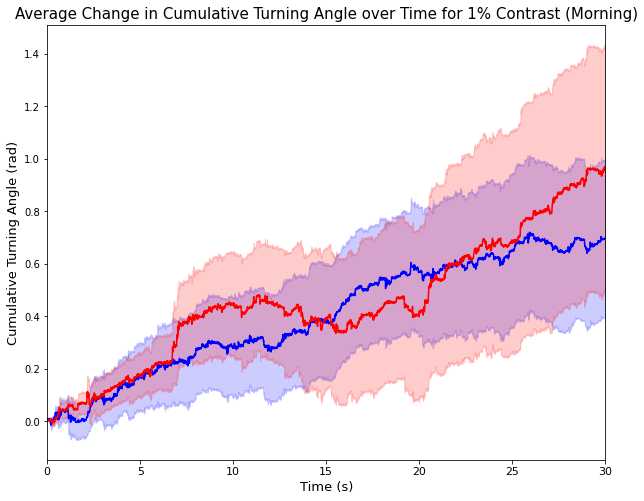

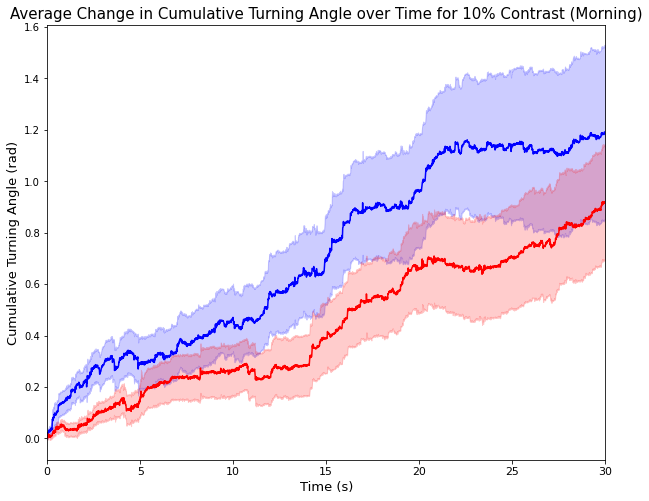

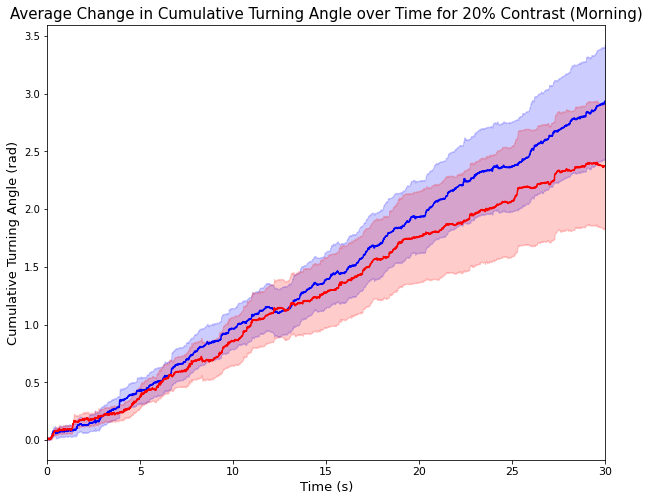

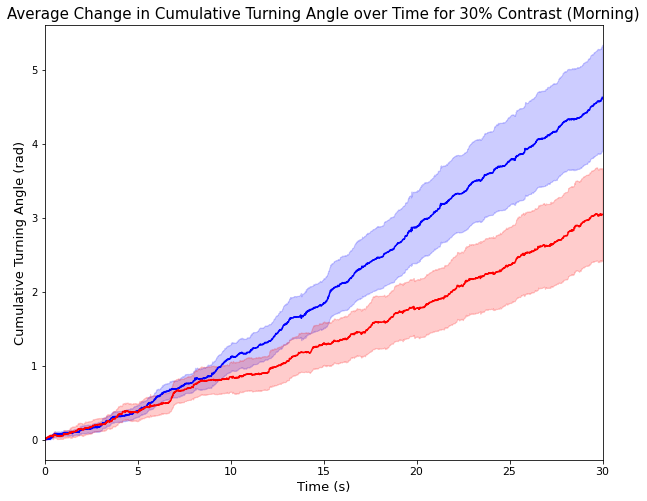

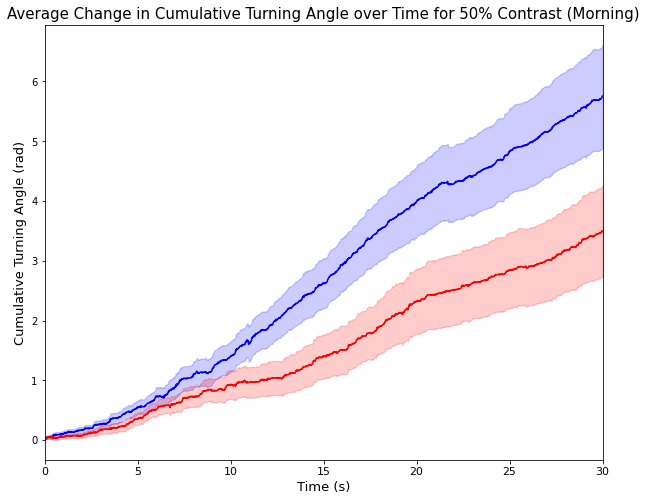

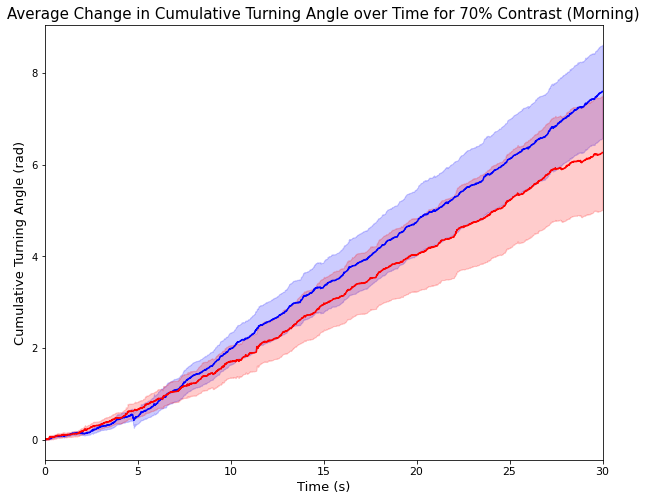

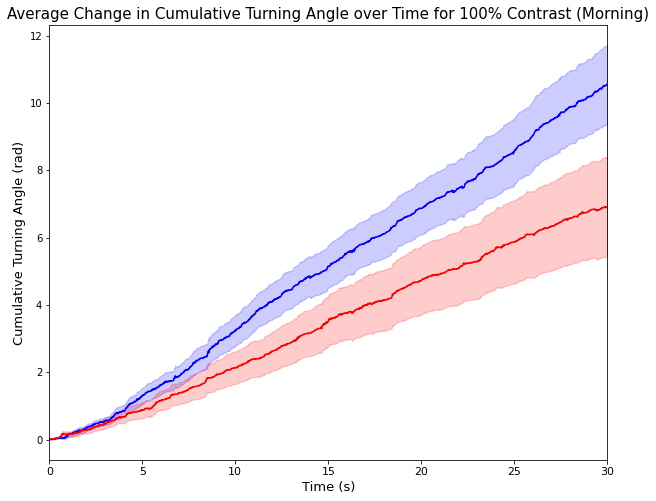

In [35]:
for c in ['1','10','20','30','50','70','100']:
    exec(f'avg_am_eC{c}_trajectory = np.mean(am_eC{c}[:,:,4],axis=0)')
#     exec(f'avg_am_eC{c}_trajectory = np.mean(am_comb_ReC{c}[:,:,4],axis=0)')

    exec(f'avg_am_eC{c}_SEM = stats.sem(am_eC{c}[:,:,4],axis=0)')
#     exec(f'avg_am_eC{c}_SEM = stats.sem(am_comb_ReC{c}[:,:,4],axis=0)')
    
    exec(f'avg_am_meC{c}_trajectory = np.mean(am_meC{c}[:,:,4],axis=0)')
#     exec(f'avg_am_meC{c}_trajectory = np.mean(am_comb_RmeC{c}[:,:,4],axis=0)')

    exec(f'avg_am_meC{c}_SEM = stats.sem(am_meC{c}[:,:,4],axis=0)')
#     exec(f'avg_am_meC{c}_SEM = stats.sem(am_comb_RmeC{c}[:,:,4],axis=0)')

    exec(f'fig, ax = plt.subplots(1,1,figsize=(10,8))')
    exec(f'plt.title("Average Change in Cumulative Turning Angle over Time for {c}% Contrast (Morning)",fontsize=15)')
    exec(f'ax.set_xlabel("Time (s)",fontsize=13)')
    exec(f'ax.set_ylabel("Cumulative Turning Angle (rad)",fontsize=13)')
    exec(f'ax.set_xlim(0,3000)')
    exec(f'x_ticks = [0, 500, 1000, 1500, 2000, 2500, 3000]')
    exec(f'x_labels = [0, 5, 10, 15, 20, 25, 30] ')
    exec(f'plt.xticks(x_ticks,x_labels,fontsize=11)')
    exec(f'ax.plot(avg_am_eC{c}_trajectory,c="b")')
    exec(f'ax.plot(avg_am_meC{c}_trajectory,c="r")')
#     exec(f'ax.plot(avg_am_LmeC{c}_trajectory,c="g")')
#     exec(f'ax.plot(avg_am_RmeC{c}_trajectory,c="k")')
    exec(f'ax.fill_between(range(0,3000), avg_am_eC{c}_trajectory-avg_am_eC{c}_SEM, avg_am_eC{c}_trajectory+\
            avg_am_eC{c}_SEM,color="b",alpha=0.2)')
    exec(f'ax.fill_between(range(0,3000), avg_am_meC{c}_trajectory-avg_am_meC{c}_SEM, avg_am_meC{c}_trajectory+\
            avg_am_meC{c}_SEM,color="r",alpha=0.2)')
#     exec(f'ax.fill_between(range(0,3000), avg_am_LmeC{c}_trajectory-avg_am_LmeC{c}_SEM, avg_am_LmeC{c}_trajectory+\
#             avg_am_LmeC{c}_SEM,color="g",alpha=0.2)')
#     exec(f'ax.fill_between(range(0,3000), avg_am_RmeC{c}_trajectory-avg_am_RmeC{c}_SEM, avg_am_RmeC{c}_trajectory+\
#             avg_am_RmeC{c}_SEM,color="grey",alpha=0.2)')
    exec(f'plt.show()')

## Saving Stacked Data as csv

In [36]:
# pd.DataFrame(pm_eC1.copy().reshape(pm_eC1.shape[0]*pm_eC1.shape[1],-1)).to_csv('../raw_data/pm_eC1.csv')
# pd.DataFrame(pm_eC10.copy().reshape(pm_eC10.shape[0]*pm_eC10.shape[1],-1)).to_csv('../raw_data/pm_eC10.csv')
# pd.DataFrame(pm_eC20.copy().reshape(pm_eC20.shape[0]*pm_eC20.shape[1],-1)).to_csv('../raw_data/pm_eC20.csv')
# pd.DataFrame(pm_eC30.copy().reshape(pm_eC30.shape[0]*pm_eC30.shape[1],-1)).to_csv('../raw_data/pm_eC30.csv')
# pd.DataFrame(pm_eC50.copy().reshape(pm_eC50.shape[0]*pm_eC50.shape[1],-1)).to_csv('../raw_data/pm_eC50.csv')
# pd.DataFrame(pm_eC70.copy().reshape(pm_eC70.shape[0]*pm_eC70.shape[1],-1)).to_csv('../raw_data/pm_eC70.csv')
# pd.DataFrame(pm_eC100.copy().reshape(pm_eC100.shape[0]*pm_eC100.shape[1],-1)).to_csv('../raw_data/pm_eC100.csv')

In [37]:
# pd.DataFrame(pm_meC1.copy().reshape(pm_meC1.shape[0]*pm_meC1.shape[1],-1)).to_csv('../raw_data/pm_meC1.csv')
# pd.DataFrame(pm_meC10.copy().reshape(pm_meC10.shape[0]*pm_meC10.shape[1],-1)).to_csv('../raw_data/pm_meC10.csv')
# pd.DataFrame(pm_meC20.copy().reshape(pm_meC20.shape[0]*pm_meC20.shape[1],-1)).to_csv('../raw_data/pm_meC20.csv')
# pd.DataFrame(pm_meC30.copy().reshape(pm_meC30.shape[0]*pm_meC30.shape[1],-1)).to_csv('../raw_data/pm_meC30.csv')
# pd.DataFrame(pm_meC50.copy().reshape(pm_meC50.shape[0]*pm_meC50.shape[1],-1)).to_csv('../raw_data/pm_meC50.csv')
# pd.DataFrame(pm_meC70.copy().reshape(pm_meC70.shape[0]*pm_meC70.shape[1],-1)).to_csv('../raw_data/pm_meC70.csv')
# pd.DataFrame(pm_meC100.copy().reshape(pm_meC100.shape[0]*pm_meC100.shape[1],-1)).to_csv('../raw_data/pm_meC100.csv')

In [38]:
# pd.DataFrame(am_eC1.copy().reshape(am_eC1.shape[0]*am_eC1.shape[1],-1)).to_csv('../raw_data/am_eC1.csv')
# pd.DataFrame(am_eC10.copy().reshape(am_eC10.shape[0]*am_eC10.shape[1],-1)).to_csv('../raw_data/am_eC10.csv')
# pd.DataFrame(am_eC20.copy().reshape(am_eC20.shape[0]*am_eC20.shape[1],-1)).to_csv('../raw_data/am_eC20.csv')
# pd.DataFrame(am_eC30.copy().reshape(am_eC30.shape[0]*am_eC30.shape[1],-1)).to_csv('../raw_data/am_eC30.csv')
# pd.DataFrame(am_eC50.copy().reshape(am_eC50.shape[0]*am_eC50.shape[1],-1)).to_csv('../raw_data/am_eC50.csv')
# pd.DataFrame(am_eC70.copy().reshape(am_eC70.shape[0]*am_eC70.shape[1],-1)).to_csv('../raw_data/am_eC70.csv')
# pd.DataFrame(am_eC100.copy().reshape(am_eC100.shape[0]*am_eC100.shape[1],-1)).to_csv('../raw_data/am_eC100.csv')

In [39]:
# pd.DataFrame(am_meC1.copy().reshape(am_meC1.shape[0]*am_meC1.shape[1],-1)).to_csv('../raw_data/am_meC1.csv')
# pd.DataFrame(am_meC10.copy().reshape(am_meC10.shape[0]*am_meC10.shape[1],-1)).to_csv('../raw_data/am_meC10.csv')
# pd.DataFrame(am_meC20.copy().reshape(am_meC20.shape[0]*am_meC20.shape[1],-1)).to_csv('../raw_data/am_meC20.csv')
# pd.DataFrame(am_meC30.copy().reshape(am_meC30.shape[0]*am_meC30.shape[1],-1)).to_csv('../raw_data/am_meC30.csv')
# pd.DataFrame(am_meC50.copy().reshape(am_meC50.shape[0]*am_meC50.shape[1],-1)).to_csv('../raw_data/am_meC50.csv')
# pd.DataFrame(am_meC70.copy().reshape(am_meC70.shape[0]*am_meC70.shape[1],-1)).to_csv('../raw_data/am_meC70.csv')
# pd.DataFrame(am_meC100.copy().reshape(am_meC100.shape[0]*am_meC100.shape[1],-1)).to_csv('../raw_data/am_meC100.csv')

In [40]:
# pm_eC1 = pd.read_csv('../raw_data/pm_eC1.csv').reshape(90,3000,6)
# pm_eC10 = pd.read_csv('../raw_data/pm_eC10.csv').reshape(90,3000,6)
# pm_eC20 = pd.read_csv('../raw_data/pm_eC20.csv').reshape(91,3000,6)
# pm_eC30 = pd.read_csv('../raw_data/pm_eC30.csv').reshape(90,3000,6)
# pm_eC50 = pd.read_csv('../raw_data/pm_eC50.csv').reshape(87,3000,6)
# pm_eC70 = pd.read_csv('../raw_data/pm_eC70.csv').reshape(89,3000,6)
# pm_eC100 = pd.read_csv('../raw_data/pm_eC100.csv').reshape(89,3000,6)

In [41]:
# pm_meC1 = pd.read_csv('../raw_data/pm_meC1.csv').reshape(88,3000,6)
# pm_meC10 = pd.read_csv('../raw_data/pm_meC10.csv').reshape(86,3000,6)
# pm_meC20 = pd.read_csv('../raw_data/pm_meC20.csv').reshape(92,3000,6)
# pm_meC30 = pd.read_csv('../raw_data/pm_meC30.csv').reshape(90,3000,6)
# pm_meC50 = pd.read_csv('../raw_data/pm_meC50.csv').reshape(96,3000,6)
# pm_meC70 = pd.read_csv('../raw_data/pm_meC70.csv').reshape(95,3000,6)
# pm_meC100 = pd.read_csv('../raw_data/pm_meC100.csv').reshape(83,3000,6)

In [42]:
# am_eC1 = pd.read_csv('../raw_data/am_eC1.csv').reshape(63,3000,6)
# am_eC10 = pd.read_csv('../raw_data/am_eC10.csv').reshape(62,3000,6)
# am_eC20 = pd.read_csv('../raw_data/am_eC20.csv').reshape(63,3000,6)
# am_eC30 = pd.read_csv('../raw_data/am_eC30.csv').reshape(64,3000,6)
# am_eC50 = pd.read_csv('../raw_data/am_eC50.csv').reshape(63,3000,6)
# am_eC70 = pd.read_csv('../raw_data/am_eC70.csv').reshape(66,3000,6)
# am_eC100 = pd.read_csv('../raw_data/am_eC100.csv').reshape(46,3000,6)

In [43]:
# am_meC1 = pd.read_csv('../raw_data/am_meC1.csv').reshape(58,3000,6)
# am_meC10 = pd.read_csv('../raw_data/am_meC10.csv').reshape(60,3000,6)
# am_meC20 = pd.read_csv('../raw_data/am_meC20.csv').reshape(57,3000,6)
# am_meC30 = pd.read_csv('../raw_data/am_meC30.csv').reshape(65,3000,6)
# am_meC50 = pd.read_csv('../raw_data/am_meC50.csv').reshape(56,3000,6)
# am_meC70 = pd.read_csv('../raw_data/am_meC70.csv').reshape(59,3000,6)
# am_meC100 = pd.read_csv('../raw_data/am_meC100.csv').reshape(51,3000,6)

## Calculation of Mean and SEM of Cumulative Angles

In [44]:
pm_eC1_cum = pm_eC1[:,-1,4]
pm_eC10_cum = pm_eC10[:,-1,4]
pm_eC20_cum = pm_eC20[:,-1,4]
pm_eC30_cum = pm_eC30[:,-1,4]
pm_eC50_cum = pm_eC50[:,-1,4]
pm_eC70_cum = pm_eC70[:,-1,4]
pm_eC100_cum = pm_eC100[:,-1,4]

In [45]:
am_eC1_cum = am_eC1[:,-1,4]
am_eC10_cum = am_eC10[:,-1,4]
am_eC20_cum = am_eC20[:,-1,4]
am_eC30_cum = am_eC30[:,-1,4]
am_eC50_cum = am_eC50[:,-1,4]
am_eC70_cum = am_eC70[:,-1,4]
am_eC100_cum = am_eC100[:,-1,4]

In [46]:
pm_meC1_cum = pm_meC1[:,-1,4]
pm_meC10_cum = pm_meC10[:,-1,4]
pm_meC20_cum = pm_meC20[:,-1,4]
pm_meC30_cum = pm_meC30[:,-1,4]
pm_meC50_cum = pm_meC50[:,-1,4]
pm_meC70_cum = pm_meC70[:,-1,4]
pm_meC100_cum = pm_meC100[:,-1,4]

In [47]:
am_meC1_cum = am_meC1[:,-1,4]
am_meC10_cum = am_meC10[:,-1,4]
am_meC20_cum = am_meC20[:,-1,4]
am_meC30_cum = am_meC30[:,-1,4]
am_meC50_cum = am_meC50[:,-1,4]
am_meC70_cum = am_meC70[:,-1,4]
am_meC100_cum = am_meC100[:,-1,4]

In [48]:
pm_eC1_sem = stats.sem(pm_eC1[:,-1,4])
pm_eC10_sem = stats.sem(pm_eC10[:,-1,4])
pm_eC20_sem = stats.sem(pm_eC20[:,-1,4])
pm_eC30_sem = stats.sem(pm_eC30[:,-1,4])
pm_eC50_sem = stats.sem(pm_eC50[:,-1,4])
pm_eC70_sem = stats.sem(pm_eC70[:,-1,4])
pm_eC100_sem = stats.sem(pm_eC100[:,-1,4])

In [49]:
am_eC1_sem = stats.sem(am_eC1[:,-1,4])
am_eC10_sem = stats.sem(am_eC10[:,-1,4])
am_eC20_sem = stats.sem(am_eC20[:,-1,4])
am_eC30_sem = stats.sem(am_eC30[:,-1,4])
am_eC50_sem = stats.sem(am_eC50[:,-1,4])
am_eC70_sem = stats.sem(am_eC70[:,-1,4])
am_eC100_sem = stats.sem(am_eC100[:,-1,4])

In [50]:
pm_meC1_sem = stats.sem(pm_meC1[:,-1,4])
pm_meC10_sem = stats.sem(pm_meC10[:,-1,4])
pm_meC20_sem = stats.sem(pm_meC20[:,-1,4])
pm_meC30_sem = stats.sem(pm_meC30[:,-1,4])
pm_meC50_sem = stats.sem(pm_meC50[:,-1,4])
pm_meC70_sem = stats.sem(pm_meC70[:,-1,4])
pm_meC100_sem = stats.sem(pm_meC100[:,-1,4])

In [51]:
am_meC1_sem = stats.sem(am_meC1[:,-1,4])
am_meC10_sem = stats.sem(am_meC10[:,-1,4])
am_meC20_sem = stats.sem(am_meC20[:,-1,4])
am_meC30_sem = stats.sem(am_meC30[:,-1,4])
am_meC50_sem = stats.sem(am_meC50[:,-1,4])
am_meC70_sem = stats.sem(am_meC70[:,-1,4])
am_meC100_sem = stats.sem(am_meC100[:,-1,4])

In [52]:
x = [1,10,20,30,50,70,100]
pm_e_yerr = [pm_eC1_sem,pm_eC10_sem,pm_eC20_sem,pm_eC30_sem,pm_eC50_sem,pm_eC70_sem,pm_eC100_sem]
pm_me_yerr = [pm_meC1_sem,pm_meC10_sem,pm_meC20_sem,pm_meC30_sem,pm_meC50_sem,pm_meC70_sem,pm_meC100_sem]
am_e_yerr = [am_eC1_sem,am_eC10_sem,am_eC20_sem,am_eC30_sem,am_eC50_sem,am_eC70_sem,am_eC100_sem]
am_me_yerr = [am_meC1_sem,am_meC10_sem,am_meC20_sem,am_meC30_sem,am_meC50_sem,am_meC70_sem,am_meC100_sem]

pm_e_cum = [np.mean(pm_eC1_cum),np.mean(pm_eC10_cum),np.mean(pm_eC20_cum),np.mean(pm_eC30_cum),\
                                 np.mean(pm_eC50_cum),np.mean(pm_eC70_cum),np.mean(pm_eC100_cum)]
pm_me_cum = [np.mean(pm_meC1_cum),np.mean(pm_meC10_cum),np.mean(pm_meC20_cum),np.mean(pm_meC30_cum),\
                                 np.mean(pm_meC50_cum),np.mean(pm_meC70_cum),np.mean(pm_meC100_cum)]

am_e_cum = [np.mean(am_eC1_cum),np.mean(am_eC10_cum),np.mean(am_eC20_cum),np.mean(am_eC30_cum),\
                                 np.mean(am_eC50_cum),np.mean(am_eC70_cum),np.mean(am_eC100_cum)]
am_me_cum = [np.mean(am_meC1_cum),np.mean(am_meC10_cum),np.mean(am_meC20_cum),np.mean(am_meC30_cum),\
                                 np.mean(am_meC50_cum),np.mean(am_meC70_cum),np.mean(am_meC100_cum)]

## Fitting Sigmoid Curve

/var/folders/wd/4w68b8ld47x6kzpx1zhzn8qm0000gn/T/ipykernel_52759/2780036809.py:2: RuntimeWarning: overflow encountered in exp
  y = L / (1 + np.exp(-k*(x-x0)))+b


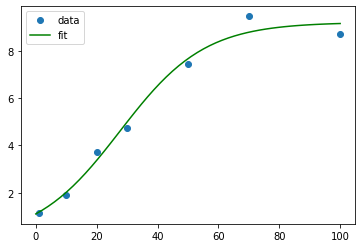

In [53]:
def sigmoid(x, L ,x0, k, b):
    y = L / (1 + np.exp(-k*(x-x0)))+b
    return (y)

xdata = [1,10,20,30,50,70,100]
ydata = pm_me_cum

p0 = [max(ydata), np.median(xdata),1,min(ydata)] # this is an mandatory initial guess

popt, pcov = curve_fit(sigmoid, xdata, ydata,p0, method='dogbox')

y = sigmoid(xdata, *popt)
new_x = np.linspace(0,100,50)
new_y = sigmoid(new_x, *popt)
plt.plot(xdata, ydata, 'o', label='data')
plt.plot(new_x,new_y,'g-',label='fit')
plt.legend()

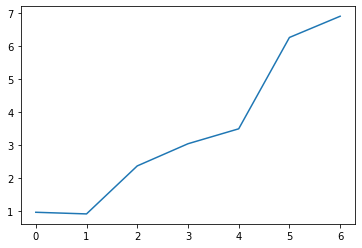

In [54]:
plt.plot(am_me_cum)

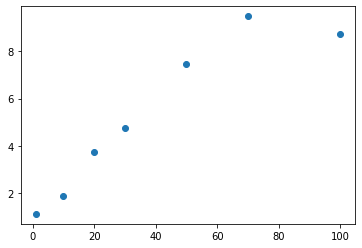

In [55]:
plt.plot(xdata,ydata,'o')

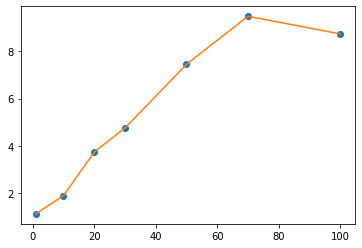

In [56]:
x = [1,10,20,30,50,70,100]
y = pm_me_cum
f = interpolate.interp1d(x, y)
xnew = np.arange(1, 100, 0.01)
ynew = f(xnew)   # use interpolation function returned by `interp1d`
plt.plot(x, y, 'o', xnew, ynew, '-')
plt.show()

In [57]:
def sigmoid(x, L ,x0, k, b):
    y = L / (1 + np.exp(-k*(x-x0)))+b
    return (y)

# xdata = [1,10,20,30,50,70,100]
# ydata = pm_me_cum

def fit_sigmoid(ydata):
    xdata = [1,10,20,30,50,70,100]
    p0 = [max(ydata), np.median(xdata),1,min(ydata)] # this is an mandatory initial guess
    popt, pcov = curve_fit(sigmoid, xdata, ydata,p0, method='dogbox')
    y = sigmoid(xdata, *popt)
    new_x = np.linspace(0,100,50)
    new_y = sigmoid(new_x, *popt)
    return new_y

In [58]:
popt, pcov = curve_fit(sigmoid, [1,10,20,30,50,70,100], pm_me_cum,p0, method='dogbox')
popt

/var/folders/wd/4w68b8ld47x6kzpx1zhzn8qm0000gn/T/ipykernel_52759/594421320.py:2: RuntimeWarning: overflow encountered in exp
  y = L / (1 + np.exp(-k*(x-x0)))+b


array([ 9.21869905e+00,  2.76222644e+01,  7.18427828e-02, -9.65785129e-03])

In [63]:
popt, pcov = curve_fit(straight_line, [1,10,20,30,50,70,100], am_me_cum)
popt

array([0.0652614 , 0.80469339])

In [64]:
pm_e_cum_fit = fit_sigmoid(pm_e_cum)
pm_me_cum_fit = fit_sigmoid(pm_me_cum)

am_e_cum_fit = fit_straight_line(am_e_cum)
am_me_cum_fit = fit_straight_line(am_me_cum)

/var/folders/wd/4w68b8ld47x6kzpx1zhzn8qm0000gn/T/ipykernel_52759/594421320.py:2: RuntimeWarning: overflow encountered in exp
  y = L / (1 + np.exp(-k*(x-x0)))+b


## Contrast Response Plot

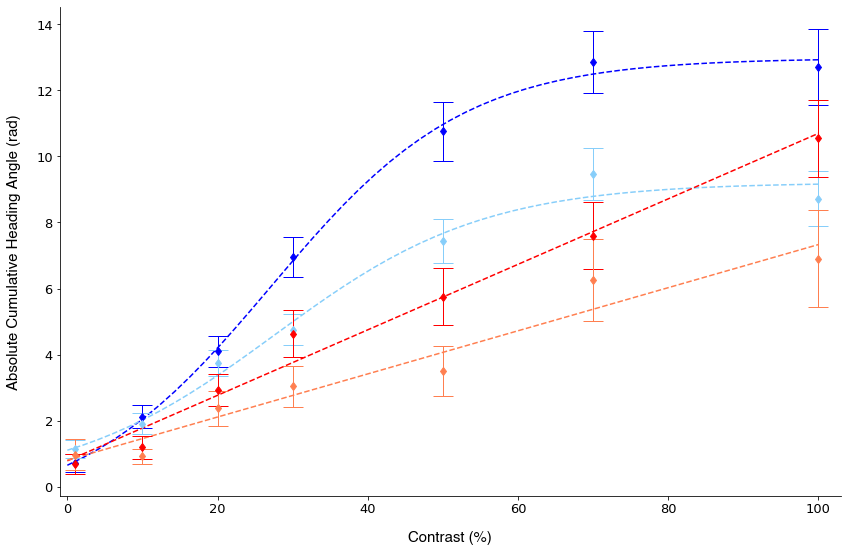

In [289]:
fig, ax = plt.subplots(1,1,figsize=(14,9))

x=[1,10,20,30,50,70,100]
# ax.plot(x,pm_e_cum,c='b',marker='d',mfc='b',label='E2 Bath (Afternoon)')
ax.plot(np.linspace(0,100,50),pm_e_cum_fit,'--b',label='Fitted E2 Bath (Afternoon)')
# ax.plot(x,pm_me_cum,c='lightskyblue',marker='d',mfc='lightskyblue',label='1mM Methionine (Afternoon)')
ax.plot(np.linspace(0,100,50),pm_me_cum_fit,c='lightskyblue',ls='--',label='Fitted 1mM Methionine (Afternoon)')
ax.errorbar(x,pm_e_cum,yerr=pm_e_yerr,fmt='d',color='b',capsize=10,elinewidth=1)
ax.errorbar(x,pm_me_cum,yerr=pm_me_yerr,fmt='d',color='lightskyblue',capsize=10,elinewidth=1)


# ax.plot(x,am_e_cum,c='r',marker='d',mfc='r',label='E2 Bath (Morning)')
ax.plot(np.linspace(0,100,50),am_e_cum_fit,'--r',label='Fitted E2 Bath (Morning)')
# ax.plot(x,am_me_cum,c='coral',marker='d',mfc='coral',label='1mM Methionine (Morning)')
ax.plot(np.linspace(0,100,50),am_me_cum_fit,c='coral',ls='--',label='Fitted 1mM Methionine (Morning)')
ax.errorbar(x,am_e_cum,yerr=am_e_yerr,fmt='d',color='r',capsize=10,elinewidth=1)
ax.errorbar(x,am_me_cum,yerr=am_me_yerr,fmt='d',color='coral',capsize=10,elinewidth=1)


font = font_manager.FontProperties(family='Helvetica',
                                   style='normal', size=11)
# plt.legend(loc='upper left',prop=font)
plt.title('')
plt.xlabel('Contrast (%)',size=15,name='Helvetica',labelpad=15)
plt.ylabel('Absolute Cumulative Heading Angle (rad)',size=15,name='Helvetica',labelpad=15)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# plt.grid(which='major',axis='y')
# x_ticks = [1, 10, 20, 30, 50, 70, 100]
# x_labels = [1, 10, 20, 30, 50, 70, 100] 
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
# ax.set_ylim(0,15)
ax.set_xlim(-1,103)
plt.savefig('../../Dissertation/contrast_function.png',dpi=400,bbox_inches='tight')
plt.show()

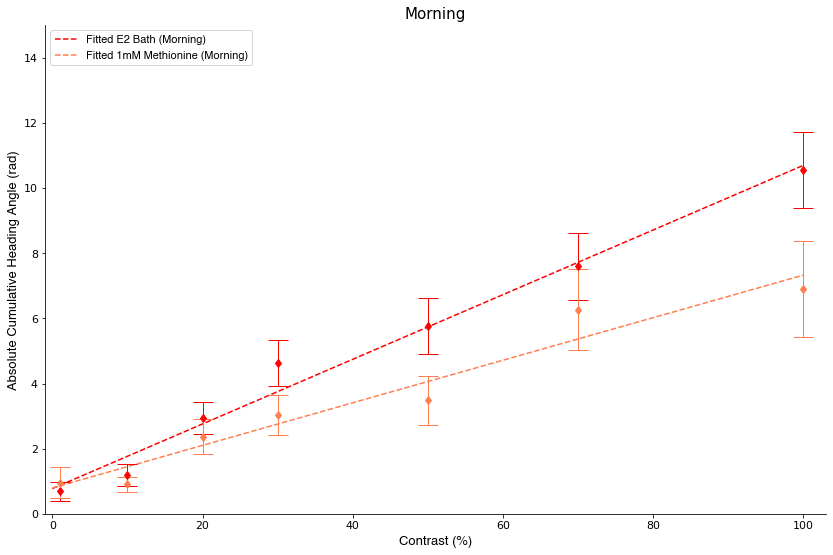

In [69]:
fig, ax = plt.subplots(1,1,figsize=(14,9))

# ax.plot(x,am_e_cum,c='r',marker='d',mfc='r',label='E2 Bath (Morning)')
ax.plot(np.linspace(0,100,50),am_e_cum_fit,'--r',label='Fitted E2 Bath (Morning)')
# ax.plot(x,am_me_cum,c='coral',marker='d',mfc='coral',label='1mM Methionine (Morning)')
ax.plot(np.linspace(0,100,50),am_me_cum_fit,c='coral',ls='--',label='Fitted 1mM Methionine (Morning)')
ax.errorbar(x,am_e_cum,yerr=am_e_yerr,fmt='d',color='r',capsize=10,elinewidth=1)
ax.errorbar(x,am_me_cum,yerr=am_me_yerr,fmt='d',color='coral',capsize=10,elinewidth=1)


font = font_manager.FontProperties(family='Helvetica',
                                   style='normal', size=11)
plt.legend(loc='upper left',prop=font)
plt.title('Morning',size=15)
plt.xlabel('Contrast (%)',size=13,name='Helvetica')
plt.ylabel('Absolute Cumulative Heading Angle (rad)',size=13,name='Helvetica')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
ax.set_ylim(0,15)
ax.set_xlim(-1,103)
plt.savefig('../../Dissertation/contrast_function_AM.png',dpi=400,bbox_inches='tight')
plt.show()

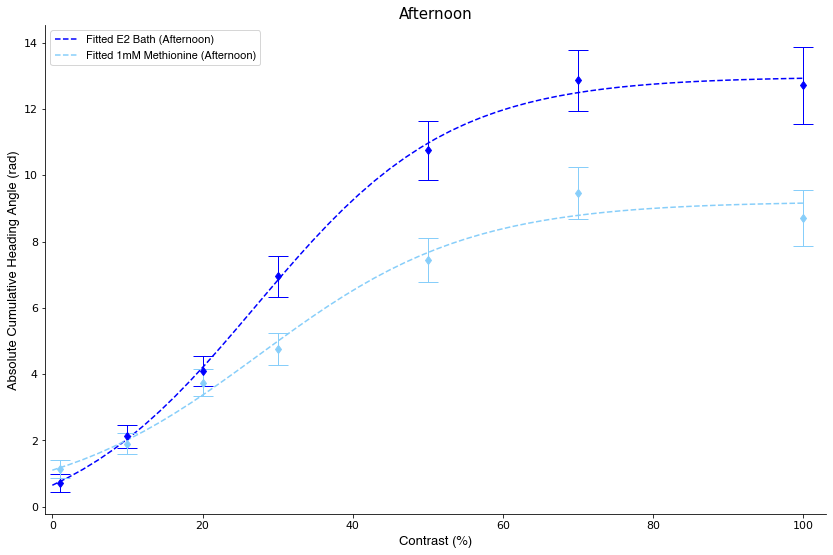

In [70]:
fig, ax = plt.subplots(1,1,figsize=(14,9))

# ax.plot(x,pm_e_cum,c='b',marker='d',mfc='b',label='E2 Bath (Afternoon)')
ax.plot(np.linspace(0,100,50),pm_e_cum_fit,'--b',label='Fitted E2 Bath (Afternoon)')
# ax.plot(x,pm_me_cum,c='lightskyblue',marker='d',mfc='lightskyblue',label='1mM Methionine (Afternoon)')
ax.plot(np.linspace(0,100,50),pm_me_cum_fit,c='lightskyblue',ls='--',label='Fitted 1mM Methionine (Afternoon)')
ax.errorbar(x,pm_e_cum,yerr=pm_e_yerr,fmt='d',color='b',capsize=10,elinewidth=1)
ax.errorbar(x,pm_me_cum,yerr=pm_me_yerr,fmt='d',color='lightskyblue',capsize=10,elinewidth=1)

font = font_manager.FontProperties(family='Helvetica',
                                   style='normal', size=11)
plt.legend(loc='upper left',prop=font)
plt.title('Afternoon',size=15)
plt.xlabel('Contrast (%)',size=13,name='Helvetica')
plt.ylabel('Absolute Cumulative Heading Angle (rad)',size=13,name='Helvetica')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
# ax.set_ylim(0,15)
ax.set_xlim(-1,103)
plt.savefig('../../Dissertation/contrast_function_PM.png',dpi=400,bbox_inches='tight')
plt.show()

## ANOVA DataFrames for Cumulative Angles

In [71]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [72]:
for m in ['e','me']:
    for t in ['pm','am']:
        for c in ['1','10','20','30','50','70','100']:
            exec(f"anova_df_{m}_{t}_{c} = pd.DataFrame(columns=['medium','time','contrast','final_cum_angle'])")
            exec(f"anova_df_{m}_{t}_{c}['final_cum_angle'] = {t}_{m}C{c}_cum")
            exec(f"anova_df_{m}_{t}_{c}['medium'] = '{m}'")
            exec(f"anova_df_{m}_{t}_{c}['time'] = '{t}'")
            exec(f"anova_df_{m}_{t}_{c}['contrast'] = {c}")

In [73]:
anova_df = pd.DataFrame(columns=['medium','time','contrast','final_cum_angle'])
anova_df = pd.concat([anova_df_e_am_1,anova_df_e_am_10,anova_df_e_am_20,anova_df_e_am_30,anova_df_e_am_50,\
                    anova_df_e_am_70,anova_df_e_am_100,\
                    anova_df_e_pm_1,anova_df_e_pm_10,anova_df_e_pm_20,anova_df_e_pm_30,anova_df_e_pm_50,\
                    anova_df_e_pm_70,anova_df_e_pm_100,\
                    anova_df_me_am_1,anova_df_me_am_10,anova_df_me_am_20,anova_df_me_am_30,anova_df_me_am_50,\
                    anova_df_me_am_70,anova_df_me_am_100,\
                    anova_df_me_pm_1,anova_df_me_pm_10,anova_df_me_pm_20,anova_df_me_pm_30,anova_df_me_pm_50,\
                    anova_df_me_pm_70,anova_df_me_pm_100])

In [74]:
anova_df_am = anova_df[anova_df['time']=='am']
anova_df_pm = anova_df[anova_df['time']=='pm']

In [75]:
anova_df_am_e = anova_df_am[anova_df_am['medium']=='e']
anova_df_am_me = anova_df_am[anova_df_am['medium']=='me']

anova_df_pm_e = anova_df_pm[anova_df_pm['medium']=='e']
anova_df_pm_me =anova_df_pm[anova_df_pm['medium']=='me']

In [76]:
anova_df.to_csv('../saved_data/anova_df.csv')

In [77]:
anova_df = anova_df.reset_index()
anova_df = anova_df.drop(columns='index')

## Levene Test and Welch ANOVA for Cumulative Angles

In [78]:
stats.levene(anova_df_e_am_1['final_cum_angle'],anova_df_e_am_10['final_cum_angle'],\
             anova_df_e_am_20['final_cum_angle'],anova_df_e_am_30['final_cum_angle'],\
             anova_df_e_am_50['final_cum_angle'],anova_df_e_am_70['final_cum_angle'],\
             anova_df_e_am_100['final_cum_angle'],anova_df_e_pm_1['final_cum_angle'],\
             anova_df_e_pm_10['final_cum_angle'],anova_df_e_pm_20['final_cum_angle'],\
             anova_df_e_pm_30['final_cum_angle'],anova_df_e_pm_50['final_cum_angle'],\
             anova_df_e_pm_70['final_cum_angle'],anova_df_e_pm_100['final_cum_angle'],\
             anova_df_me_am_1['final_cum_angle'],anova_df_me_am_10['final_cum_angle'],\
             anova_df_me_am_20['final_cum_angle'],anova_df_me_am_30['final_cum_angle'],\
             anova_df_me_am_50['final_cum_angle'],anova_df_me_am_70['final_cum_angle'],\
             anova_df_me_am_100['final_cum_angle'],anova_df_me_pm_1['final_cum_angle'],\
             anova_df_me_pm_10['final_cum_angle'],anova_df_me_pm_20['final_cum_angle'],\
             anova_df_me_pm_30['final_cum_angle'],anova_df_me_pm_50['final_cum_angle'],\
             anova_df_me_pm_70['final_cum_angle'],anova_df_me_pm_100['final_cum_angle'])

LeveneResult(statistic=19.59360281411081, pvalue=4.080527857994368e-83)

In [79]:
# stats.alexandergovern()

In [80]:
# stats.kruskal()

In [81]:
pg.anova(data=anova_df,dv='final_cum_angle',between='time')

,Source,ddof1,ddof2,F,p-unc,np2
0,time,1,2087,51.170361,1.166993e-12,0.023932


In [82]:
pg.welch_anova(data=anova_df_am,dv='final_cum_angle',between='medium')

,Source,ddof1,ddof2,F,p-unc,np2
0,medium,1,826.708061,6.971524,0.008438,0.008329


In [83]:
pg.welch_anova(data=anova_df_pm,dv='final_cum_angle',between='medium')

,Source,ddof1,ddof2,F,p-unc,np2
0,medium,1,1162.223943,18.3342,0.00002,0.014435


In [84]:
pg.welch_anova(data=anova_df_am,dv='final_cum_angle',between='contrast')

,Source,ddof1,ddof2,F,p-unc,np2
0,contrast,6,351.98134,27.275936,1.065365e-26,0.157577


In [85]:
pg.welch_anova(data=anova_df_pm,dv='final_cum_angle',between='contrast')

,Source,ddof1,ddof2,F,p-unc,np2
0,contrast,6,543.883066,97.925569,3.127342e-83,0.268913


##  Cumulative Angles OLS & ANOVA

In [86]:
model = ols(formula='final_cum_angle ~ C(time, Sum)',data=anova_df).fit()
anova_table = sm.stats.anova_lm(model, typ=3)
anova_table

,sum_sq,df,F,PR(>F)
Intercept,52262.744163,1.0,1037.315988,4.226836e-185
"C(time, Sum)",2578.099162,1.0,51.170361,1.166993e-12
Residual,105148.622301,2087.0,NaN,NaN


In [87]:
model = ols(formula='final_cum_angle ~ C(medium, Sum) + C(time, Sum) + C(contrast, Sum) + C(medium, Sum):\
                        C(time, Sum) + C(medium, Sum):C(contrast, Sum) + C(time, Sum):C(contrast, Sum) + \
                        C(medium, Sum):C(time, Sum):C(contrast, Sum)',data=anova_df).fit()
anova_table = sm.stats.anova_lm(model, typ=3)
anova_table

,sum_sq,df,F,PR(>F)
Intercept,53178.847926,1.0,1398.757538,4.092643e-234
"C(medium, Sum)",1276.082820,1.0,33.564670,7.954409e-09
"C(time, Sum)",2297.215758,1.0,60.423420,1.198204e-14
"C(contrast, Sum)",20561.288954,6.0,90.136897,1.199556e-100
"C(medium, Sum):C(time, Sum)",34.215221,1.0,0.899959,3.429038e-01
"C(medium, Sum):C(contrast, Sum)",951.113217,6.0,4.169505,3.577649e-04
"C(time, Sum):C(contrast, Sum)",1172.497585,6.0,5.140013,2.967588e-05
"C(medium, Sum):C(time, Sum):C(contrast, Sum)",73.331223,6.0,0.321471,9.260410e-01
Residual,78356.400307,2061.0,NaN,NaN


In [88]:
model_am = ols(formula='final_cum_angle ~ C(medium,Sum) + C(contrast, Sum) + \
                        C(medium,Sum):C(contrast, Sum)',data=anova_df_am).fit()
anova_table_am = sm.stats.anova_lm(model_am, typ=3)
anova_table_am

,sum_sq,df,F,PR(>F)
Intercept,13830.954691,1.0,377.304685,2.033007e-69
"C(medium, Sum)",369.865716,1.0,10.089836,1.546750e-03
"C(contrast, Sum)",5768.064791,6.0,26.225207,1.253892e-28
"C(medium, Sum):C(contrast, Sum)",284.642481,6.0,1.294162,2.572127e-01
Residual,30022.293233,819.0,NaN,NaN


In [89]:
model_am = ols(formula='final_cum_angle ~ C(medium,Sum)',data=anova_df_am).fit()
anova_table_am = sm.stats.anova_lm(model_am, typ=3)
anova_table_am

,sum_sq,df,F,PR(>F)
Intercept,13041.227297,1.0,300.433176,1.096308e-57
"C(medium, Sum)",302.950210,1.0,6.979120,8.401631e-03
Residual,36072.114350,831.0,NaN,NaN


In [90]:
pg.anova(data=anova_df_am,dv='final_cum_angle',between='medium')

,Source,ddof1,ddof2,F,p-unc,np2
0,medium,1,831,6.97912,0.008402,0.008329


In [91]:
pg.pairwise_tukey(data=anova_df_am_me, dv='final_cum_angle', between='contrast')

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,1,10,0.967426,0.917707,0.049719,1.168854,0.042537,1.000000,0.007782
1,1,20,0.967426,2.372306,-1.404880,1.183876,-1.186678,0.898975,-0.219853
2,1,30,0.967426,3.044090,-2.076663,1.146544,-1.811237,0.541212,-0.325126
3,1,50,0.967426,3.496939,-2.529513,1.189196,-2.127079,0.338726,-0.395825
4,1,70,0.967426,6.264856,-5.297429,1.173713,-4.513395,0.000170,-0.829103
5,1,100,0.967426,6.907982,-5.940556,1.218493,-4.875330,0.000032,-0.929301
6,10,20,0.917707,2.372306,-1.454599,1.174056,-1.238952,0.878511,-0.227660
7,10,30,0.917707,3.044090,-2.126383,1.136401,-1.871155,0.500775,-0.332944
8,10,50,0.917707,3.496939,-2.579232,1.179419,-2.186866,0.304949,-0.403653
9,10,70,0.917707,6.264856,-5.347148,1.163806,-4.594535,0.000118,-0.836979


In [92]:
model_pm = ols(formula='final_cum_angle ~ C(medium,Sum) + C(contrast, Sum) + \
                        C(medium,Sum):C(contrast, Sum)',data=anova_df_pm).fit()
anova_table_pm = sm.stats.anova_lm(model_pm, typ=3)
anova_table_pm

,sum_sq,df,F,PR(>F)
Intercept,48877.812096,1.0,1255.971121,1.125845e-190
"C(medium, Sum)",1088.800629,1.0,27.977974,1.448927e-07
"C(contrast, Sum)",18553.225360,6.0,79.457714,3.631098e-84
"C(medium, Sum):C(contrast, Sum)",857.031186,6.0,3.670399,1.281259e-03
Residual,48334.107073,1242.0,NaN,NaN


In [93]:
pg.pairwise_tukey(data=anova_df_pm, dv='final_cum_angle', between='contrast')

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,1,10,0.930265,2.016169,-1.085904,0.674450,-1.610059,6.758820e-01,-0.170785
1,1,20,0.930265,3.918517,-2.988252,0.667932,-4.473887,1.696559e-04,-0.469996
2,1,30,0.930265,5.854157,-4.923892,0.670671,-7.341741,7.782219e-12,-0.774422
3,1,50,0.930265,9.015707,-8.085441,0.667932,-12.105187,0.000000e+00,-1.271688
4,1,70,0.930265,11.106768,-10.176503,0.667036,-15.256293,0.000000e+00,-1.600582
5,1,100,0.930265,10.786030,-9.855765,0.678381,-14.528352,0.000000e+00,-1.550024
6,10,20,2.016169,3.918517,-1.902348,0.669853,-2.839949,6.857415e-02,-0.299200
7,10,30,2.016169,5.854157,-3.837988,0.672584,-5.706332,3.011792e-07,-0.603626
8,10,50,2.016169,9.015707,-6.999538,0.669853,-10.449364,0.000000e+00,-1.100883
9,10,70,2.016169,11.106768,-9.090599,0.668960,-13.589151,0.000000e+00,-1.429772


In [94]:
# pm_eC1.shape

In [95]:
# pm_eC1[1].shape

## Event Table 

In [ ]:
df_names = ['am_e_1','am_e_10','am_e_20','am_e_30','am_e_50','am_e_70','am_e_100','pm_e_1','pm_e_10','pm_e_20',\
         'pm_e_30','pm_e_50','pm_e_70','pm_e_100','am_me_1','am_me_10','am_me_20','am_me_30','am_me_50','am_me_70',\
         'am_me_100','pm_me_1','pm_me_10','pm_me_20','pm_me_30','pm_me_50','pm_me_70','pm_me_100']

In [ ]:
dataframes = [am_eC1,am_eC10,am_eC20,am_eC30,am_eC50,am_eC70,am_eC100,pm_eC1,pm_eC10,pm_eC20,pm_eC30,pm_eC50,pm_eC70,\
             pm_eC100,am_meC1,am_meC10,am_meC20,am_meC30,am_meC50,am_meC70,am_meC100,pm_meC1,pm_meC10,pm_meC20,\
             pm_meC30,pm_meC50,pm_meC70,pm_meC100]

In [ ]:
example_var = 'am_e_1'
int(example_var.split('_')[2])

In [ ]:
full_event_table = pd.DataFrame(columns=['event_n','fish_n','event','duration_s','delta_theta_rad','distance',\
                                         'latency_s','time','medium','contrast'])

fish_counter = 1
for name,df in zip(df_names,dataframes):
    for fish in df:
        event_df = make_event_table(fish)
        event_df['time'] = name.split('_')[0]
        event_df['medium'] = name.split('_')[1]
        event_df['contrast'] = int(name.split('_')[2])
        event_df['event_n'] = 0
        event_df['fish_n'] = fish_counter
        fish_counter += 1
        full_event_table = pd.concat([full_event_table,event_df])
        
full_event_table['event_n'] = np.arange(1,len(full_event_table)+1,1)
full_event_table = full_event_table.set_index('event_n')

full_event_table

In [ ]:
full_event_table.to_csv('../raw_data/full_event_table.csv')

## Load Saved Event Table

In [96]:
full_event_table = pd.read_csv('../raw_data/full_event_table.csv')

In [99]:
full_event_table.set_index('event_n',inplace=True)

----

In [100]:
full_event_table['delta_theta_rad']=pd.to_numeric(full_event_table['delta_theta_rad'])
full_event_table['duration_s']=pd.to_numeric(full_event_table['duration_s'])
full_event_table['distance']=pd.to_numeric(full_event_table['distance'])
full_event_table['latency_s']=pd.to_numeric(full_event_table['latency_s'])

## Dividing Event Table into Individual DataFrames

In [101]:
pm_events = full_event_table[full_event_table['time']=='pm']

In [102]:
# pm_events['delta_theta_rad']=pd.to_numeric(pm_events['delta_theta_rad'])

In [103]:
pm_e_events = pm_events[pm_events['medium']=='e']

In [104]:
pm_me_events = pm_events[pm_events['medium']=='me']

--------

In [105]:
am_events = full_event_table[full_event_table['time']=='am']

In [106]:
# am_events['delta_theta_rad']=pd.to_numeric(am_events['delta_theta_rad'])

In [107]:
am_e_events = am_events[am_events['medium']=='e']

In [108]:
am_me_events = am_events[am_events['medium']=='me']

-----

In [109]:
am_e_C1_events = am_e_events[am_e_events['contrast']==1]
am_e_C10_events = am_e_events[am_e_events['contrast']==10]
am_e_C20_events = am_e_events[am_e_events['contrast']==20]
am_e_C30_events = am_e_events[am_e_events['contrast']==30]
am_e_C50_events = am_e_events[am_e_events['contrast']==50]
am_e_C70_events = am_e_events[am_e_events['contrast']==70]
am_e_C100_events = am_e_events[am_e_events['contrast']==100]

In [110]:
am_me_C1_events = am_me_events[am_me_events['contrast']==1]
am_me_C10_events = am_me_events[am_me_events['contrast']==10]
am_me_C20_events = am_me_events[am_me_events['contrast']==20]
am_me_C30_events = am_me_events[am_me_events['contrast']==30]
am_me_C50_events = am_me_events[am_me_events['contrast']==50]
am_me_C70_events = am_me_events[am_me_events['contrast']==70]
am_me_C100_events = am_me_events[am_me_events['contrast']==100]

In [111]:
pm_e_C1_events = pm_e_events[pm_e_events['contrast']==1]
pm_e_C10_events = pm_e_events[pm_e_events['contrast']==10]
pm_e_C20_events = pm_e_events[pm_e_events['contrast']==20]
pm_e_C30_events = pm_e_events[pm_e_events['contrast']==30]
pm_e_C50_events = pm_e_events[pm_e_events['contrast']==50]
pm_e_C70_events = pm_e_events[pm_e_events['contrast']==70]
pm_e_C100_events = pm_e_events[pm_e_events['contrast']==100]

In [112]:
pm_me_C1_events = pm_me_events[pm_me_events['contrast']==1]
pm_me_C10_events = pm_me_events[pm_me_events['contrast']==10]
pm_me_C20_events = pm_me_events[pm_me_events['contrast']==20]
pm_me_C30_events = pm_me_events[pm_me_events['contrast']==30]
pm_me_C50_events = pm_me_events[pm_me_events['contrast']==50]
pm_me_C70_events = pm_me_events[pm_me_events['contrast']==70]
pm_me_C100_events = pm_me_events[pm_me_events['contrast']==100]

## Average Turn Angle per Event (delta_theta_rad) Calculations

In [113]:
am_e_delta = [am_e_C1_events['delta_theta_rad'].mean(),am_e_C10_events['delta_theta_rad'].mean(),\
               am_e_C20_events['delta_theta_rad'].mean(),am_e_C30_events['delta_theta_rad'].mean(),\
               am_e_C50_events['delta_theta_rad'].mean(),am_e_C70_events['delta_theta_rad'].mean(),\
               am_e_C100_events['delta_theta_rad'].mean()]
am_me_delta = [am_me_C1_events['delta_theta_rad'].mean(),am_me_C10_events['delta_theta_rad'].mean(),\
               am_me_C20_events['delta_theta_rad'].mean(),am_me_C30_events['delta_theta_rad'].mean(),\
               am_me_C50_events['delta_theta_rad'].mean(),am_me_C70_events['delta_theta_rad'].mean(),\
               am_me_C100_events['delta_theta_rad'].mean()]
pm_e_delta = [pm_e_C1_events['delta_theta_rad'].mean(),pm_e_C10_events['delta_theta_rad'].mean(),\
               pm_e_C20_events['delta_theta_rad'].mean(),pm_e_C30_events['delta_theta_rad'].mean(),\
               pm_e_C50_events['delta_theta_rad'].mean(),pm_e_C70_events['delta_theta_rad'].mean(),\
               pm_e_C100_events['delta_theta_rad'].mean()]
pm_me_delta = [pm_me_C1_events['delta_theta_rad'].mean(),pm_me_C10_events['delta_theta_rad'].mean(),\
               pm_me_C20_events['delta_theta_rad'].mean(),pm_me_C30_events['delta_theta_rad'].mean(),\
               pm_me_C50_events['delta_theta_rad'].mean(),pm_me_C70_events['delta_theta_rad'].mean(),\
               pm_me_C100_events['delta_theta_rad'].mean()]

In [114]:
am_e_C1_delta_sem = stats.sem(am_e_C1_events['delta_theta_rad'])
am_e_C10_delta_sem = stats.sem(am_e_C10_events['delta_theta_rad'])
am_e_C20_delta_sem = stats.sem(am_e_C20_events['delta_theta_rad'])
am_e_C30_delta_sem = stats.sem(am_e_C30_events['delta_theta_rad'])
am_e_C50_delta_sem = stats.sem(am_e_C50_events['delta_theta_rad'])
am_e_C70_delta_sem = stats.sem(am_e_C70_events['delta_theta_rad'])
am_e_C100_delta_sem = stats.sem(am_e_C100_events['delta_theta_rad'])

In [115]:
am_me_C1_delta_sem = stats.sem(am_me_C1_events['delta_theta_rad'])
am_me_C10_delta_sem = stats.sem(am_me_C10_events['delta_theta_rad'])
am_me_C20_delta_sem = stats.sem(am_me_C20_events['delta_theta_rad'])
am_me_C30_delta_sem = stats.sem(am_me_C30_events['delta_theta_rad'])
am_me_C50_delta_sem = stats.sem(am_me_C50_events['delta_theta_rad'])
am_me_C70_delta_sem = stats.sem(am_me_C70_events['delta_theta_rad'])
am_me_C100_delta_sem = stats.sem(am_me_C100_events['delta_theta_rad'])

In [116]:
pm_e_C1_delta_sem = stats.sem(pm_e_C1_events['delta_theta_rad'])
pm_e_C10_delta_sem = stats.sem(pm_e_C10_events['delta_theta_rad'])
pm_e_C20_delta_sem = stats.sem(pm_e_C20_events['delta_theta_rad'])
pm_e_C30_delta_sem = stats.sem(pm_e_C30_events['delta_theta_rad'])
pm_e_C50_delta_sem = stats.sem(pm_e_C50_events['delta_theta_rad'])
pm_e_C70_delta_sem = stats.sem(pm_e_C70_events['delta_theta_rad'])
pm_e_C100_delta_sem = stats.sem(pm_e_C100_events['delta_theta_rad'])

In [117]:
pm_me_C1_delta_sem = stats.sem(pm_me_C1_events['delta_theta_rad'])
pm_me_C10_delta_sem = stats.sem(pm_me_C10_events['delta_theta_rad'])
pm_me_C20_delta_sem = stats.sem(pm_me_C20_events['delta_theta_rad'])
pm_me_C30_delta_sem = stats.sem(pm_me_C30_events['delta_theta_rad'])
pm_me_C50_delta_sem = stats.sem(pm_me_C50_events['delta_theta_rad'])
pm_me_C70_delta_sem = stats.sem(pm_me_C70_events['delta_theta_rad'])
pm_me_C100_delta_sem = stats.sem(pm_me_C100_events['delta_theta_rad'])

In [118]:
am_e_delta_yerr = [am_e_C1_delta_sem,am_e_C10_delta_sem,am_e_C20_delta_sem,am_e_C30_delta_sem,am_e_C50_delta_sem,\
                   am_e_C70_delta_sem,am_e_C100_delta_sem]
am_me_delta_yerr = [am_me_C1_delta_sem,am_me_C10_delta_sem,am_me_C20_delta_sem,am_me_C30_delta_sem,am_me_C50_delta_sem,\
                   am_me_C70_delta_sem,am_me_C100_delta_sem]
pm_e_delta_yerr = [pm_e_C1_delta_sem,pm_e_C10_delta_sem,pm_e_C20_delta_sem,pm_e_C30_delta_sem,pm_e_C50_delta_sem,\
                   pm_e_C70_delta_sem,pm_e_C100_delta_sem]
pm_me_delta_yerr = [pm_me_C1_delta_sem,pm_me_C10_delta_sem,pm_me_C20_delta_sem,pm_me_C30_delta_sem,pm_me_C50_delta_sem,\
                   pm_me_C70_delta_sem,pm_me_C100_delta_sem]

In [284]:
popt, pcov = curve_fit(sigmoid, [1,10,20,30,50,70,100], am_me_delta,p0, method='dogbox')
popt

/var/folders/wd/4w68b8ld47x6kzpx1zhzn8qm0000gn/T/ipykernel_52759/594421320.py:2: RuntimeWarning: overflow encountered in exp
  y = L / (1 + np.exp(-k*(x-x0)))+b


array([ -0.29916553,  41.30335437, -29.10904626,   0.49426461])

In [119]:
am_e_delta_fit = fit_sigmoid(am_e_delta)
am_me_delta_fit = fit_sigmoid(am_me_delta)
pm_e_delta_fit = fit_sigmoid(pm_e_delta)
pm_me_delta_fit = fit_sigmoid(pm_me_delta)

/var/folders/wd/4w68b8ld47x6kzpx1zhzn8qm0000gn/T/ipykernel_52759/594421320.py:2: RuntimeWarning: overflow encountered in exp
  y = L / (1 + np.exp(-k*(x-x0)))+b


## Average Turn Angle per Event Plot

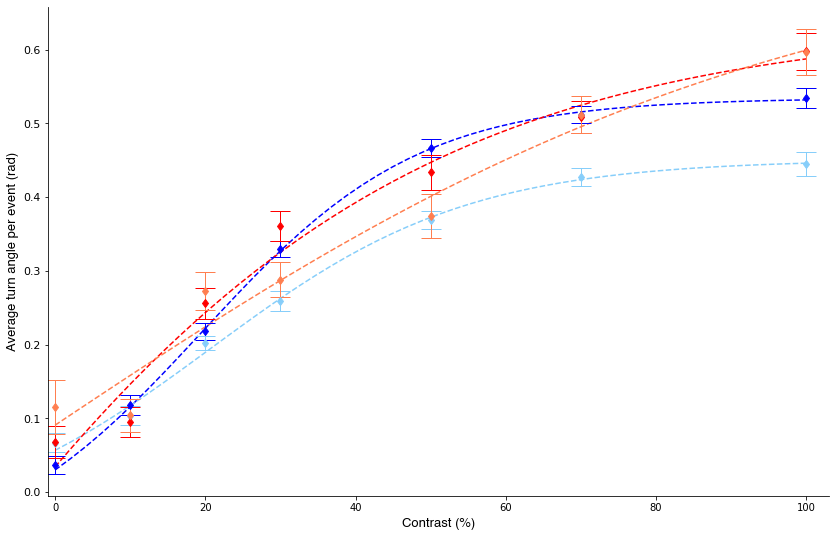

In [121]:
fig, ax = plt.subplots(1,1,figsize=(14,9))

x = [0,10,20,30,50,70,100]

# ax.plot(x,pm_e_delta,ls='--',c='b',marker='d',mfc='b',label='E2 Bath (Afternoon)')
ax.plot(np.linspace(0,100,50),pm_e_delta_fit,'--b',label='Fitted E2 Bath (Afternoon)')
# ax.plot(x,pm_me_delta,ls='--',c='lightskyblue',marker='d',mfc='lightskyblue',label='1mM Methionine (Afternoon)')
ax.plot(np.linspace(0,100,50),pm_me_delta_fit,c='lightskyblue',ls='--',label='Fitted 1mM Methionine (Afternoon)')
     
# ax.plot(x,am_e_delta,ls='--',c='r',marker='d',mfc='r',label='E2 Bath (Morning)')
ax.plot(np.linspace(0,100,50),am_e_delta_fit,'--r',label='Fitted E2 Bath (Morning)')
# ax.plot(x,am_me_delta,ls='--',c='coral',marker='d',mfc='coral',label='1mM Methionine (Morning)')
ax.plot(np.linspace(0,100,50),am_me_delta_fit,c='coral',ls='--',label='Fitted 1mM Methionine (Morning)')


ax.errorbar(x,pm_e_delta,yerr=pm_e_delta_yerr,fmt='d',color='b',capsize=10,elinewidth=1)
ax.errorbar(x,pm_me_delta,yerr=pm_me_delta_yerr,fmt='d',color='lightskyblue',capsize=10,elinewidth=1)

ax.errorbar(x,am_e_delta,yerr=am_e_delta_yerr,fmt='d',color='r',capsize=10,elinewidth=1)
ax.errorbar(x,am_me_delta,yerr=am_me_delta_yerr,fmt='d',color='coral',capsize=10,elinewidth=1)


font = font_manager.FontProperties(family='Helvetica',
                                   style='normal', size=11)
# plt.legend(loc='lower right',prop=font)
plt.title('')
plt.xlabel('Contrast (%)',size=13,name='Helvetica')
plt.ylabel('Average turn angle per event (rad)',size=13,name='Helvetica')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# plt.grid(which='major',axis='y')
# x_ticks = [1, 10, 20, 30, 50, 70, 100]
# x_labels = [1, 10, 20, 30, 50, 70, 100] 
# plt.xticks(ticks=x_ticks, labels=x_labels,fontsize=11)
plt.yticks(fontsize=11)
# ax.set_ylim(0,0.4)
ax.set_xlim(-1,103)
plt.savefig('../../Dissertation/bout_angle_function.png',dpi=400,bbox_inches='tight')
plt.show()

In [122]:
# full_event_table.info()

## Delta_theta_rad OLS and ANOVA

In [123]:
bout_angle_model = ols(formula='delta_theta_rad ~ C(medium, Sum) + C(time, Sum) + C(contrast, Sum) + C(medium, Sum):\
                        C(time, Sum) + C(medium, Sum):C(contrast, Sum) + C(time, Sum):C(contrast, Sum) + \
                        C(medium, Sum):C(time, Sum):C(contrast, Sum)',data=full_event_table).fit()
anova_table_bout = sm.stats.anova_lm(bout_angle_model, typ=3)
anova_table_bout

,sum_sq,df,F,PR(>F)
Intercept,2195.381291,1.0,7922.876896,0.000000e+00
"C(medium, Sum)",4.651603,1.0,16.787096,4.192773e-05
"C(time, Sum)",7.112633,1.0,25.668668,4.077849e-07
"C(contrast, Sum)",638.343840,6.0,383.951502,0.000000e+00
"C(medium, Sum):C(time, Sum)",2.359161,1.0,8.513941,3.527005e-03
"C(medium, Sum):C(contrast, Sum)",8.335249,6.0,5.013491,3.815991e-05
"C(time, Sum):C(contrast, Sum)",8.477873,6.0,5.099277,3.045863e-05
"C(medium, Sum):C(time, Sum):C(contrast, Sum)",1.640856,6.0,0.986943,4.320446e-01
Residual,8218.883788,29661.0,NaN,NaN


In [124]:
am_bout_angle_model = ols(formula='delta_theta_rad ~ C(medium, Sum) + C(contrast, Sum) + \
                        C(medium, Sum):C(contrast, Sum)',data=am_events).fit()
anova_table_bout_am = sm.stats.anova_lm(am_bout_angle_model, typ=3)
anova_table_bout_am

,sum_sq,df,F,PR(>F)
Intercept,842.607666,1.0,2346.312152,0.000000e+00
"C(medium, Sum)",0.132415,1.0,0.368721,5.437192e-01
"C(contrast, Sum)",245.025901,6.0,113.715883,2.187756e-138
"C(medium, Sum):C(contrast, Sum)",3.110288,6.0,1.443477,1.937192e-01
Residual,2967.408722,8263.0,NaN,NaN


In [125]:
pm_bout_angle_model = ols(formula='delta_theta_rad ~ C(medium, Sum) + C(contrast, Sum) + \
                        C(medium, Sum):C(contrast, Sum)',data=pm_events).fit()
anova_table_bout_pm = sm.stats.anova_lm(pm_bout_angle_model, typ=3)
anova_table_bout_pm

,sum_sq,df,F,PR(>F)
Intercept,1792.182238,1.0,7302.541676,0.000000e+00
"C(medium, Sum)",12.516008,1.0,50.998537,9.539463e-13
"C(contrast, Sum)",538.961668,6.0,366.014679,0.000000e+00
"C(medium, Sum):C(contrast, Sum)",10.342563,6.0,7.023746,1.753071e-07
Residual,5251.475066,21398.0,NaN,NaN


In [280]:
pg.anova(data=full_event_table,dv='delta_theta_rad',between='time')

,Source,ddof1,ddof2,F,p-unc,np2
0,time,1,29687,26.633686,2.475003e-07,0.000896


In [126]:
pg.welch_anova(data=am_events,dv='delta_theta_rad',between='medium')

,Source,ddof1,ddof2,F,p-unc,np2
0,medium,1,7231.991681,0.160019,0.689151,0.00002


In [127]:
pg.pairwise_gameshowell(data=am_events,dv='delta_theta_rad',between='medium')

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,e,me,0.351204,0.345588,0.005616,0.014039,0.400023,7231.991681,0.689151,0.008904


In [128]:
pg.welch_anova(data=pm_events,dv='delta_theta_rad',between='medium')

,Source,ddof1,ddof2,F,p-unc,np2
0,medium,1,21361.271109,64.301242,1.122289e-15,0.002987


In [129]:
pg.pairwise_gameshowell(data=pm_events,dv='delta_theta_rad',between='medium')

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,e,me,0.339362,0.282303,0.057059,0.007116,8.018806,21361.271109,0.0,0.109681


## Making Fish Lists 

In [130]:
fish_list_df_names = ['am_e_1','am_e_10','am_e_20','am_e_30','am_e_50','am_e_70','am_e_100',\
                      'pm_e_1','pm_e_10','pm_e_20','pm_e_30','pm_e_50','pm_e_70','pm_e_100',\
                      'am_me_1','am_me_10','am_me_20','am_me_30','am_me_50','am_me_70','am_me_100',\
                      'pm_me_1','pm_me_10','pm_me_20','pm_me_30','pm_me_50','pm_me_70','pm_me_100']

In [131]:
fish_list_dataframes = [am_e_C1_events,am_e_C10_events,am_e_C20_events,am_e_C30_events,am_e_C50_events,\
                        am_e_C70_events,am_e_C100_events,\
                        pm_e_C1_events,pm_e_C10_events,pm_e_C20_events,pm_e_C30_events,pm_e_C50_events,\
                        pm_e_C70_events,pm_e_C100_events,\
                        am_me_C1_events,am_me_C10_events,am_me_C20_events,am_me_C30_events,am_me_C50_events,\
                        am_me_C70_events,am_me_C100_events,\
                        pm_me_C1_events,pm_me_C10_events,pm_me_C20_events,pm_me_C30_events,pm_me_C50_events,\
                        pm_me_C70_events,pm_me_C100_events]

In [ ]:
full_fish_list = pd.DataFrame(columns=['fish_n','bouts_Hz','duration_avg','duration_sem','latency_avg',\
                                      'latency_sem','distance_avg','distance_sem','total_distance','time',\
                                       'medium','contrast'])

for name,df in zip(fish_list_df_names,fish_list_dataframes):
    fish_list = make_fish_list(df)
    fish_list['time'] = name.split('_')[0]
    fish_list['medium'] = name.split('_')[1]
    fish_list['contrast'] = int(name.split('_')[2])
#     fish_counter += 1
    full_fish_list = pd.concat([full_fish_list,fish_list])
        
full_fish_list['fish_n'] = np.arange(1,len(full_fish_list)+1,1)
full_fish_list = full_fish_list.set_index('fish_n')

full_fish_list

In [ ]:
full_fish_list.to_csv('../raw_data/full_fish_list.csv')

In [ ]:
full_fish_list.info()

In [ ]:
full_fish_list['bouts_Hz'] = pd.to_numeric(full_fish_list['bouts_Hz'])

In [ ]:
full_fish_list['latency_avg'] = pd.to_numeric(full_fish_list['latency_avg'])

In [132]:
full_fish_list = pd.read_csv('../raw_data/full_fish_list.csv')

In [133]:
full_fish_list

,fish_n,bouts_Hz,duration_avg,duration_sem,latency_avg,latency_sem,distance_avg,distance_sem,total_distance,time,medium,contrast
0,1,0.033333,0.320000,NaN,NaN,NaN,15.474832,NaN,15.474832,am,e,1
1,2,0.833333,0.414000,0.015177,0.780417,0.073429,46.610230,2.788811,1165.255739,am,e,1
2,3,0.233333,0.468571,0.011218,3.553333,1.129657,50.007648,10.318067,350.053537,am,e,1
3,4,0.033333,0.340000,NaN,NaN,NaN,17.218222,NaN,17.218222,am,e,1
4,5,0.433333,0.481538,0.004507,1.705000,0.338028,55.754021,3.675881,724.802274,am,e,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1778,1779,0.533333,0.420000,0.024307,1.053333,0.195128,69.802288,18.379484,1116.836614,pm,me,100
1779,1780,0.500000,0.373333,0.023516,1.085000,0.396641,44.231604,5.079191,663.474067,pm,me,100
1780,1781,0.566667,0.431176,0.013253,0.836250,0.102798,71.526554,13.442888,1215.951418,pm,me,100
1781,1782,0.500000,0.456667,0.009394,1.540714,0.436584,61.259647,14.397459,918.894703,pm,me,100


## Bout Frequency OLS and ANOVA

In [134]:
bout_freq_model = ols(formula='bouts_Hz ~ C(medium, Sum) + C(time, Sum) + C(contrast, Sum) + C(medium, Sum):\
                        C(time, Sum) + C(medium, Sum):C(contrast, Sum) + C(time, Sum):C(contrast, Sum) + \
                        C(medium, Sum):C(time, Sum):C(contrast, Sum)',data=full_fish_list).fit()
anova_table_bout = sm.stats.anova_lm(bout_freq_model, typ=3)
anova_table_bout

,sum_sq,df,F,PR(>F)
Intercept,451.897669,1.0,5846.773373,0.000000e+00
"C(medium, Sum)",1.771026,1.0,22.914011,1.836196e-06
"C(time, Sum)",20.003744,1.0,258.813810,1.994436e-54
"C(contrast, Sum)",1.994085,6.0,4.300001,2.596263e-04
"C(medium, Sum):C(time, Sum)",0.037290,1.0,0.482472,4.873965e-01
"C(medium, Sum):C(contrast, Sum)",0.370733,6.0,0.799441,5.702891e-01
"C(time, Sum):C(contrast, Sum)",0.368421,6.0,0.794455,5.741973e-01
"C(medium, Sum):C(time, Sum):C(contrast, Sum)",0.250464,6.0,0.540095,7.780127e-01
Residual,135.644117,1755.0,NaN,NaN


In [135]:
am_fish_list = full_fish_list[full_fish_list['time'] == 'am']
pm_fish_list = full_fish_list[full_fish_list['time'] == 'pm']

In [136]:
am_bout_freq_model = ols(formula='bouts_Hz ~ C(medium, Sum) + C(contrast, Sum) + \
                        C(medium, Sum):C(contrast, Sum)',data=am_fish_list).fit()
anova_table_bout_am = sm.stats.anova_lm(am_bout_freq_model, typ=3)
anova_table_bout_am

,sum_sq,df,F,PR(>F)
Intercept,111.744247,1.0,1685.106166,2.676568e-182
"C(medium, Sum)",0.921047,1.0,13.889413,2.108506e-04
"C(contrast, Sum)",1.089241,6.0,2.737630,1.237235e-02
"C(medium, Sum):C(contrast, Sum)",0.222777,6.0,0.559915,7.623435e-01
Residual,42.904435,647.0,NaN,NaN


In [137]:
pm_bout_freq_model = ols(formula='bouts_Hz ~ C(medium, Sum) + C(contrast, Sum) + \
                        C(medium, Sum):C(contrast, Sum)',data=pm_fish_list).fit()
anova_table_bout_pm = sm.stats.anova_lm(pm_bout_freq_model, typ=3)
anova_table_bout_pm

,sum_sq,df,F,PR(>F)
Intercept,447.745813,1.0,5349.407635,0.000000
"C(medium, Sum)",0.875360,1.0,10.458291,0.001257
"C(contrast, Sum)",1.360307,6.0,2.708694,0.012904
"C(medium, Sum):C(contrast, Sum)",0.463297,6.0,0.922535,0.477671
Residual,92.739682,1108.0,NaN,NaN


In [279]:
pg.anova(data=full_fish_list,dv='bouts_Hz',between='time')

,Source,ddof1,ddof2,F,p-unc,np2
0,time,1,1781,252.200967,3.233828e-53,0.124041


In [138]:
pg.welch_anova(data=am_fish_list,dv='bouts_Hz',between='medium')

,Source,ddof1,ddof2,F,p-unc,np2
0,medium,1,653.247556,12.871653,0.000359,0.019027


In [139]:
pg.welch_anova(data=pm_fish_list,dv='bouts_Hz',between='medium')

,Source,ddof1,ddof2,F,p-unc,np2
0,medium,1,1119.965749,10.687741,0.001111,0.009452


In [140]:
am_e_fish_list = am_fish_list[am_fish_list['medium'] == 'e']
am_me_fish_list = am_fish_list[am_fish_list['medium'] == 'me']

pm_e_fish_list = pm_fish_list[pm_fish_list['medium'] == 'e']
pm_me_fish_list = pm_fish_list[pm_fish_list['medium'] == 'me']

In [141]:
am_e_1_fish_list = am_e_fish_list[am_e_fish_list['contrast'] == 1]
am_e_10_fish_list = am_e_fish_list[am_e_fish_list['contrast'] == 10]
am_e_20_fish_list = am_e_fish_list[am_e_fish_list['contrast'] == 20]
am_e_30_fish_list = am_e_fish_list[am_e_fish_list['contrast'] == 30]
am_e_50_fish_list = am_e_fish_list[am_e_fish_list['contrast'] == 50]
am_e_70_fish_list = am_e_fish_list[am_e_fish_list['contrast'] == 70]
am_e_100_fish_list = am_e_fish_list[am_e_fish_list['contrast'] == 100]

In [142]:
am_me_1_fish_list = am_me_fish_list[am_me_fish_list['contrast'] == 1]
am_me_10_fish_list = am_me_fish_list[am_me_fish_list['contrast'] == 10]
am_me_20_fish_list = am_me_fish_list[am_me_fish_list['contrast'] == 20]
am_me_30_fish_list = am_me_fish_list[am_me_fish_list['contrast'] == 30]
am_me_50_fish_list = am_me_fish_list[am_me_fish_list['contrast'] == 50]
am_me_70_fish_list = am_me_fish_list[am_me_fish_list['contrast'] == 70]
am_me_100_fish_list = am_me_fish_list[am_me_fish_list['contrast'] == 100]

In [143]:
pm_e_1_fish_list = pm_e_fish_list[pm_e_fish_list['contrast'] == 1]
pm_e_10_fish_list = pm_e_fish_list[pm_e_fish_list['contrast'] == 10]
pm_e_20_fish_list = pm_e_fish_list[pm_e_fish_list['contrast'] == 20]
pm_e_30_fish_list = pm_e_fish_list[pm_e_fish_list['contrast'] == 30]
pm_e_50_fish_list = pm_e_fish_list[pm_e_fish_list['contrast'] == 50]
pm_e_70_fish_list = pm_e_fish_list[pm_e_fish_list['contrast'] == 70]
pm_e_100_fish_list = pm_e_fish_list[pm_e_fish_list['contrast'] == 100]

In [144]:
pm_me_1_fish_list = pm_me_fish_list[pm_me_fish_list['contrast'] == 1]
pm_me_10_fish_list = pm_me_fish_list[pm_me_fish_list['contrast'] == 10]
pm_me_20_fish_list = pm_me_fish_list[pm_me_fish_list['contrast'] == 20]
pm_me_30_fish_list = pm_me_fish_list[pm_me_fish_list['contrast'] == 30]
pm_me_50_fish_list = pm_me_fish_list[pm_me_fish_list['contrast'] == 50]
pm_me_70_fish_list = pm_me_fish_list[pm_me_fish_list['contrast'] == 70]
pm_me_100_fish_list = pm_me_fish_list[pm_me_fish_list['contrast'] == 100]

(array([2.16247808, 0.46756283, 1.16890707, 0.8766803 , 1.98714202,
        0.81823495, 1.69491525, 0.70134424, 1.46113384, 0.64289889,
        0.93512566, 1.51957919, 0.81823495, 1.05201636, 0.8766803 ,
        1.46113384, 0.58445354, 0.7597896 , 0.46756283, 0.23378141]),
 array([0.03333333, 0.08166667, 0.13      , 0.17833333, 0.22666667,
        0.275     , 0.32333333, 0.37166667, 0.42      , 0.46833333,
        0.51666667, 0.565     , 0.61333333, 0.66166667, 0.71      ,
        0.75833333, 0.80666667, 0.855     , 0.90333333, 0.95166667,
        1.        ]),
 <BarContainer object of 20 artists>)

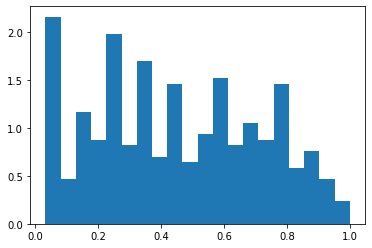

In [145]:
plt.hist(am_e_fish_list['bouts_Hz'],density=True,bins=20)

(array([2.52180309, 2.08048755, 0.88263108, 2.08048755, 0.50436062,
        1.45003678, 1.13481139, 1.32394662, 0.819586  , 1.70221709,
        1.45003678, 0.37827046, 0.69349585, 0.37827046, 0.88263108,
        0.18913523, 0.31522539, 0.25218031, 0.25218031, 0.06304508]),
 array([0.03333333, 0.085     , 0.13666667, 0.18833333, 0.24      ,
        0.29166667, 0.34333333, 0.395     , 0.44666667, 0.49833333,
        0.55      , 0.60166667, 0.65333333, 0.705     , 0.75666667,
        0.80833333, 0.86      , 0.91166667, 0.96333333, 1.015     ,
        1.06666667]),
 <BarContainer object of 20 artists>)

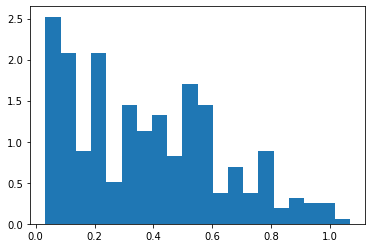

In [146]:
plt.hist(am_me_fish_list['bouts_Hz'],density=True,bins=20)

(array([0.53763441, 0.58007923, 0.56593096, 0.84889643, 1.01867572,
        1.14601019, 1.65534805, 1.11771364, 0.36785512, 0.0565931 ]),
 array([0.03333333, 0.16      , 0.28666667, 0.41333333, 0.54      ,
        0.66666667, 0.79333333, 0.92      , 1.04666667, 1.17333333,
        1.3       ]),
 <BarContainer object of 10 artists>)

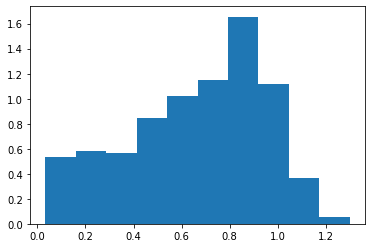

In [147]:
plt.hist(pm_e_fish_list['bouts_Hz'],density=True)

(array([0.74468085, 0.48632219, 0.82066869, 0.71428571, 1.35258359,
        1.00303951, 1.45896657, 0.9118541 , 0.85106383, 0.22796353]),
 array([0.03333333, 0.15      , 0.26666667, 0.38333333, 0.5       ,
        0.61666667, 0.73333333, 0.85      , 0.96666667, 1.08333333,
        1.2       ]),
 <BarContainer object of 10 artists>)

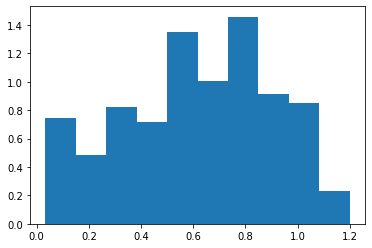

In [148]:
plt.hist(pm_me_fish_list['bouts_Hz'],density=True)

## Bout Frequency Mean and SEM Calculations

In [149]:
am_e_bout_hz = [am_e_1_fish_list['bouts_Hz'].mean(),am_e_10_fish_list['bouts_Hz'].mean(),\
               am_e_20_fish_list['bouts_Hz'].mean(),am_e_30_fish_list['bouts_Hz'].mean(),\
               am_e_50_fish_list['bouts_Hz'].mean(),am_e_70_fish_list['bouts_Hz'].mean(),\
               am_e_100_fish_list['bouts_Hz'].mean()]
am_me_bout_hz = [am_me_1_fish_list['bouts_Hz'].mean(),am_me_10_fish_list['bouts_Hz'].mean(),\
               am_me_20_fish_list['bouts_Hz'].mean(),am_me_30_fish_list['bouts_Hz'].mean(),\
               am_me_50_fish_list['bouts_Hz'].mean(),am_me_70_fish_list['bouts_Hz'].mean(),\
               am_me_100_fish_list['bouts_Hz'].mean()]
pm_e_bout_hz = [pm_e_1_fish_list['bouts_Hz'].mean(),pm_e_10_fish_list['bouts_Hz'].mean(),\
               pm_e_20_fish_list['bouts_Hz'].mean(),pm_e_30_fish_list['bouts_Hz'].mean(),\
               pm_e_50_fish_list['bouts_Hz'].mean(),pm_e_70_fish_list['bouts_Hz'].mean(),\
               pm_e_100_fish_list['bouts_Hz'].mean()]
pm_me_bout_hz = [pm_me_1_fish_list['bouts_Hz'].mean(),pm_me_10_fish_list['bouts_Hz'].mean(),\
               pm_me_20_fish_list['bouts_Hz'].mean(),pm_me_30_fish_list['bouts_Hz'].mean(),\
               pm_me_50_fish_list['bouts_Hz'].mean(),pm_me_70_fish_list['bouts_Hz'].mean(),\
               pm_me_100_fish_list['bouts_Hz'].mean()]

In [150]:
am_e_1_bout_hz_sem = stats.sem(am_e_1_fish_list['bouts_Hz'])
am_e_10_bout_hz_sem = stats.sem(am_e_10_fish_list['bouts_Hz'])
am_e_20_bout_hz_sem = stats.sem(am_e_20_fish_list['bouts_Hz'])
am_e_30_bout_hz_sem = stats.sem(am_e_30_fish_list['bouts_Hz'])
am_e_50_bout_hz_sem = stats.sem(am_e_50_fish_list['bouts_Hz'])
am_e_70_bout_hz_sem = stats.sem(am_e_70_fish_list['bouts_Hz'])
am_e_100_bout_hz_sem = stats.sem(am_e_100_fish_list['bouts_Hz'])

In [151]:
am_me_1_bout_hz_sem = stats.sem(am_me_1_fish_list['bouts_Hz'])
am_me_10_bout_hz_sem = stats.sem(am_me_10_fish_list['bouts_Hz'])
am_me_20_bout_hz_sem = stats.sem(am_me_20_fish_list['bouts_Hz'])
am_me_30_bout_hz_sem = stats.sem(am_me_30_fish_list['bouts_Hz'])
am_me_50_bout_hz_sem = stats.sem(am_me_50_fish_list['bouts_Hz'])
am_me_70_bout_hz_sem = stats.sem(am_me_70_fish_list['bouts_Hz'])
am_me_100_bout_hz_sem = stats.sem(am_me_100_fish_list['bouts_Hz'])

In [152]:
pm_e_1_bout_hz_sem = stats.sem(pm_e_1_fish_list['bouts_Hz'])
pm_e_10_bout_hz_sem = stats.sem(pm_e_10_fish_list['bouts_Hz'])
pm_e_20_bout_hz_sem = stats.sem(pm_e_20_fish_list['bouts_Hz'])
pm_e_30_bout_hz_sem = stats.sem(pm_e_30_fish_list['bouts_Hz'])
pm_e_50_bout_hz_sem = stats.sem(pm_e_50_fish_list['bouts_Hz'])
pm_e_70_bout_hz_sem = stats.sem(pm_e_70_fish_list['bouts_Hz'])
pm_e_100_bout_hz_sem = stats.sem(pm_e_100_fish_list['bouts_Hz'])

In [153]:
pm_me_1_bout_hz_sem = stats.sem(pm_me_1_fish_list['bouts_Hz'])
pm_me_10_bout_hz_sem = stats.sem(pm_me_10_fish_list['bouts_Hz'])
pm_me_20_bout_hz_sem = stats.sem(pm_me_20_fish_list['bouts_Hz'])
pm_me_30_bout_hz_sem = stats.sem(pm_me_30_fish_list['bouts_Hz'])
pm_me_50_bout_hz_sem = stats.sem(pm_me_50_fish_list['bouts_Hz'])
pm_me_70_bout_hz_sem = stats.sem(pm_me_70_fish_list['bouts_Hz'])
pm_me_100_bout_hz_sem = stats.sem(pm_me_100_fish_list['bouts_Hz'])

In [154]:
am_e_bout_hz_yerr = [am_e_1_bout_hz_sem,am_e_10_bout_hz_sem,am_e_20_bout_hz_sem,am_e_30_bout_hz_sem,\
                     am_e_50_bout_hz_sem,am_e_70_bout_hz_sem,am_e_100_bout_hz_sem]
am_me_bout_hz_yerr = [am_me_1_bout_hz_sem,am_me_10_bout_hz_sem,am_me_20_bout_hz_sem,am_me_30_bout_hz_sem,\
                      am_me_50_bout_hz_sem,am_me_70_bout_hz_sem,am_me_100_bout_hz_sem]

pm_e_bout_hz_yerr = [pm_e_1_bout_hz_sem,pm_e_10_bout_hz_sem,pm_e_20_bout_hz_sem,pm_e_30_bout_hz_sem,\
                     pm_e_50_bout_hz_sem,pm_e_70_bout_hz_sem,pm_e_100_bout_hz_sem]
pm_me_bout_hz_yerr = [pm_me_1_bout_hz_sem,pm_me_10_bout_hz_sem,pm_me_20_bout_hz_sem,pm_me_30_bout_hz_sem,\
                      pm_me_50_bout_hz_sem,pm_me_70_bout_hz_sem,pm_me_100_bout_hz_sem]

## Fitting a Straight Line Functions

In [155]:
def straight_line(x, A, B): # this is your 'straight line' y=f(x)
    return np.multiply(A,x) + B

# popt, pcov = curve_fit(f, x, y) # your data x, y to fit

def fit_straight_line(ydata):
    xdata = [1,10,20,30,50,70,100]
#     p0 = [max(ydata), np.median(xdata),1,min(ydata)] # this is an mandatory initial guess
    popt, pcov = curve_fit(straight_line, xdata, ydata)
    y = straight_line(xdata, popt[0],popt[1])
    new_x = np.linspace(0,100,50)
    new_y = straight_line(new_x, popt[0],popt[1])
    return new_y

In [278]:
popt, pcov = curve_fit(straight_line, [1,10,20,30,50,70,100], am_me_bout_hz)
popt

array([0.00075089, 0.34595131])

In [156]:
am_e_bout_hz_fit = fit_straight_line(am_e_bout_hz)
am_me_bout_hz_fit = fit_straight_line(am_me_bout_hz)
pm_e_bout_hz_fit = fit_straight_line(pm_e_bout_hz)
pm_me_bout_hz_fit = fit_straight_line(pm_me_bout_hz)

## Bout Frequency Plot

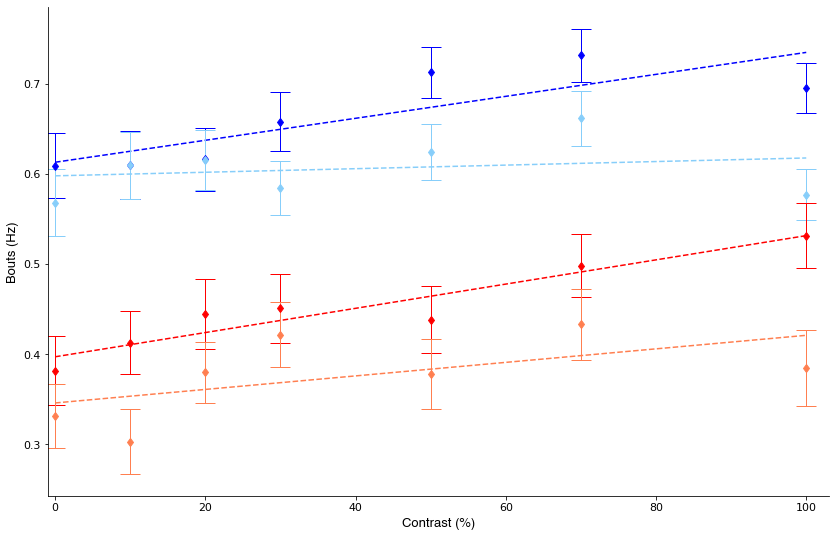

In [158]:
fig, ax = plt.subplots(1,1,figsize=(14,9))

x = [0,10,20,30,50,70,100]

# ax.plot(x,pm_e_bout_hz,c='b',marker='d',mfc='b',label='E2 Bath (Afternoon)')
ax.plot(np.linspace(0,100,50),pm_e_bout_hz_fit,'--b',label='Fitted E2 Bath (Afternoon)')
# ax.plot(x,pm_me_bout_hz,c='lightskyblue',marker='d',mfc='lightskyblue',label='1mM Methionine (Afternoon)')
ax.plot(np.linspace(0,100,50),pm_me_bout_hz_fit,c='lightskyblue',ls='--',label='Fitted 1mM Methionine (Afternoon)')
     
# ax.plot(x,am_e_bout_hz,c='r',marker='d',mfc='r',label='E2 Bath (Morning)')
ax.plot(np.linspace(0,100,50),am_e_bout_hz_fit,'--r',label='Fitted E2 Bath (Morning)')
# ax.plot(x,am_me_bout_hz,c='coral',marker='d',mfc='coral',label='1mM Methionine (Morning)')
ax.plot(np.linspace(0,100,50),am_me_bout_hz_fit,c='coral',ls='--',label='Fitted 1mM Methionine (Morning)')


ax.errorbar(x,pm_e_bout_hz,yerr=pm_e_bout_hz_yerr,fmt='d',color='b',capsize=10,elinewidth=1)
ax.errorbar(x,pm_me_bout_hz,yerr=pm_me_bout_hz_yerr,fmt='d',color='lightskyblue',capsize=10,elinewidth=1)

ax.errorbar(x,am_e_bout_hz,yerr=am_e_bout_hz_yerr,fmt='d',color='r',capsize=10,elinewidth=1)
ax.errorbar(x,am_me_bout_hz,yerr=am_me_bout_hz_yerr,fmt='d',color='coral',capsize=10,elinewidth=1)


font = font_manager.FontProperties(family='Helvetica',
                                   style='normal', size=11)
# plt.legend(loc='lower right',prop=font)
plt.title('')
plt.xlabel('Contrast (%)',size=13,name='Helvetica')
plt.ylabel('Bouts (Hz)',size=13,name='Helvetica')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# plt.grid(which='major',axis='y')
# x_ticks = [1, 10, 20, 30, 50, 70, 100]
# x_labels = [1, 10, 20, 30, 50, 70, 100] 
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
# ax.set_ylim(0,0.5)
ax.set_xlim(-1,103)
plt.savefig('../../Dissertation/bout_freq_function.png',dpi=400,bbox_inches='tight')
plt.show()

## Turn angle and bout frequency plot (in one)

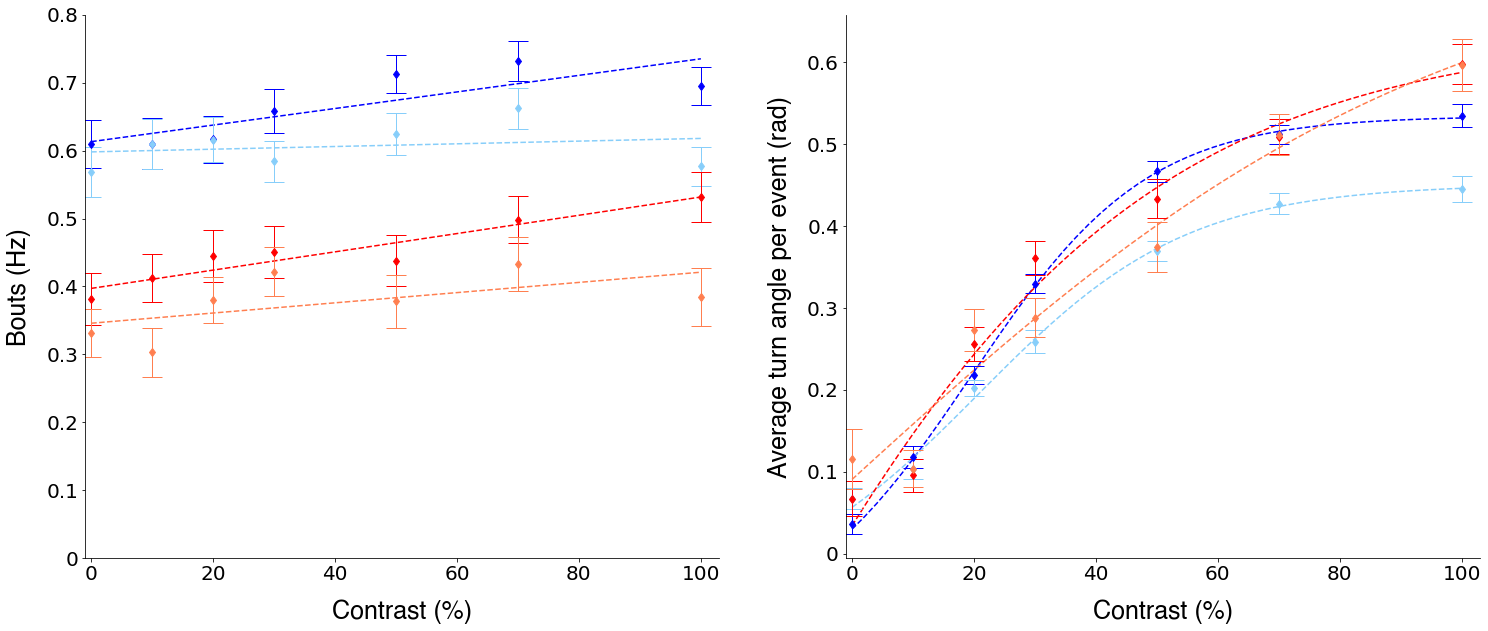

In [274]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(25,10))

x = [0,10,20,30,50,70,100]
x_ticks = [0,20,40,60,80,100]
x_labels = [0,20,40,60,80,100] 

y_ticks_1 = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8]
y_labels_1 = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8]

y_ticks_2 = [0,0.1,0.2,0.3,0.4,0.5,0.6]
y_labels_2 = [0,0.1,0.2,0.3,0.4,0.5,0.6]

ax1.plot(np.linspace(0,100,50),pm_e_bout_hz_fit,'--b',label='Fitted E2 Bath (Afternoon)')
ax1.plot(np.linspace(0,100,50),pm_me_bout_hz_fit,c='lightskyblue',ls='--',label='Fitted 1mM Methionine (Afternoon)')
ax1.plot(np.linspace(0,100,50),am_e_bout_hz_fit,'--r',label='Fitted E2 Bath (Morning)')
ax1.plot(np.linspace(0,100,50),am_me_bout_hz_fit,c='coral',ls='--',label='Fitted 1mM Methionine (Morning)')
ax1.errorbar(x,pm_e_bout_hz,yerr=pm_e_bout_hz_yerr,fmt='d',color='b',capsize=10,elinewidth=1)
ax1.errorbar(x,pm_me_bout_hz,yerr=pm_me_bout_hz_yerr,fmt='d',color='lightskyblue',capsize=10,elinewidth=1)

ax1.errorbar(x,am_e_bout_hz,yerr=am_e_bout_hz_yerr,fmt='d',color='r',capsize=10,elinewidth=1)
ax1.errorbar(x,am_me_bout_hz,yerr=am_me_bout_hz_yerr,fmt='d',color='coral',capsize=10,elinewidth=1)
ax1.set_xlabel('Contrast (%)',size=25,name='Helvetica',labelpad=15)
ax1.set_ylabel('Bouts (Hz)',size=25,name='Helvetica',labelpad=15)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_xticks(x_ticks,x_labels,fontsize=20)
ax1.set_yticks(y_ticks_1,y_labels_1,fontsize=20)
ax1.set_xlim(-1,103)


ax2.plot(np.linspace(0,100,50),pm_e_delta_fit,'--b',label='Fitted E2 Bath (Afternoon)')
ax2.plot(np.linspace(0,100,50),pm_me_delta_fit,c='lightskyblue',ls='--',label='Fitted 1mM Methionine (Afternoon)')
ax2.plot(np.linspace(0,100,50),am_e_delta_fit,'--r',label='Fitted E2 Bath (Morning)')
ax2.plot(np.linspace(0,100,50),am_me_delta_fit,c='coral',ls='--',label='Fitted 1mM Methionine (Morning)')
ax2.errorbar(x,pm_e_delta,yerr=pm_e_delta_yerr,fmt='d',color='b',capsize=10,elinewidth=1)
ax2.errorbar(x,pm_me_delta,yerr=pm_me_delta_yerr,fmt='d',color='lightskyblue',capsize=10,elinewidth=1)

ax2.errorbar(x,am_e_delta,yerr=am_e_delta_yerr,fmt='d',color='r',capsize=10,elinewidth=1)
ax2.errorbar(x,am_me_delta,yerr=am_me_delta_yerr,fmt='d',color='coral',capsize=10,elinewidth=1)
ax2.set_xlabel('Contrast (%)',size=25,name='Helvetica',labelpad=15)
ax2.set_ylabel('Average turn angle per event (rad)',size=25,name='Helvetica',labelpad=15)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.set_xticks(x_ticks,x_labels,fontsize=20)
ax2.set_yticks(y_ticks_2,y_labels_2,fontsize=20)
ax2.set_xlim(-1,103)

plt.savefig('../../Dissertation/delta_theta_and_bout_freq_function.png',dpi=400,bbox_inches='tight')

plt.show()

## Interbout Interval OLS and ANOVA

In [159]:
full_fish_list

,fish_n,bouts_Hz,duration_avg,duration_sem,latency_avg,latency_sem,distance_avg,distance_sem,total_distance,time,medium,contrast
0,1,0.033333,0.320000,NaN,NaN,NaN,15.474832,NaN,15.474832,am,e,1
1,2,0.833333,0.414000,0.015177,0.780417,0.073429,46.610230,2.788811,1165.255739,am,e,1
2,3,0.233333,0.468571,0.011218,3.553333,1.129657,50.007648,10.318067,350.053537,am,e,1
3,4,0.033333,0.340000,NaN,NaN,NaN,17.218222,NaN,17.218222,am,e,1
4,5,0.433333,0.481538,0.004507,1.705000,0.338028,55.754021,3.675881,724.802274,am,e,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1778,1779,0.533333,0.420000,0.024307,1.053333,0.195128,69.802288,18.379484,1116.836614,pm,me,100
1779,1780,0.500000,0.373333,0.023516,1.085000,0.396641,44.231604,5.079191,663.474067,pm,me,100
1780,1781,0.566667,0.431176,0.013253,0.836250,0.102798,71.526554,13.442888,1215.951418,pm,me,100
1781,1782,0.500000,0.456667,0.009394,1.540714,0.436584,61.259647,14.397459,918.894703,pm,me,100


In [160]:
full_fish_list['latency_avg']=pd.to_numeric(full_fish_list['latency_avg'])

In [161]:
am_fish_list['latency_avg']=pd.to_numeric(am_fish_list['latency_avg'])

/var/folders/wd/4w68b8ld47x6kzpx1zhzn8qm0000gn/T/ipykernel_52759/91959815.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  am_fish_list['latency_avg']=pd.to_numeric(am_fish_list['latency_avg'])


In [162]:
pm_fish_list['latency_avg']=pd.to_numeric(pm_fish_list['latency_avg'])

/var/folders/wd/4w68b8ld47x6kzpx1zhzn8qm0000gn/T/ipykernel_52759/3614410718.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pm_fish_list['latency_avg']=pd.to_numeric(pm_fish_list['latency_avg'])


In [163]:
interbout_model = ols(formula='latency_avg ~ C(medium, Sum) + C(time, Sum) + C(contrast, Sum) + C(medium, Sum):\
                        C(time, Sum) + C(medium, Sum):C(contrast, Sum) + C(time, Sum):C(contrast, Sum) + \
                        C(medium, Sum):C(time, Sum):C(contrast, Sum)',data=full_fish_list).fit()
anova_table_interbout = sm.stats.anova_lm(interbout_model, typ=3)
anova_table_interbout

,sum_sq,df,F,PR(>F)
Intercept,5850.803203,1.0,1190.694071,4.902175e-198
"C(medium, Sum)",60.077075,1.0,12.226256,4.833767e-04
"C(time, Sum)",352.984251,1.0,71.835651,5.010021e-17
"C(contrast, Sum)",23.456371,6.0,0.795599,5.733046e-01
"C(medium, Sum):C(time, Sum)",14.815327,1.0,3.015060,8.267632e-02
"C(medium, Sum):C(contrast, Sum)",54.300504,6.0,1.841778,8.752227e-02
"C(time, Sum):C(contrast, Sum)",59.985753,6.0,2.034612,5.810892e-02
"C(medium, Sum):C(time, Sum):C(contrast, Sum)",46.344902,6.0,1.571938,1.514709e-01
Residual,8319.021710,1693.0,NaN,NaN


In [164]:
am_interbout_model = ols(formula='latency_avg ~ C(medium, Sum) + C(contrast, Sum) + \
                        C(medium, Sum):C(contrast, Sum)',data=am_fish_list).fit()
anova_table_interbout_am = sm.stats.anova_lm(am_interbout_model, typ=3)
anova_table_interbout_am

,sum_sq,df,F,PR(>F)
Intercept,3558.256968,1.0,475.172953,2.431818e-78
"C(medium, Sum)",52.743003,1.0,7.043350,8.163435e-03
"C(contrast, Sum)",46.727066,6.0,1.039996,3.980765e-01
"C(medium, Sum):C(contrast, Sum)",61.796814,6.0,1.375401,2.221547e-01
Residual,4567.887830,610.0,NaN,NaN


In [165]:
pm_interbout_model = ols(formula='latency_avg ~ C(medium, Sum) + C(contrast, Sum) + \
                        C(medium, Sum):C(contrast, Sum)',data=pm_fish_list).fit()
anova_table_interbout_pm = sm.stats.anova_lm(pm_interbout_model, typ=3)
anova_table_interbout_pm

,sum_sq,df,F,PR(>F)
Intercept,2298.244044,1.0,663.532249,1.609561e-114
"C(medium, Sum)",10.508734,1.0,3.034005,8.182044e-02
"C(contrast, Sum)",34.751336,6.0,1.672192,1.244256e-01
"C(medium, Sum):C(contrast, Sum)",27.727382,6.0,1.334208,2.387989e-01
Residual,3751.133880,1083.0,NaN,NaN


In [166]:
pg.welch_anova(data=am_fish_list,dv='latency_avg',between='medium')

,Source,ddof1,ddof2,F,p-unc,np2
0,medium,1,481.542557,6.765072,0.009582,0.011395


In [167]:
pg.welch_anova(data=pm_fish_list,dv='latency_avg',between='medium')

,Source,ddof1,ddof2,F,p-unc,np2
0,medium,1,938.080299,3.373845,0.066555,0.003069


## Interbout Intervals Mean & SEM Calculations

In [168]:
am_e_interbout = [am_e_1_fish_list['latency_avg'].mean(),am_e_10_fish_list['latency_avg'].mean(),\
               am_e_20_fish_list['latency_avg'].mean(),am_e_30_fish_list['latency_avg'].mean(),\
               am_e_50_fish_list['latency_avg'].mean(),am_e_70_fish_list['latency_avg'].mean(),\
               am_e_100_fish_list['latency_avg'].mean()]
am_me_interbout = [am_me_1_fish_list['latency_avg'].mean(),am_me_10_fish_list['latency_avg'].mean(),\
               am_me_20_fish_list['latency_avg'].mean(),am_me_30_fish_list['latency_avg'].mean(),\
               am_me_50_fish_list['latency_avg'].mean(),am_me_70_fish_list['latency_avg'].mean(),\
               am_me_100_fish_list['latency_avg'].mean()]
pm_e_interbout = [pm_e_1_fish_list['latency_avg'].mean(),pm_e_10_fish_list['latency_avg'].mean(),\
               pm_e_20_fish_list['latency_avg'].mean(),pm_e_30_fish_list['latency_avg'].mean(),\
               pm_e_50_fish_list['latency_avg'].mean(),pm_e_70_fish_list['latency_avg'].mean(),\
               pm_e_100_fish_list['latency_avg'].mean()]
pm_me_interbout = [pm_me_1_fish_list['latency_avg'].mean(),pm_me_10_fish_list['latency_avg'].mean(),\
               pm_me_20_fish_list['latency_avg'].mean(),pm_me_30_fish_list['latency_avg'].mean(),\
               pm_me_50_fish_list['latency_avg'].mean(),pm_me_70_fish_list['latency_avg'].mean(),\
               pm_me_100_fish_list['latency_avg'].mean()]

In [169]:
am_e_1_interbout_sem = stats.sem(am_e_1_fish_list['latency_avg'],nan_policy='omit')
am_e_10_interbout_sem = stats.sem(am_e_10_fish_list['latency_avg'],nan_policy='omit')
am_e_20_interbout_sem = stats.sem(am_e_20_fish_list['latency_avg'],nan_policy='omit')
am_e_30_interbout_sem = stats.sem(am_e_30_fish_list['latency_avg'],nan_policy='omit')
am_e_50_interbout_sem = stats.sem(am_e_50_fish_list['latency_avg'],nan_policy='omit')
am_e_70_interbout_sem = stats.sem(am_e_70_fish_list['latency_avg'],nan_policy='omit')
am_e_100_interbout_sem = stats.sem(am_e_100_fish_list['latency_avg'],nan_policy='omit')

In [170]:
am_me_1_interbout_sem = stats.sem(am_me_1_fish_list['latency_avg'],nan_policy='omit')
am_me_10_interbout_sem = stats.sem(am_me_10_fish_list['latency_avg'],nan_policy='omit')
am_me_20_interbout_sem = stats.sem(am_me_20_fish_list['latency_avg'],nan_policy='omit')
am_me_30_interbout_sem = stats.sem(am_me_30_fish_list['latency_avg'],nan_policy='omit')
am_me_50_interbout_sem = stats.sem(am_me_50_fish_list['latency_avg'],nan_policy='omit')
am_me_70_interbout_sem = stats.sem(am_me_70_fish_list['latency_avg'],nan_policy='omit')
am_me_100_interbout_sem = stats.sem(am_me_100_fish_list['latency_avg'],nan_policy='omit')

In [171]:
pm_e_1_interbout_sem = stats.sem(pm_e_1_fish_list['latency_avg'],nan_policy='omit')
pm_e_10_interbout_sem = stats.sem(pm_e_10_fish_list['latency_avg'],nan_policy='omit')
pm_e_20_interbout_sem = stats.sem(pm_e_20_fish_list['latency_avg'],nan_policy='omit')
pm_e_30_interbout_sem = stats.sem(pm_e_30_fish_list['latency_avg'],nan_policy='omit')
pm_e_50_interbout_sem = stats.sem(pm_e_50_fish_list['latency_avg'],nan_policy='omit')
pm_e_70_interbout_sem = stats.sem(pm_e_70_fish_list['latency_avg'],nan_policy='omit')
pm_e_100_interbout_sem = stats.sem(pm_e_100_fish_list['latency_avg'],nan_policy='omit')

In [172]:
pm_me_1_interbout_sem = stats.sem(pm_me_1_fish_list['latency_avg'],nan_policy='omit')
pm_me_10_interbout_sem = stats.sem(pm_me_10_fish_list['latency_avg'],nan_policy='omit')
pm_me_20_interbout_sem = stats.sem(pm_me_20_fish_list['latency_avg'],nan_policy='omit')
pm_me_30_interbout_sem = stats.sem(pm_me_30_fish_list['latency_avg'],nan_policy='omit')
pm_me_50_interbout_sem = stats.sem(pm_me_50_fish_list['latency_avg'],nan_policy='omit')
pm_me_70_interbout_sem = stats.sem(pm_me_70_fish_list['latency_avg'],nan_policy='omit')
pm_me_100_interbout_sem = stats.sem(pm_me_100_fish_list['latency_avg'],nan_policy='omit')

In [173]:
am_e_interbout_yerr = [am_e_1_interbout_sem,am_e_10_interbout_sem,am_e_20_interbout_sem,am_e_30_interbout_sem,\
                     am_e_50_interbout_sem,am_e_70_interbout_sem,am_e_100_interbout_sem]
am_me_interbout_yerr = [am_me_1_interbout_sem,am_me_10_interbout_sem,am_me_20_interbout_sem,am_me_30_interbout_sem,\
                      am_me_50_interbout_sem,am_me_70_interbout_sem,am_me_100_interbout_sem]

pm_e_interbout_yerr = [pm_e_1_interbout_sem,pm_e_10_interbout_sem,pm_e_20_interbout_sem,pm_e_30_interbout_sem,\
                     pm_e_50_interbout_sem,pm_e_70_interbout_sem,pm_e_100_interbout_sem]
pm_me_interbout_yerr = [pm_me_1_interbout_sem,pm_me_10_interbout_sem,pm_me_20_interbout_sem,pm_me_30_interbout_sem,\
                      pm_me_50_interbout_sem,pm_me_70_interbout_sem,pm_me_100_interbout_sem]

In [174]:
am_e_interbout_fit = fit_straight_line(am_e_interbout)
am_me_interbout_fit = fit_straight_line(am_me_interbout)
pm_e_interbout_fit = fit_straight_line(pm_e_interbout)
pm_me_interbout_fit = fit_straight_line(pm_me_interbout)

## Interbout Interval Plot

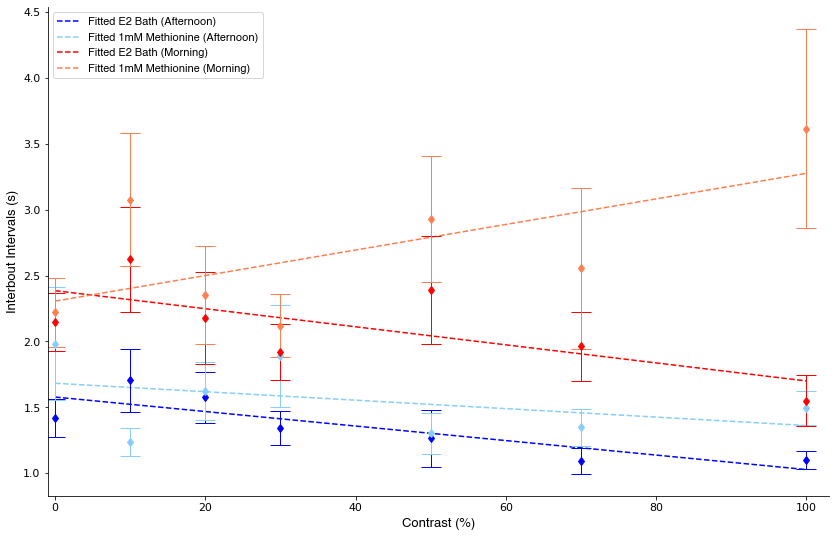

In [175]:
fig, ax = plt.subplots(1,1,figsize=(14,9))

x = [0,10,20,30,50,70,100]

# ax.plot(x,pm_e_interbout,c='b',marker='d',mfc='b',label='E2 Bath (Afternoon)')
ax.plot(np.linspace(0,100,50),pm_e_interbout_fit,'--b',label='Fitted E2 Bath (Afternoon)')
# ax.plot(x,pm_me_interbout,c='lightskyblue',marker='d',mfc='lightskyblue',label='1mM Methionine (Afternoon)')
ax.plot(np.linspace(0,100,50),pm_me_interbout_fit,c='lightskyblue',ls='--',label='Fitted 1mM Methionine (Afternoon)')
     
# ax.plot(x,am_e_interbout,c='r',marker='d',mfc='r',label='E2 Bath (Morning)')
ax.plot(np.linspace(0,100,50),am_e_interbout_fit,'--r',label='Fitted E2 Bath (Morning)')
# ax.plot(x,am_me_interbout,c='coral',marker='d',mfc='coral',label='1mM Methionine (Morning)')
ax.plot(np.linspace(0,100,50),am_me_interbout_fit,c='coral',ls='--',label='Fitted 1mM Methionine (Morning)')


ax.errorbar(x,pm_e_interbout,yerr=pm_e_interbout_yerr,fmt='d',color='b',capsize=10,elinewidth=1)
ax.errorbar(x,pm_me_interbout,yerr=pm_me_interbout_yerr,fmt='d',color='lightskyblue',capsize=10,elinewidth=1)

ax.errorbar(x,am_e_interbout,yerr=am_e_interbout_yerr,fmt='d',color='r',capsize=10,elinewidth=1)
ax.errorbar(x,am_me_interbout,yerr=am_me_interbout_yerr,fmt='d',color='coral',capsize=10,elinewidth=1)


font = font_manager.FontProperties(family='Helvetica',
                                   style='normal', size=11)
plt.legend(loc='upper left',prop=font)
plt.title('')
plt.xlabel('Contrast (%)',size=13,name='Helvetica')
plt.ylabel('Interbout Intervals (s)',size=13,name='Helvetica')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# plt.grid(which='major',axis='y')
# x_ticks = [1, 10, 20, 30, 50, 70, 100]
# x_labels = [1, 10, 20, 30, 50, 70, 100] 
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
# ax.set_ylim(0,4)
ax.set_xlim(-1,103)
plt.savefig('../../Dissertation/interbout_interval_function.png',dpi=400,bbox_inches='tight')
plt.show()

In [176]:
am_e_100_fish_list['latency_avg'].mean()

1.550154972266665

In [177]:
am_e_100_fish_list['latency_avg'].var()

1.7073431997262731

In [178]:
am_me_100_fish_list['latency_avg'].mean()

3.6148580498055867

In [179]:
am_me_100_fish_list['latency_avg'].var()

25.740581889020998

(array([ 7., 14.,  5.,  1.,  3.,  3.,  2.,  0.,  3.,  1.,  2.,  0.,  1.,
         0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  1.]),
 array([0.66      , 0.8317037 , 1.00340741, 1.17511111, 1.34681481,
        1.51851852, 1.69022222, 1.86192593, 2.03362963, 2.20533333,
        2.37703704, 2.54874074, 2.72044444, 2.89214815, 3.06385185,
        3.23555556, 3.40725926, 3.57896296, 3.75066667, 3.92237037,
        4.09407407, 4.26577778, 4.43748148, 4.60918519, 4.78088889,
        4.95259259, 5.1242963 , 5.296     , 5.4677037 , 5.63940741,
        5.81111111, 5.98281481, 6.15451852, 6.32622222, 6.49792593,
        6.66962963, 6.84133333, 7.01303704, 7.18474074, 7.35644444,
        7.52814815, 7.69985185, 7.87155556, 8.04325926, 8.21496296,
        8.38666667]),
 <BarContainer object of 45 artists>)

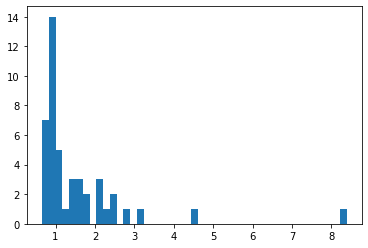

In [180]:
plt.hist(am_e_100_fish_list['latency_avg'],bins=len(am_e_100_fish_list))

(array([16.,  8.,  6.,  2.,  1.,  1.,  2.,  0.,  2.,  0.,  0.,  0.,  0.,
         1.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
         0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([ 0.58357143,  1.10653727,  1.62950311,  2.15246894,  2.67543478,
         3.19840062,  3.72136646,  4.2443323 ,  4.76729814,  5.29026398,
         5.81322981,  6.33619565,  6.85916149,  7.38212733,  7.90509317,
         8.42805901,  8.95102484,  9.47399068,  9.99695652, 10.51992236,
        11.0428882 , 11.56585404, 12.08881988, 12.61178571, 13.13475155,
        13.65771739, 14.18068323, 14.70364907, 15.22661491, 15.74958075,
        16.27254658, 16.79551242, 17.31847826, 17.8414441 , 18.36440994,
        18.88737578, 19.41034161, 19.93330745, 20.45627329, 20.97923913,
        21.50220497, 22.02517081, 22.54813665, 23.07110248, 23.59406832,
        24.11703416, 24.64      ]),
 <BarContainer object of 46 artists>)

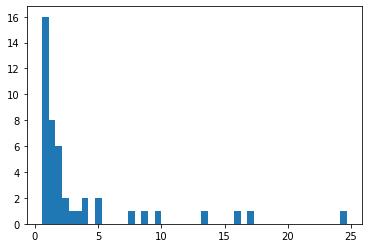

In [181]:
plt.hist(am_me_100_fish_list['latency_avg'],bins=len(am_me_100_fish_list))

In [182]:
from scipy.stats import poisson
data_poisson = poisson.rvs(mu=3, size=10000)

In [183]:
poisson = np.random.poisson(1, 10000)

In [184]:
stats.kstest(data_poisson, am_e_100_fish_list['latency_avg'])

KstestResult(statistic=0.5874777777777778, pvalue=3.0852742189968184e-15)

In [185]:
stats.kstest(data_poisson, am_me_100_fish_list['latency_avg'])

KstestResult(statistic=0.3966565217391304, pvalue=5.220134891021833e-07)

In [186]:
# stats.kstest(am_me_100_fish_list['latency_avg'],stats.poisson(mu=10))
stats.kstest(am_me_100_fish_list['latency_avg'], am_e_100_fish_list['latency_avg'])

KstestResult(statistic=0.25024154589371983, pvalue=0.09806040601822748)

## Relative Freq. vs Turn Angle 

In [187]:
# relative frequency of an event is the number of times the event occurs divided by the total number of trials

In [290]:
np.arange(-np.pi,2*np.pi,2*np.pi/50)

array([-3.14159265e+00, -3.01592895e+00, -2.89026524e+00, -2.76460154e+00,
       -2.63893783e+00, -2.51327412e+00, -2.38761042e+00, -2.26194671e+00,
       -2.13628300e+00, -2.01061930e+00, -1.88495559e+00, -1.75929189e+00,
       -1.63362818e+00, -1.50796447e+00, -1.38230077e+00, -1.25663706e+00,
       -1.13097336e+00, -1.00530965e+00, -8.79645943e-01, -7.53982237e-01,
       -6.28318531e-01, -5.02654825e-01, -3.76991118e-01, -2.51327412e-01,
       -1.25663706e-01,  4.44089210e-15,  1.25663706e-01,  2.51327412e-01,
        3.76991118e-01,  5.02654825e-01,  6.28318531e-01,  7.53982237e-01,
        8.79645943e-01,  1.00530965e+00,  1.13097336e+00,  1.25663706e+00,
        1.38230077e+00,  1.50796447e+00,  1.63362818e+00,  1.75929189e+00,
        1.88495559e+00,  2.01061930e+00,  2.13628300e+00,  2.26194671e+00,
        2.38761042e+00,  2.51327412e+00,  2.63893783e+00,  2.76460154e+00,
        2.89026524e+00,  3.01592895e+00,  3.14159265e+00,  3.26725636e+00,
        3.39292007e+00,  

In [313]:
am_e_C1_events['fish_n'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 16, 17, 18, 20,
       21, 22, 24, 26, 28, 29, 30, 31, 32, 33, 34, 36, 37, 38, 39, 40, 41,
       42, 43, 44, 46, 47, 48, 52, 53, 57, 58, 59, 60, 61, 62, 63])

In [361]:
def make_avg_hist(event_table): 
    avg_hist_list = []
    for n in event_table['fish_n'].unique():
        fish = event_table[event_table['fish_n']==n]
        values, bins = np.histogram(fish['delta_theta_rad'],bins=np.arange(-np.pi,np.pi,2*np.pi/51))
        avg_hist_list.append(values)
    hist_array = np.asarray(avg_hist_list)
    avg_hist_array = np.mean(hist_array,axis=0)
    
    return avg_hist_array

In [446]:
avg_hist_am_e_C0 = make_avg_hist(am_e_events_0)
avg_hist_am_me_C0 = make_avg_hist(am_me_events_0)
avg_hist_pm_e_C0 = make_avg_hist(pm_e_events_0)
avg_hist_pm_me_C0 = make_avg_hist(pm_me_events_0)

In [364]:
avg_hist_am_e_C1 = make_avg_hist(am_e_C1_events)
avg_hist_am_e_C10 = make_avg_hist(am_e_C10_events)
avg_hist_am_e_C20 = make_avg_hist(am_e_C20_events)
avg_hist_am_e_C30 = make_avg_hist(am_e_C30_events)
avg_hist_am_e_C50 = make_avg_hist(am_e_C50_events)
avg_hist_am_e_C70 = make_avg_hist(am_e_C70_events)
avg_hist_am_e_C100 = make_avg_hist(am_e_C100_events)

In [371]:
avg_hist_am_me_C1 = make_avg_hist(am_me_C1_events)
avg_hist_am_me_C10 = make_avg_hist(am_me_C10_events)
avg_hist_am_me_C20 = make_avg_hist(am_me_C20_events)
avg_hist_am_me_C30 = make_avg_hist(am_me_C30_events)
avg_hist_am_me_C50 = make_avg_hist(am_me_C50_events)
avg_hist_am_me_C70 = make_avg_hist(am_me_C70_events)
avg_hist_am_me_C100 = make_avg_hist(am_me_C100_events)

In [372]:
avg_hist_pm_e_C1 = make_avg_hist(pm_e_C1_events)
avg_hist_pm_e_C10 = make_avg_hist(pm_e_C10_events)
avg_hist_pm_e_C20 = make_avg_hist(pm_e_C20_events)
avg_hist_pm_e_C30 = make_avg_hist(pm_e_C30_events)
avg_hist_pm_e_C50 = make_avg_hist(pm_e_C50_events)
avg_hist_pm_e_C70 = make_avg_hist(pm_e_C70_events)
avg_hist_pm_e_C100 = make_avg_hist(pm_e_C100_events)

In [373]:
avg_hist_pm_me_C1 = make_avg_hist(pm_me_C1_events)
avg_hist_pm_me_C10 = make_avg_hist(pm_me_C10_events)
avg_hist_pm_me_C20 = make_avg_hist(pm_me_C20_events)
avg_hist_pm_me_C30 = make_avg_hist(pm_me_C30_events)
avg_hist_pm_me_C50 = make_avg_hist(pm_me_C50_events)
avg_hist_pm_me_C70 = make_avg_hist(pm_me_C70_events)
avg_hist_pm_me_C100 = make_avg_hist(pm_me_C100_events)

(-4.0, 4.0)

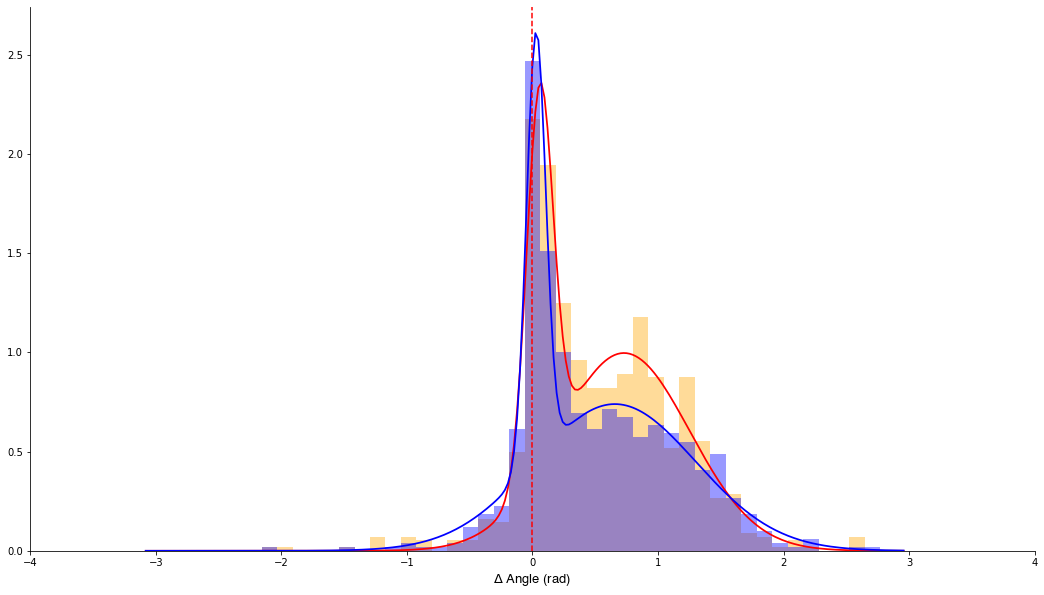

In [431]:
fig, ax = plt.subplots(1,1,figsize=(18,10))

pi_range = np.arange(-np.pi,np.pi,2*np.pi/51)
x = (pi_range[1:]+pi_range[:-1])/2 
x_fit = np.linspace(x.min(), x.max(), 250)

ax.stairs(avg_hist_am_e_C70,pi_range,fill=True,alpha=0.4,color='orange')
ax.stairs(avg_hist_am_me_C70,pi_range,fill=True,alpha=0.4,color='blue')

expected01 = (0.05, 0.3, 1.5, 0.9, 1.2, 1.2)
params01, cov01 = curve_fit(bimodal, x, avg_hist_am_e_C70, expected01)
ax.plot(x_fit, bimodal(x_fit, *params01), color='red', lw=1.75, label='E2 Model')

expected02 = (0.05, 0.3, 1.75, 0.6, 0.7, 0.6)
params02, cov02 = curve_fit(bimodal, x, avg_hist_am_me_C70, expected02)
ax.plot(x_fit, bimodal(x_fit, *params02), color='blue', lw=1.75, label='Methionine Model')

ax.axvline(x=0,ls='--', color='r')
ax.set_xlabel(r'$\Delta$ Angle (rad)',name='Helvetica',fontsize=13)
ax1.set_ylabel('Probability Density',name='Helvetica',fontsize=13)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# ax.set_ylim(0,3.5)
ax.set_xlim(-4,4)

In [316]:
values, bins = np.histogram(am_me_C100_events['delta_theta_rad'])
values

array([  2,   0,   4,  22, 206, 165, 110,  16,   4,   2])

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
         1.,  0.,  0.,  0.,  0.,  0.,  2.,  1.,  0.,  0.,  1.,  0.,  1.,
         4.,  2.,  2.,  1.,  1.,  2.,  2.,  3.,  4.,  7.,  6., 24., 87.,
        52., 45., 29., 23., 15., 22., 24., 27., 30., 26., 25., 36., 47.,
        18., 28., 33., 16., 17., 12.,  8.,  5.,  7.,  4.,  1.,  1.,  3.,
         0.,  2.,  1.,  0.,  0.,  4.,  1.,  1.,  0.,  0.,  1.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([-2.94721  , -2.8701077, -2.7930054, -2.7159031, -2.6388008,
        -2.5616985, -2.4845962, -2.4074939, -2.3303916, -2.2532893,
        -2.176187 , -2.0990847, -2.0219824, -1.9448801, -1.8677778,
        -1.7906755, -1.7135732, -1.6364709, -1.5593686, -1.4822663,
        -1.405164 , -1.3280617, -1.2509594, -1.1738571, -1.0967548,
        -1.0196525, -0.9425502, -0.8654479, -0.7883456, -0.7112433,
        -0.634141 , -0.557

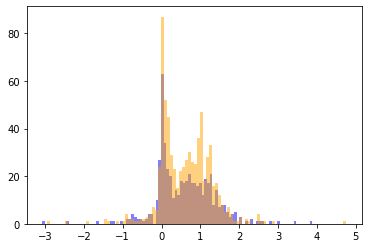

In [195]:
plt.hist(am_me_C100_events['delta_theta_rad'],bins=100,alpha=0.5,color='blue')
plt.hist(am_e_C100_events['delta_theta_rad'],bins=100,alpha=0.5,color='orange')
# plt.xlim(-5,5)

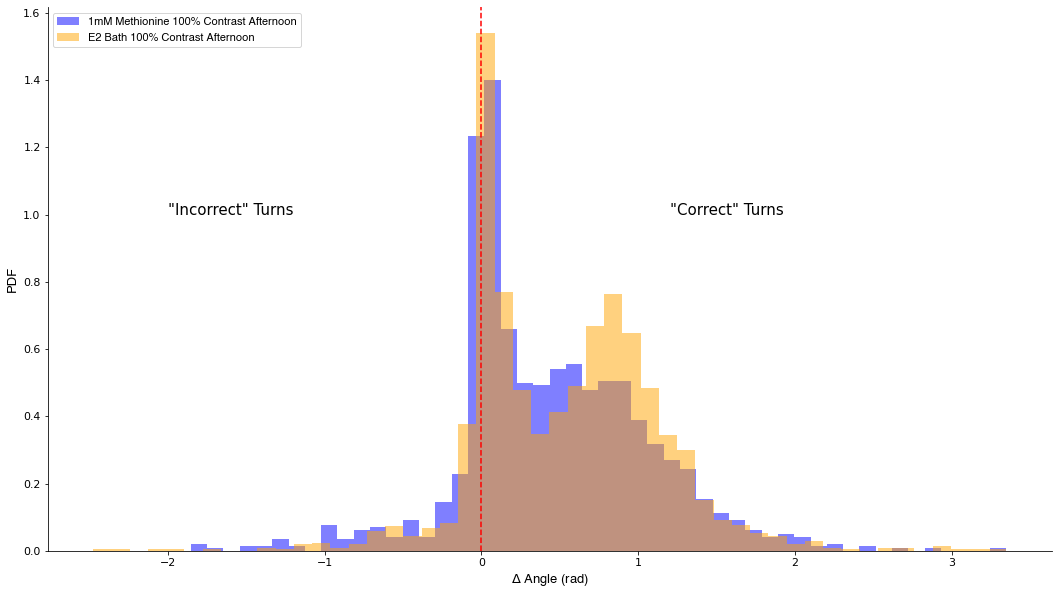

In [196]:
fig, ax = plt.subplots(1,1,figsize=(18,10))

pm_me_100_counts, pm_me_100_bins = np.histogram(pm_me_C100_events['delta_theta_rad'],bins=50)
pm_e_100_counts, pm_e_100_bins = np.histogram(pm_e_C100_events['delta_theta_rad'],bins=50)

plt.hist(pm_me_C100_events['delta_theta_rad'],bins=50,alpha=0.5,color='blue',density=True,stacked=True,histtype='stepfilled', label='1mM Methionine 100% Contrast Afternoon')
plt.hist(pm_e_C100_events['delta_theta_rad'],bins=50,alpha=0.5,color='orange',density=True,stacked=True,histtype='stepfilled', label='E2 Bath 100% Contrast Afternoon')

# ax.plot(pm_me_100_bins[1:], pm_me_100_counts,label='AM Met 100%',color='blue')
# ax.plot(pm_e_100_bins[1:], pm_e_100_counts, label='AM E2 100%',color='orange')
# ax.plot(pm_e_100_bins[:-1], pm_e_100_counts/len(pm_e_C100_events), label='AM E2 100%',color='orange')
plt.axvline(x=0,ls='--', color='r')
ax.text(-2, 1, '"Incorrect" Turns',fontsize=15)
ax.text(1.2, 1, '"Correct" Turns',fontsize=15)

plt.xlabel(r'$\Delta$ Angle (rad)',name='Helvetica',fontsize=13)
plt.ylabel('PDF',name='Helvetica',fontsize=13)

font = font_manager.FontProperties(family='Helvetica',
                                   style='normal', size=11)
plt.legend(loc='upper left',prop=font,fontsize=12)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

plt.savefig('../../Dissertation/PDF_distribution_E2andMET_pm_100.png',dpi=400,bbox_inches='tight')

plt.show()

In [197]:
stats.kstest(pm_me_C100_events['delta_theta_rad'],pm_e_C100_events['delta_theta_rad'])

KstestResult(statistic=0.10990480221734725, pvalue=1.2172233110267485e-08)

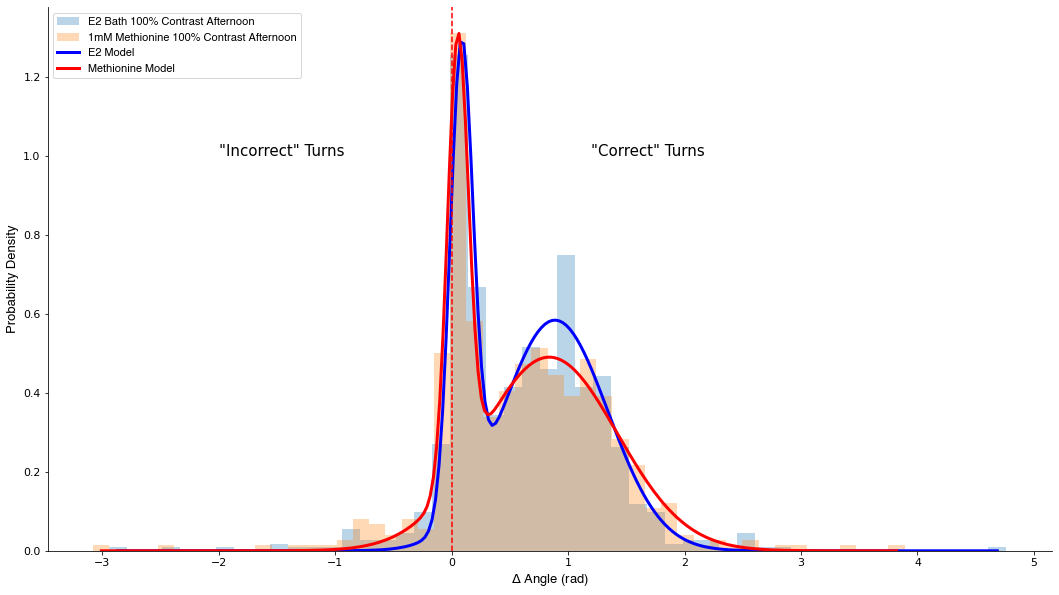

In [199]:
fig, ax = plt.subplots(1,1,figsize=(18,10))
data=am_e_C100_events['delta_theta_rad']
y,x,_=ax.hist(data, 50, alpha=.3, density=True, label='E2 Bath 100% Contrast Afternoon')
x=(x[1:]+x[:-1])/2 

data2=am_me_C100_events['delta_theta_rad']
y2,x2,_=ax.hist(data2, 50, alpha=.3, density=True, label='1mM Methionine 100% Contrast Afternoon')
x2=(x2[1:]+x2[:-1])/2 

expected = (0.05, 0.3, 1.5, 0.9, 1.2, 1.2)
params, cov = curve_fit(bimodal, x, y, expected)
sigma=np.sqrt(np.diag(cov))
x_fit = np.linspace(x.min(), x.max(), 250)

expected2 = (0.05, 0.3, 1.75, 0.6, 0.7, 0.6)
params2, cov2 = curve_fit(bimodal, x2, y2, expected2)
sigma2=np.sqrt(np.diag(cov2))
x_fit2 = np.linspace(x2.min(), x2.max(), 250)


ax.plot(x_fit, bimodal(x_fit, *params), color='blue', lw=3, label='E2 Model')
ax.plot(x_fit2, bimodal(x_fit2, *params2), color='red', lw=3, label='Methionine Model')

#Individual Gauss curves
# ax.plot(x_fit, gauss(x_fit, *params[:3]), color='red', lw=1, ls="--", label='distribution 1')
# ax.plot(x_fit, gauss(x_fit, *params[3:]), color='red', lw=1, ls=":", label='distribution 2')
#and the original data points if no histogram has been created before
#plt.scatter(x, y, marker="X", color="black", label="original data")

plt.axvline(x=0,ls='--', color='r')
ax.text(-2, 1, '"Incorrect" Turns',fontsize=15)
ax.text(1.2, 1, '"Correct" Turns',fontsize=15)

plt.xlabel(r'$\Delta$ Angle (rad)',name='Helvetica',fontsize=13)
plt.ylabel('Probability Density',name='Helvetica',fontsize=13)

font = font_manager.FontProperties(family='Helvetica',
                                   style='normal', size=11)
plt.legend(loc='upper left',prop=font,fontsize=12)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

plt.savefig('../../Dissertation/PDF_distribution_E2andMET_pm_100.png',dpi=400,bbox_inches='tight')

plt.show()

In [ ]:
import matplotlib.pyplot as plt

/Users/katarzynakupczyk/.pyenv/versions/3.8.6/envs/dissertation2022/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


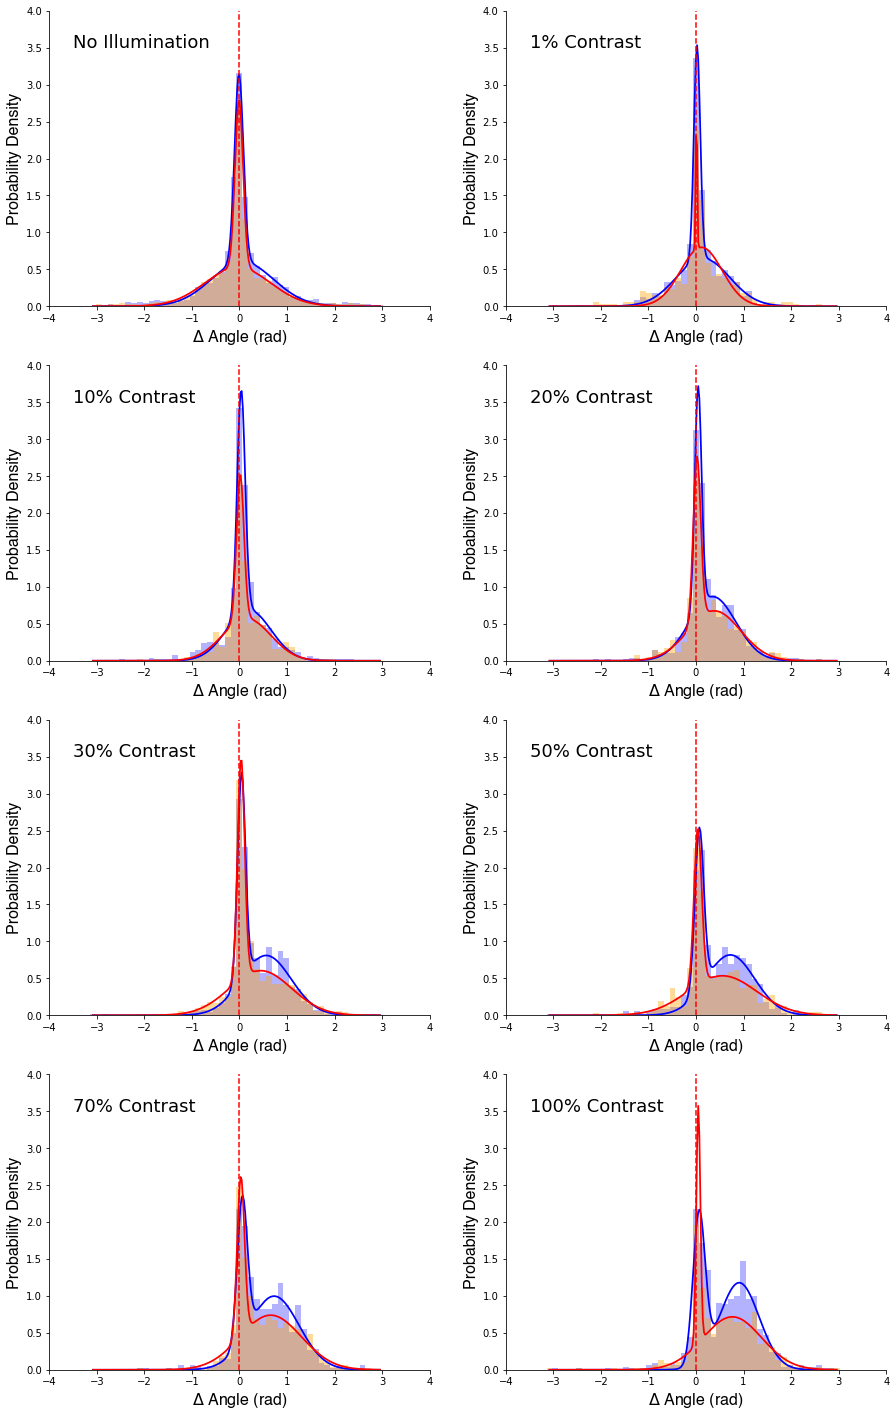

In [453]:
fig, ((ax1,ax2),(ax3,ax4),(ax5,ax6),(ax7,ax8)) = plt.subplots(4,2,figsize=(15,25))
# plt.suptitle('Probability Density of Average Turning Angles in the Morning',fontsize=20)

pi_range = np.arange(-np.pi,np.pi,2*np.pi/51)
x = (pi_range[1:]+pi_range[:-1])/2 
x_fit = np.linspace(x.min(), x.max(), 250)

# ax1 --> Contrast 0% --> MAKE THESE 

ax1.stairs(avg_hist_am_e_C0,pi_range,fill=True,alpha=0.3,color='blue')
ax1.stairs(avg_hist_am_me_C0,pi_range,fill=True,alpha=0.4,color='orange')

expected01 = (0.05, 0.3, 1.5, 0.9, 1.2, 1.2)
params01, cov01 = curve_fit(bimodal, x, avg_hist_am_e_C0, expected01)
ax1.plot(x_fit, bimodal(x_fit, *params01), color='blue', lw=1.75, label='E2 Model')

expected02 = (0.05, 0.3, 1.75, 0.6, 0.7, 0.6)
params02, cov02 = curve_fit(bimodal, x, avg_hist_am_me_C0, expected02)
ax1.plot(x_fit, bimodal(x_fit, *params02), color='red', lw=1.75, label='Methionine Model')

ax1.axvline(x=0,ls='--', color='r')

ax1.set_xlabel(r'$\Delta$ Angle (rad)',name='Helvetica',fontsize=16)
ax1.set_ylabel('Probability Density',name='Helvetica',fontsize=16)

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
# ax1.spines['left'].set_visible(False)
# ax1.spines['bottom'].set_visible(False)

ax1.set_ylim(0,4)
ax1.set_xlim(-4,4)

# ax1.set_xticks([])
# ax1.set_yticks([])

# ax1.scatter(x=-3.9,y=3.8,marker='_',c='b')
# ax1.scatter(x=-3.8,y=3.8,marker='_',c='b')
ax1.text(-3.5,3.5,'No Illumination',fontsize=18)

# ax1.scatter(x=-3.9,y=3.5,marker='_',c='r')
# ax1.scatter(x=-3.8,y=3.5,marker='_',c='r')
# ax1.text(-3.5,3.45,'Methionine Model')

# ax1.set_xticks(fontsize=11)
# ax1.set_yticks(fontsize=11)


# ax2 --> Contrast 1%

ax2.stairs(avg_hist_am_e_C1,pi_range,fill=True,alpha=0.3,color='blue')
ax2.stairs(avg_hist_am_me_C1,pi_range,fill=True,alpha=0.4,color='orange')

expected01 = (0.05, 0.3, 1.5, 0.9, 1.2, 1.2)
params01, cov01 = curve_fit(bimodal, x, avg_hist_am_e_C1, expected01)
ax2.plot(x_fit, bimodal(x_fit, *params01), color='blue', lw=1.75, label='E2 Model')

expected02 = (0.05, 0.3, 1.75, 0.6, 0.7, 0.6)
params02, cov02 = curve_fit(bimodal, x, avg_hist_am_me_C1, expected02)
ax2.plot(x_fit, bimodal(x_fit, *params02), color='red', lw=1.75, label='Methionine Model')

ax2.axvline(x=0,ls='--', color='r')

ax2.set_xlabel(r'$\Delta$ Angle (rad)',name='Helvetica',fontsize=16)
ax2.set_ylabel('Probability Density',name='Helvetica',fontsize=16)

ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

ax2.set_ylim(0,4)
ax2.set_xlim(-4,4)

ax2.text(-3.5,3.5,'1% Contrast',fontsize=18)

# plt.xticks(fontsize=11)
# plt.yticks(fontsize=11)



# ax3 --> Contrast 10%

ax3.stairs(avg_hist_am_e_C10,pi_range,fill=True,alpha=0.3,color='blue')
ax3.stairs(avg_hist_am_me_C10,pi_range,fill=True,alpha=0.4,color='orange')

expected01 = (0.05, 0.3, 1.5, 0.9, 1.2, 1.2)
params01, cov01 = curve_fit(bimodal, x, avg_hist_am_e_C10, expected01)
ax3.plot(x_fit, bimodal(x_fit, *params01), color='blue', lw=1.75, label='E2 Model')

expected02 = (0.05, 0.3, 1.75, 0.6, 0.7, 0.6)
params02, cov02 = curve_fit(bimodal, x, avg_hist_am_me_C10, expected02)
ax3.plot(x_fit, bimodal(x_fit, *params02), color='red', lw=1.75, label='Methionine Model')

ax3.axvline(x=0,ls='--', color='r')

ax3.set_xlabel(r'$\Delta$ Angle (rad)',name='Helvetica',fontsize=16)
ax3.set_ylabel('Probability Density',name='Helvetica',fontsize=16)

ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)

ax3.set_ylim(0,4)
ax3.set_xlim(-4,4)

ax3.text(-3.5,3.5,'10% Contrast',fontsize=18)

# plt.xticks(fontsize=11)
# plt.yticks(fontsize=11)



# ax4 --> Contrast 20%

ax4.stairs(avg_hist_am_e_C20,pi_range,fill=True,alpha=0.3,color='blue')
ax4.stairs(avg_hist_am_me_C20,pi_range,fill=True,alpha=0.4,color='orange')

expected01 = (0.05, 0.3, 1.5, 0.9, 1.2, 1.2)
params01, cov01 = curve_fit(bimodal, x, avg_hist_am_e_C20, expected01)
ax4.plot(x_fit, bimodal(x_fit, *params01), color='blue', lw=1.75, label='E2 Model')

expected02 = (0.05, 0.3, 1.75, 0.6, 0.7, 0.6)
params02, cov02 = curve_fit(bimodal, x, avg_hist_am_me_C20, expected02)
ax4.plot(x_fit, bimodal(x_fit, *params02), color='red', lw=1.75, label='Methionine Model')

ax4.axvline(x=0,ls='--', color='r')

ax4.set_xlabel(r'$\Delta$ Angle (rad)',name='Helvetica',fontsize=16)
ax4.set_ylabel('Probability Density',name='Helvetica',fontsize=16)

ax4.spines['right'].set_visible(False)
ax4.spines['top'].set_visible(False)

ax4.set_ylim(0,4)
ax4.set_xlim(-4,4)

ax4.text(-3.5,3.5,'20% Contrast',fontsize=18)

# plt.xticks(fontsize=11)
# plt.yticks(fontsize=11)



# ax5 --> Contrast 30%

ax5.stairs(avg_hist_am_e_C30,pi_range,fill=True,alpha=0.3,color='blue')
ax5.stairs(avg_hist_am_me_C30,pi_range,fill=True,alpha=0.4,color='orange')

expected01 = (0.05, 0.3, 1.5, 0.9, 1.2, 1.2)
params01, cov01 = curve_fit(bimodal, x, avg_hist_am_e_C30, expected01)
ax5.plot(x_fit, bimodal(x_fit, *params01), color='blue', lw=1.75, label='E2 Model')

expected02 = (0.05, 0.3, 1.75, 0.6, 0.7, 0.6)
params02, cov02 = curve_fit(bimodal, x, avg_hist_am_me_C30, expected02)
ax5.plot(x_fit, bimodal(x_fit, *params02), color='red', lw=1.75, label='Methionine Model')

ax5.axvline(x=0,ls='--', color='r')

ax5.set_xlabel(r'$\Delta$ Angle (rad)',name='Helvetica',fontsize=16)
ax5.set_ylabel('Probability Density',name='Helvetica',fontsize=16)

ax5.spines['right'].set_visible(False)
ax5.spines['top'].set_visible(False)

ax5.set_ylim(0,4)
ax5.set_xlim(-4,4)

ax5.text(-3.5,3.5,'30% Contrast',fontsize=18)

# plt.xticks(fontsize=11)
# plt.yticks(fontsize=11)



# ax6 --> Contrast 50%

ax6.stairs(avg_hist_am_e_C50,pi_range,fill=True,alpha=0.3,color='blue')
ax6.stairs(avg_hist_am_me_C50,pi_range,fill=True,alpha=0.4,color='orange')

expected01 = (0.05, 0.3, 1.5, 0.9, 1.2, 1.2)
params01, cov01 = curve_fit(bimodal, x, avg_hist_am_e_C50, expected01)
ax6.plot(x_fit, bimodal(x_fit, *params01), color='blue', lw=1.75, label='E2 Model')

expected02 = (0.05, 0.3, 1.75, 0.6, 0.7, 0.6)
params02, cov02 = curve_fit(bimodal, x, avg_hist_am_me_C50, expected02)
ax6.plot(x_fit, bimodal(x_fit, *params02), color='red', lw=1.75, label='Methionine Model')

ax6.axvline(x=0,ls='--', color='r')

ax6.set_xlabel(r'$\Delta$ Angle (rad)',name='Helvetica',fontsize=16)
ax6.set_ylabel('Probability Density',name='Helvetica',fontsize=16)

ax6.spines['right'].set_visible(False)
ax6.spines['top'].set_visible(False)

ax6.set_ylim(0,4)
ax6.set_xlim(-4,4)

ax6.text(-3.5,3.5,'50% Contrast',fontsize=18)

# plt.xticks(fontsize=11)
# plt.yticks(fontsize=11)



# ax7 --> Contrast 70%

ax7.stairs(avg_hist_am_e_C70,pi_range,fill=True,alpha=0.3,color='blue')
ax7.stairs(avg_hist_am_me_C70,pi_range,fill=True,alpha=0.4,color='orange')

expected01 = (0.05, 0.3, 1.5, 0.9, 1.2, 1.2)
params01, cov01 = curve_fit(bimodal, x, avg_hist_am_e_C70, expected01)
ax7.plot(x_fit, bimodal(x_fit, *params01), color='blue', lw=1.75, label='E2 Model')

expected02 = (0.05, 0.3, 1.75, 0.6, 0.7, 0.6)
params02, cov02 = curve_fit(bimodal, x, avg_hist_am_me_C70, expected02)
ax7.plot(x_fit, bimodal(x_fit, *params02), color='red', lw=1.75, label='Methionine Model')

ax7.axvline(x=0,ls='--', color='r')

ax7.set_xlabel(r'$\Delta$ Angle (rad)',name='Helvetica',fontsize=16)
ax7.set_ylabel('Probability Density',name='Helvetica',fontsize=16)

ax7.spines['right'].set_visible(False)
ax7.spines['top'].set_visible(False)

ax7.set_ylim(0,4)
ax7.set_xlim(-4,4)

ax7.text(-3.5,3.5,'70% Contrast',fontsize=18)

# plt.xticks(fontsize=11)
# plt.yticks(fontsize=11)



# ax8 --> Contrast 100%

ax8.stairs(avg_hist_am_e_C100,pi_range,fill=True,alpha=0.3,color='blue')
ax8.stairs(avg_hist_am_me_C100,pi_range,fill=True,alpha=0.4,color='orange')

expected01 = (0.05, 0.3, 1.5, 0.9, 1.2, 1.2)
params01, cov01 = curve_fit(bimodal, x, avg_hist_am_e_C100, expected01)
ax8.plot(x_fit, bimodal(x_fit, *params01), color='blue', lw=1.75, label='E2 Model')

expected02 = (0.05, 0.3, 1.75, 0.6, 0.7, 0.6)
params02, cov02 = curve_fit(bimodal, x, avg_hist_am_me_C100, expected02)
ax8.plot(x_fit, bimodal(x_fit, *params02), color='red', lw=1.75, label='Methionine Model')

ax8.axvline(x=0,ls='--', color='r')

ax8.set_xlabel(r'$\Delta$ Angle (rad)',name='Helvetica',fontsize=16)
ax8.set_ylabel('Probability Density',name='Helvetica',fontsize=16)

ax8.spines['right'].set_visible(False)
ax8.spines['top'].set_visible(False)

ax8.set_ylim(0,4)
ax8.set_xlim(-4,4)

ax8.text(-3.5,3.5,'100% Contrast',fontsize=18)

# plt.xticks(fontsize=11)
# plt.yticks(fontsize=11)

plt.savefig('../../Dissertation/PDF_turn_angle_distribution_AM.png',dpi=400,bbox_inches='tight')

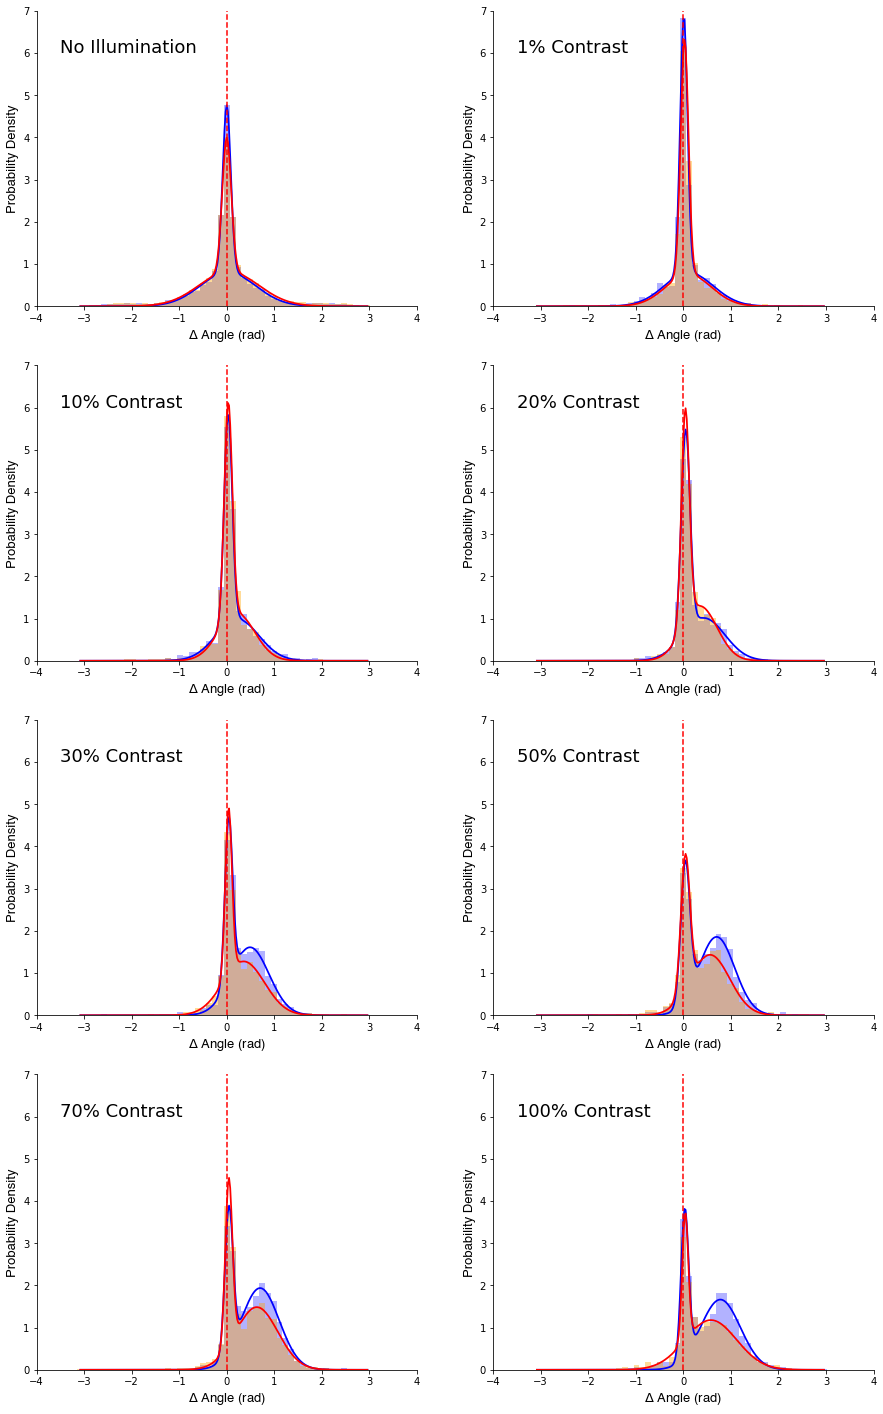

In [455]:
fig, ((ax1,ax2),(ax3,ax4),(ax5,ax6),(ax7,ax8)) = plt.subplots(4,2,figsize=(15,25))
# plt.suptitle('Probability Density of Average Turning Angles in the Afternoon',fontsize=20)

pi_range = np.arange(-np.pi,np.pi,2*np.pi/51)
x = (pi_range[1:]+pi_range[:-1])/2 
x_fit = np.linspace(x.min(), x.max(), 250)

# ax1 --> Contrast 0% --> MAKE THESE 

ax1.stairs(avg_hist_pm_e_C0,pi_range,fill=True,alpha=0.3,color='blue')
ax1.stairs(avg_hist_pm_me_C0,pi_range,fill=True,alpha=0.4,color='orange')

expected01 = (0.05, 0.3, 1.5, 0.9, 1.2, 1.2)
params01, cov01 = curve_fit(bimodal, x, avg_hist_pm_e_C0, expected01)
ax1.plot(x_fit, bimodal(x_fit, *params01), color='blue', lw=1.75, label='E2 Model')

expected02 = (0.05, 0.3, 1.75, 0.6, 0.7, 0.6)
params02, cov02 = curve_fit(bimodal, x, avg_hist_pm_me_C0, expected02)
ax1.plot(x_fit, bimodal(x_fit, *params02), color='red', lw=1.75, label='Methionine Model')

ax1.axvline(x=0,ls='--', color='r')

ax1.set_xlabel(r'$\Delta$ Angle (rad)',name='Helvetica',fontsize=13)
ax1.set_ylabel('Probability Density',name='Helvetica',fontsize=13)

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
# ax1.spines['left'].set_visible(False)
# ax1.spines['bottom'].set_visible(False)

ax1.set_ylim(0,7)
ax1.set_xlim(-4,4)

ax1.text(-3.5,6,'No Illumination',fontsize=18)

# ax1.set_xticks([])
# ax1.set_yticks([])

# ax1.scatter(x=-3.9,y=3.8,marker='_',c='b')
# ax1.scatter(x=-3.8,y=3.8,marker='_',c='b')
# ax1.text(-3.5,3.75,'E2 Model')

# ax1.scatter(x=-3.9,y=3.5,marker='_',c='r')
# ax1.scatter(x=-3.8,y=3.5,marker='_',c='r')
# ax1.text(-3.5,3.45,'Methionine Model')

# ax1.set_xticks(fontsize=11)
# ax1.set_yticks(fontsize=11)


# ax2 --> Contrast 1%

ax2.stairs(avg_hist_pm_e_C1,pi_range,fill=True,alpha=0.3,color='blue')
ax2.stairs(avg_hist_pm_me_C1,pi_range,fill=True,alpha=0.4,color='orange')

expected01 = (0.05, 0.3, 1.5, 0.9, 1.2, 1.2)
params01, cov01 = curve_fit(bimodal, x, avg_hist_pm_e_C1, expected01)
ax2.plot(x_fit, bimodal(x_fit, *params01), color='blue', lw=1.75, label='E2 Model')

expected02 = (0.05, 0.3, 1.75, 0.6, 0.7, 0.6)
params02, cov02 = curve_fit(bimodal, x, avg_hist_pm_me_C1, expected02)
ax2.plot(x_fit, bimodal(x_fit, *params02), color='red', lw=1.75, label='Methionine Model')

ax2.axvline(x=0,ls='--', color='r')

ax2.set_xlabel(r'$\Delta$ Angle (rad)',name='Helvetica',fontsize=13)
ax2.set_ylabel('Probability Density',name='Helvetica',fontsize=13)

ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

ax2.set_ylim(0,7)
ax2.set_xlim(-4,4)

ax2.text(-3.5,6,'1% Contrast',fontsize=18)

# plt.xticks(fontsize=11)
# plt.yticks(fontsize=11)



# ax3 --> Contrast 10%

ax3.stairs(avg_hist_pm_e_C10,pi_range,fill=True,alpha=0.3,color='blue')
ax3.stairs(avg_hist_pm_me_C10,pi_range,fill=True,alpha=0.4,color='orange')

expected01 = (0.05, 0.3, 1.5, 0.9, 1.2, 1.2)
params01, cov01 = curve_fit(bimodal, x, avg_hist_pm_e_C10, expected01)
ax3.plot(x_fit, bimodal(x_fit, *params01), color='blue', lw=1.75, label='E2 Model')

expected02 = (0.05, 0.3, 1.75, 0.6, 0.7, 0.6)
params02, cov02 = curve_fit(bimodal, x, avg_hist_pm_me_C10, expected02)
ax3.plot(x_fit, bimodal(x_fit, *params02), color='red', lw=1.75, label='Methionine Model')

ax3.axvline(x=0,ls='--', color='r')

ax3.set_xlabel(r'$\Delta$ Angle (rad)',name='Helvetica',fontsize=13)
ax3.set_ylabel('Probability Density',name='Helvetica',fontsize=13)

ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)

ax3.set_ylim(0,7)
ax3.set_xlim(-4,4)

ax3.text(-3.5,6,'10% Contrast',fontsize=18)

# plt.xticks(fontsize=11)
# plt.yticks(fontsize=11)



# ax4 --> Contrast 20%

ax4.stairs(avg_hist_pm_e_C20,pi_range,fill=True,alpha=0.3,color='blue')
ax4.stairs(avg_hist_pm_me_C20,pi_range,fill=True,alpha=0.4,color='orange')

expected01 = (0.05, 0.3, 1.5, 0.9, 1.2, 1.2)
params01, cov01 = curve_fit(bimodal, x, avg_hist_pm_e_C20, expected01)
ax4.plot(x_fit, bimodal(x_fit, *params01), color='blue', lw=1.75, label='E2 Model')

expected02 = (0.05, 0.3, 1.75, 0.6, 0.7, 0.6)
params02, cov02 = curve_fit(bimodal, x, avg_hist_pm_me_C20, expected02)
ax4.plot(x_fit, bimodal(x_fit, *params02), color='red', lw=1.75, label='Methionine Model')

ax4.axvline(x=0,ls='--', color='r')

ax4.set_xlabel(r'$\Delta$ Angle (rad)',name='Helvetica',fontsize=13)
ax4.set_ylabel('Probability Density',name='Helvetica',fontsize=13)

ax4.spines['right'].set_visible(False)
ax4.spines['top'].set_visible(False)

ax4.set_ylim(0,7)
ax4.set_xlim(-4,4)

ax4.text(-3.5,6,'20% Contrast',fontsize=18)

# plt.xticks(fontsize=11)
# plt.yticks(fontsize=11)



# ax5 --> Contrast 30%

ax5.stairs(avg_hist_pm_e_C30,pi_range,fill=True,alpha=0.3,color='blue')
ax5.stairs(avg_hist_pm_me_C30,pi_range,fill=True,alpha=0.4,color='orange')

expected01 = (0.05, 0.3, 1.5, 0.9, 1.2, 1.2)
params01, cov01 = curve_fit(bimodal, x, avg_hist_pm_e_C30, expected01)
ax5.plot(x_fit, bimodal(x_fit, *params01), color='blue', lw=1.75, label='E2 Model')

expected02 = (0.05, 0.3, 1.75, 0.6, 0.7, 0.6)
params02, cov02 = curve_fit(bimodal, x, avg_hist_pm_me_C30, expected02)
ax5.plot(x_fit, bimodal(x_fit, *params02), color='red', lw=1.75, label='Methionine Model')

ax5.axvline(x=0,ls='--', color='r')

ax5.set_xlabel(r'$\Delta$ Angle (rad)',name='Helvetica',fontsize=13)
ax5.set_ylabel('Probability Density',name='Helvetica',fontsize=13)

ax5.spines['right'].set_visible(False)
ax5.spines['top'].set_visible(False)

ax5.set_ylim(0,7)
ax5.set_xlim(-4,4)

ax5.text(-3.5,6,'30% Contrast',fontsize=18)

# plt.xticks(fontsize=11)
# plt.yticks(fontsize=11)



# ax6 --> Contrast 50%

ax6.stairs(avg_hist_pm_e_C50,pi_range,fill=True,alpha=0.3,color='blue')
ax6.stairs(avg_hist_pm_me_C50,pi_range,fill=True,alpha=0.4,color='orange')

expected01 = (0.05, 0.3, 1.5, 0.9, 1.2, 1.2)
params01, cov01 = curve_fit(bimodal, x, avg_hist_pm_e_C50, expected01)
ax6.plot(x_fit, bimodal(x_fit, *params01), color='blue', lw=1.75, label='E2 Model')

expected02 = (0.05, 0.3, 1.75, 0.6, 0.7, 0.6)
params02, cov02 = curve_fit(bimodal, x, avg_hist_pm_me_C50, expected02)
ax6.plot(x_fit, bimodal(x_fit, *params02), color='red', lw=1.75, label='Methionine Model')

ax6.axvline(x=0,ls='--', color='r')

ax6.set_xlabel(r'$\Delta$ Angle (rad)',name='Helvetica',fontsize=13)
ax6.set_ylabel('Probability Density',name='Helvetica',fontsize=13)

ax6.spines['right'].set_visible(False)
ax6.spines['top'].set_visible(False)

ax6.set_ylim(0,7)
ax6.set_xlim(-4,4)

ax6.text(-3.5,6,'50% Contrast',fontsize=18)

# plt.xticks(fontsize=11)
# plt.yticks(fontsize=11)



# ax7 --> Contrast 70%

ax7.stairs(avg_hist_pm_e_C70,pi_range,fill=True,alpha=0.3,color='blue')
ax7.stairs(avg_hist_pm_me_C70,pi_range,fill=True,alpha=0.4,color='orange')

expected01 = (0.05, 0.3, 1.5, 0.9, 1.2, 1.2)
params01, cov01 = curve_fit(bimodal, x, avg_hist_pm_e_C70, expected01)
ax7.plot(x_fit, bimodal(x_fit, *params01), color='blue', lw=1.75, label='E2 Model')

expected02 = (0.05, 0.3, 1.75, 0.6, 0.7, 0.6)
params02, cov02 = curve_fit(bimodal, x, avg_hist_pm_me_C70, expected02)
ax7.plot(x_fit, bimodal(x_fit, *params02), color='red', lw=1.75, label='Methionine Model')

ax7.axvline(x=0,ls='--', color='r')

ax7.set_xlabel(r'$\Delta$ Angle (rad)',name='Helvetica',fontsize=13)
ax7.set_ylabel('Probability Density',name='Helvetica',fontsize=13)

ax7.spines['right'].set_visible(False)
ax7.spines['top'].set_visible(False)

ax7.set_ylim(0,7)
ax7.set_xlim(-4,4)

ax7.text(-3.5,6,'70% Contrast',fontsize=18)

# plt.xticks(fontsize=11)
# plt.yticks(fontsize=11)



# ax8 --> Contrast 100%

ax8.stairs(avg_hist_pm_e_C100,pi_range,fill=True,alpha=0.3,color='blue')
ax8.stairs(avg_hist_pm_me_C100,pi_range,fill=True,alpha=0.4,color='orange')

expected01 = (0.05, 0.3, 1.5, 0.9, 1.2, 1.2)
params01, cov01 = curve_fit(bimodal, x, avg_hist_pm_e_C100, expected01)
ax8.plot(x_fit, bimodal(x_fit, *params01), color='blue', lw=1.75, label='E2 Model')

expected02 = (0.05, 0.3, 1.75, 0.6, 0.7, 0.6)
params02, cov02 = curve_fit(bimodal, x, avg_hist_pm_me_C100, expected02)
ax8.plot(x_fit, bimodal(x_fit, *params02), color='red', lw=1.75, label='Methionine Model')

ax8.axvline(x=0,ls='--', color='r')

ax8.set_xlabel(r'$\Delta$ Angle (rad)',name='Helvetica',fontsize=13)
ax8.set_ylabel('Probability Density',name='Helvetica',fontsize=13)

ax8.spines['right'].set_visible(False)
ax8.spines['top'].set_visible(False)

ax8.set_ylim(0,7)
ax8.set_xlim(-4,4)

ax8.text(-3.5,6,'100% Contrast',fontsize=18)

# plt.xticks(fontsize=11)
# plt.yticks(fontsize=11)

plt.savefig('../../Dissertation/PDF_turn_angle_distribution_PM.png',dpi=400,bbox_inches='tight')

In [437]:
# fig, ((ax1,ax2,ax3,ax4),(ax5,ax6,ax7,ax8)) = plt.subplots(2,4,figsize=(18,10))
# plt.suptitle('Probability Density of Average Turning Angles in the Morning',fontsize=20)

# # ax1 --> Contrast 0%

# data01=am_e_events_0['delta_theta_rad']
# y01,x01,_01=ax1.hist(data01, 50, alpha=.3, density=True, label='E2 Bath 0% Contrast Afternoon')
# x01=(x01[1:]+x01[:-1])/2 

# data02=am_me_events_0['delta_theta_rad']
# y02,x02,_02=ax1.hist(data02, 50, alpha=.3, density=True, label='1mM Methionine 0% Contrast Afternoon')
# x02=(x02[1:]+x02[:-1])/2 

# expected01 = (0.05, 0.3, 1.5, 0.9, 1.2, 1.2)
# params01, cov01 = curve_fit(bimodal, x01, y01, expected01)
# sigma01=np.sqrt(np.diag(cov01))
# x_fit01 = np.linspace(x01.min(), x01.max(), 250)

# expected02 = (0.05, 0.3, 1.75, 0.6, 0.7, 0.6)
# params02, cov02 = curve_fit(bimodal, x02, y02, expected02)
# sigma02=np.sqrt(np.diag(cov02))
# x_fit02 = np.linspace(x02.min(), x02.max(), 250)


# ax1.plot(x_fit01, bimodal(x_fit01, *params01), color='blue', lw=1.75, label='E2 Model')
# ax1.plot(x_fit02, bimodal(x_fit02, *params02), color='red', lw=1.75, label='Methionine Model')

# ax1.axvline(x=0,ls='--', color='r')

# ax1.set_xlabel(r'$\Delta$ Angle (rad)',name='Helvetica',fontsize=13)
# ax1.set_ylabel('Probability Density',name='Helvetica',fontsize=13)

# ax1.spines['right'].set_visible(False)
# ax1.spines['top'].set_visible(False)
# # ax1.spines['left'].set_visible(False)
# # ax1.spines['bottom'].set_visible(False)

# ax1.set_ylim(0,2.5)
# ax1.set_xlim(-4,4)

# # ax1.set_xticks([])
# # ax1.set_yticks([])

# # ax1.scatter(x=-3.9,y=3.8,marker='_',c='b')
# # ax1.scatter(x=-3.8,y=3.8,marker='_',c='b')
# # ax1.text(-3.5,3.75,'E2 Model')

# # ax1.scatter(x=-3.9,y=3.5,marker='_',c='r')
# # ax1.scatter(x=-3.8,y=3.5,marker='_',c='r')
# # ax1.text(-3.5,3.45,'Methionine Model')

# # ax1.set_xticks(fontsize=11)
# # ax1.set_yticks(fontsize=11)


# # ax2 --> Contrast 1%

# data11=am_e_C1_events['delta_theta_rad']
# y11,x11,_11=ax2.hist(data11, 50, alpha=.3, density=True, label='E2 Bath 1% Contrast Afternoon')
# x11=(x11[1:]+x11[:-1])/2 

# data12=am_me_C1_events['delta_theta_rad']
# y12,x12,_12=ax2.hist(data12, 50, alpha=.3, density=True, label='1mM Methionine 1% Contrast Afternoon')
# x12=(x12[1:]+x12[:-1])/2 

# expected11 = (0.05, 0.3, 1.5, 0.9, 1.2, 1.2)
# params11, cov11 = curve_fit(bimodal, x11, y11, expected11)
# sigma11=np.sqrt(np.diag(cov11))
# x_fit11 = np.linspace(x11.min(), x11.max(), 250)

# expected12 = (0.05, 0.3, 1.75, 0.6, 0.7, 0.6)
# params12, cov12 = curve_fit(bimodal, x12, y12, expected12)
# sigma12=np.sqrt(np.diag(cov12))
# x_fit12 = np.linspace(x12.min(), x12.max(), 250)


# ax2.plot(x_fit11, bimodal(x_fit11, *params11), color='blue', lw=1.75, label='E2 Model')
# ax2.plot(x_fit12, bimodal(x_fit12, *params12), color='red', lw=1.75, label='Methionine Model')

# ax2.axvline(x=0,ls='--', color='r')

# ax2.set_xlabel(r'$\Delta$ Angle (rad)',name='Helvetica',fontsize=13)
# ax2.set_ylabel('Probability Density',name='Helvetica',fontsize=13)

# ax2.spines['right'].set_visible(False)
# ax2.spines['top'].set_visible(False)

# ax2.set_ylim(0,2.5)
# ax2.set_xlim(-4,4)

# # plt.xticks(fontsize=11)
# # plt.yticks(fontsize=11)



# # ax3 --> Contrast 10%

# data101=am_e_C10_events['delta_theta_rad']
# y101,x101,_101=ax3.hist(data101, 50, alpha=.3, density=True, label='E2 Bath 10% Contrast Afternoon')
# x101=(x101[1:]+x101[:-1])/2 

# data102=am_me_C10_events['delta_theta_rad']
# y102,x102,_102=ax3.hist(data102, 50, alpha=.3, density=True, label='1mM Methionine 10% Contrast Afternoon')
# x102=(x102[1:]+x102[:-1])/2 

# expected101 = (0.05, 0.3, 1.5, 0.9, 1.2, 1.2)
# params101, cov101 = curve_fit(bimodal, x101, y101, expected101)
# sigma101=np.sqrt(np.diag(cov101))
# x_fit101 = np.linspace(x101.min(), x101.max(), 250)

# expected102 = (0.05, 0.3, 1.75, 0.6, 0.7, 0.6)
# params102, cov102 = curve_fit(bimodal, x102, y102, expected102)
# sigma102=np.sqrt(np.diag(cov102))
# x_fit102 = np.linspace(x102.min(), x102.max(), 250)


# ax3.plot(x_fit101, bimodal(x_fit101, *params101), color='blue', lw=1.75, label='E2 Model')
# ax3.plot(x_fit102, bimodal(x_fit102, *params102), color='red', lw=1.75, label='Methionine Model')

# ax3.axvline(x=0,ls='--', color='r')

# ax3.set_xlabel(r'$\Delta$ Angle (rad)',name='Helvetica',fontsize=13)
# ax3.set_ylabel('Probability Density',name='Helvetica',fontsize=13)

# ax3.spines['right'].set_visible(False)
# ax3.spines['top'].set_visible(False)

# ax3.set_ylim(0,2.5)
# ax3.set_xlim(-4,4)

# # plt.xticks(fontsize=11)
# # plt.yticks(fontsize=11)



# # ax4 --> Contrast 20%

# data201=am_e_C20_events['delta_theta_rad']
# y201,x201,_201=ax4.hist(data201, 50, alpha=.3, density=True, label='E2 Bath 20% Contrast Afternoon')
# x201=(x201[1:]+x201[:-1])/2 

# data202=am_me_C20_events['delta_theta_rad']
# y202,x202,_202=ax4.hist(data202, 50, alpha=.3, density=True, label='1mM Methionine 20% Contrast Afternoon')
# x202=(x202[1:]+x202[:-1])/2 

# expected201 = (0.05, 0.3, 1.5, 0.9, 1.2, 1.2)
# params201, cov201 = curve_fit(bimodal, x201, y201, expected201)
# sigma201=np.sqrt(np.diag(cov201))
# x_fit201 = np.linspace(x201.min(), x201.max(), 250)

# expected202 = (0.05, 0.3, 1.75, 0.6, 0.7, 0.6)
# params202, cov202 = curve_fit(bimodal, x202, y202, expected202)
# sigma202=np.sqrt(np.diag(cov202))
# x_fit202 = np.linspace(x202.min(), x202.max(), 250)


# ax4.plot(x_fit201, bimodal(x_fit201, *params201), color='blue', lw=1.75, label='E2 Model')
# ax4.plot(x_fit202, bimodal(x_fit202, *params202), color='red', lw=1.75, label='Methionine Model')

# ax4.axvline(x=0,ls='--', color='r')

# ax4.set_xlabel(r'$\Delta$ Angle (rad)',name='Helvetica',fontsize=13)
# ax4.set_ylabel('Probability Density',name='Helvetica',fontsize=13)

# ax4.spines['right'].set_visible(False)
# ax4.spines['top'].set_visible(False)

# ax4.set_ylim(0,2.5)
# ax4.set_xlim(-4,4)

# # plt.xticks(fontsize=11)
# # plt.yticks(fontsize=11)



# # ax5 --> Contrast 30%

# data301=am_e_C30_events['delta_theta_rad']
# y301,x301,_301=ax5.hist(data301, 50, alpha=.3, density=True, label='E2 Bath 30% Contrast Afternoon')
# x301=(x301[1:]+x301[:-1])/2 

# data302=am_me_C30_events['delta_theta_rad']
# y302,x302,_302=ax5.hist(data302, 50, alpha=.3, density=True, label='1mM Methionine 30% Contrast Afternoon')
# x302=(x302[1:]+x302[:-1])/2 

# expected301 = (0.05, 0.3, 1.5, 0.9, 1.2, 1.2)
# params301, cov301 = curve_fit(bimodal, x301, y301, expected301)
# sigma301=np.sqrt(np.diag(cov301))
# x_fit301 = np.linspace(x301.min(), x301.max(), 250)

# expected302 = (0.05, 0.3, 1.75, 0.6, 0.7, 0.6)
# params302, cov302 = curve_fit(bimodal, x302, y302, expected302)
# sigma302=np.sqrt(np.diag(cov302))
# x_fit302 = np.linspace(x302.min(), x302.max(), 250)


# ax5.plot(x_fit301, bimodal(x_fit301, *params301), color='blue', lw=1.75, label='E2 Model')
# ax5.plot(x_fit302, bimodal(x_fit302, *params302), color='red', lw=1.75, label='Methionine Model')

# ax5.axvline(x=0,ls='--', color='r')

# ax5.set_xlabel(r'$\Delta$ Angle (rad)',name='Helvetica',fontsize=13)
# ax5.set_ylabel('Probability Density',name='Helvetica',fontsize=13)

# ax5.spines['right'].set_visible(False)
# ax5.spines['top'].set_visible(False)

# ax5.set_ylim(0,2.5)
# ax5.set_xlim(-4,4)

# # plt.xticks(fontsize=11)
# # plt.yticks(fontsize=11)



# # ax6 --> Contrast 50%

# data501=am_e_C50_events['delta_theta_rad']
# y501,x501,_501=ax6.hist(data501, 50, alpha=.3, density=True, label='E2 Bath 50% Contrast Afternoon')
# x501=(x501[1:]+x501[:-1])/2 

# data502=am_me_C50_events['delta_theta_rad']
# y502,x502,_502=ax6.hist(data502, 50, alpha=.3, density=True, label='1mM Methionine 50% Contrast Afternoon')
# x502=(x502[1:]+x502[:-1])/2 

# expected501 = (0.05, 0.3, 1.5, 0.9, 1.2, 1.2)
# params501, cov501 = curve_fit(bimodal, x501, y501, expected501)
# sigma501=np.sqrt(np.diag(cov501))
# x_fit501 = np.linspace(x501.min(), x501.max(), 250)

# expected502 = (0.05, 0.3, 1.75, 0.6, 0.7, 0.6)
# params502, cov502 = curve_fit(bimodal, x502, y502, expected502)
# sigma502=np.sqrt(np.diag(cov502))
# x_fit502 = np.linspace(x502.min(), x502.max(), 250)


# ax6.plot(x_fit501, bimodal(x_fit501, *params501), color='blue', lw=1.75, label='E2 Model')
# ax6.plot(x_fit502, bimodal(x_fit502, *params502), color='red', lw=1.75, label='Methionine Model')

# ax6.axvline(x=0,ls='--', color='r')

# ax6.set_xlabel(r'$\Delta$ Angle (rad)',name='Helvetica',fontsize=13)
# ax6.set_ylabel('Probability Density',name='Helvetica',fontsize=13)

# ax6.spines['right'].set_visible(False)
# ax6.spines['top'].set_visible(False)

# ax6.set_ylim(0,2.5)
# ax6.set_xlim(-4,4)

# # plt.xticks(fontsize=11)
# # plt.yticks(fontsize=11)



# # ax7 --> Contrast 70%

# data701=am_e_C70_events['delta_theta_rad']
# y701,x701,_701=ax7.hist(data701, 50, alpha=.3, density=True, label='E2 Bath 70% Contrast Afternoon')
# x701=(x701[1:]+x701[:-1])/2 

# data702=am_me_C70_events['delta_theta_rad']
# y702,x702,_702=ax7.hist(data702, 50, alpha=.3, density=True, label='1mM Methionine 70% Contrast Afternoon')
# x702=(x702[1:]+x702[:-1])/2 

# expected701 = (0.05, 0.3, 1.5, 0.9, 1.2, 1.2)
# params701, cov701 = curve_fit(bimodal, x701, y701, expected701)
# sigma701=np.sqrt(np.diag(cov701))
# x_fit701 = np.linspace(x701.min(), x701.max(), 250)

# expected702 = (0.05, 0.3, 1.75, 0.6, 0.7, 0.6)
# params702, cov702 = curve_fit(bimodal, x702, y702, expected702)
# sigma702=np.sqrt(np.diag(cov702))
# x_fit702 = np.linspace(x702.min(), x702.max(), 250)


# ax7.plot(x_fit701, bimodal(x_fit701, *params701), color='blue', lw=1.75, label='E2 Model')
# ax7.plot(x_fit702, bimodal(x_fit702, *params702), color='red', lw=1.75, label='Methionine Model')

# ax7.axvline(x=0,ls='--', color='r')

# ax7.set_xlabel(r'$\Delta$ Angle (rad)',name='Helvetica',fontsize=13)
# ax7.set_ylabel('Probability Density',name='Helvetica',fontsize=13)

# ax7.spines['right'].set_visible(False)
# ax7.spines['top'].set_visible(False)

# ax7.set_ylim(0,2.5)
# ax7.set_xlim(-4,4)

# # plt.xticks(fontsize=11)
# # plt.yticks(fontsize=11)



# # ax8 --> Contrast 100%

# data1001=am_e_C100_events['delta_theta_rad']
# y1001,x1001,_1001=ax8.hist(data1001, 50, alpha=.3, density=True, label='E2 Bath 100% Contrast Afternoon')
# x1001=(x1001[1:]+x1001[:-1])/2 

# data1002=am_me_C100_events['delta_theta_rad']
# y1002,x1002,_1002=ax8.hist(data1002, 50, alpha=.3, density=True, label='1mM Methionine 100% Contrast Afternoon')
# x1002=(x1002[1:]+x1002[:-1])/2 

# expected1001 = (0.05, 0.3, 1.5, 0.9, 1.2, 1.2)
# params1001, cov1001 = curve_fit(bimodal, x1001, y1001, expected1001)
# sigma1001=np.sqrt(np.diag(cov1001))
# x_fit1001 = np.linspace(x1001.min(), x1001.max(), 250)

# expected1002 = (0.05, 0.3, 1.75, 0.6, 0.7, 0.6)
# params1002, cov1002 = curve_fit(bimodal, x1002, y1002, expected1002)
# sigma1002=np.sqrt(np.diag(cov1002))
# x_fit1002 = np.linspace(x1002.min(), x1002.max(), 250)


# ax8.plot(x_fit1001, bimodal(x_fit1001, *params1001), color='blue', lw=1.75, label='E2 Model')
# ax8.plot(x_fit1002, bimodal(x_fit1002, *params1002), color='red', lw=1.75, label='Methionine Model')

# ax8.axvline(x=0,ls='--', color='r')

# ax8.set_xlabel(r'$\Delta$ Angle (rad)',name='Helvetica',fontsize=13)
# ax8.set_ylabel('Probability Density',name='Helvetica',fontsize=13)

# ax8.spines['right'].set_visible(False)
# ax8.spines['top'].set_visible(False)

# ax8.set_ylim(0,2.5)
# ax8.set_xlim(-4,4)

# # plt.xticks(fontsize=11)
# # plt.yticks(fontsize=11)

# Exploratory Analysis (No illumination)

## Filter Data 

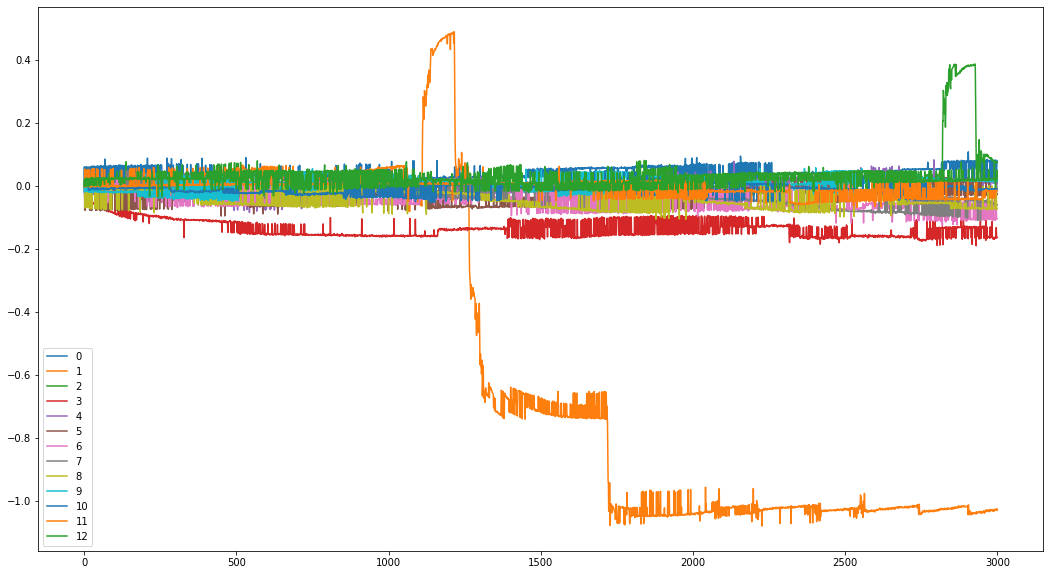

In [201]:
fig, ax = plt.subplots(1,1,figsize=(18,10))

plt.plot(pm_me_C0_50_0[:,4], label='0')
plt.plot(pm_me_C0_50_1[:,4], label='1')
plt.plot(pm_me_C0_50_2[:,4], label='2')
plt.plot(pm_me_C0_50_3[:,4], label='3')
plt.plot(pm_me_C0_50_4[:,4], label='4')
plt.plot(pm_me_C0_50_5[:,4], label='5')
plt.plot(pm_me_C0_50_6[:,4], label='6')
plt.plot(pm_me_C0_50_7[:,4], label='7')
plt.plot(pm_me_C0_50_8[:,4], label='8')
plt.plot(pm_me_C0_50_9[:,4], label='9')
plt.plot(pm_me_C0_50_10[:,4], label='10')
plt.plot(pm_me_C0_50_11[:,4], label='11')
plt.plot(pm_me_C0_50_12[:,4], label='12')

plt.legend()

## Combine Fish Data

In [202]:
pm_comb_me_0 = combine_fish_data(pm_me_C0_1_0,pm_me_C0_1_2,pm_me_C0_1_3,pm_me_C0_1_4,pm_me_C0_1_5,\
                               pm_me_C0_1_7,pm_me_C0_1_8,pm_me_C0_1_9,pm_me_C0_1_10,pm_me_C0_1_11,\
                               pm_me_C0_1_12,pm_me_C0_2_0,pm_me_C0_2_2,pm_me_C0_2_3,pm_me_C0_2_4,\
                               pm_me_C0_2_5,pm_me_C0_2_6,pm_me_C0_2_7,pm_me_C0_2_8,pm_me_C0_2_9,pm_me_C0_2_10,\
                               pm_me_C0_2_11,pm_me_C0_2_12,pm_me_C0_3_1,pm_me_C0_3_2,pm_me_C0_3_3,\
                               pm_me_C0_3_4,pm_me_C0_3_5,pm_me_C0_3_6,pm_me_C0_3_7,pm_me_C0_3_8,pm_me_C0_3_9,\
                               pm_me_C0_3_10,pm_me_C0_3_11,pm_me_C0_3_12,pm_me_C0_4_0,pm_me_C0_4_1,pm_me_C0_4_2,\
                               pm_me_C0_4_3,pm_me_C0_4_4,pm_me_C0_4_5,pm_me_C0_4_6,pm_me_C0_4_7,pm_me_C0_4_8,\
                               pm_me_C0_4_9,pm_me_C0_4_10,pm_me_C0_4_11,pm_me_C0_4_12,pm_me_C0_5_0,pm_me_C0_5_1,\
                               pm_me_C0_5_2,pm_me_C0_5_3,pm_me_C0_5_4,pm_me_C0_5_5,pm_me_C0_5_6,pm_me_C0_5_7,\
                               pm_me_C0_5_8,pm_me_C0_5_9,pm_me_C0_5_10,pm_me_C0_5_11,pm_me_C0_5_12,pm_me_C0_6_0,\
                               pm_me_C0_6_1,pm_me_C0_6_2,pm_me_C0_6_3,pm_me_C0_6_4,pm_me_C0_6_5,pm_me_C0_6_6,\
                               pm_me_C0_6_7,pm_me_C0_6_8,pm_me_C0_6_9,pm_me_C0_6_10,pm_me_C0_6_11,pm_me_C0_6_12,\
                               pm_me_C0_7_0,pm_me_C0_7_1,pm_me_C0_7_2,pm_me_C0_7_3,pm_me_C0_7_4,pm_me_C0_7_5,\
                               pm_me_C0_7_6,pm_me_C0_7_7,pm_me_C0_7_8,pm_me_C0_7_9,pm_me_C0_7_10,pm_me_C0_7_11,\
                               pm_me_C0_7_12,pm_me_C0_8_0,pm_me_C0_8_1,pm_me_C0_8_2,pm_me_C0_8_3,pm_me_C0_8_4,\
                               pm_me_C0_8_5,pm_me_C0_8_6,pm_me_C0_8_7,pm_me_C0_8_9,pm_me_C0_8_10,\
                               pm_me_C0_8_11,pm_me_C0_8_12,pm_me_C0_9_0,pm_me_C0_9_1,pm_me_C0_9_3,\
                               pm_me_C0_9_8,pm_me_C0_9_9,\
                               pm_me_C0_9_10,pm_me_C0_9_11,pm_me_C0_9_12,pm_me_C0_10_0,pm_me_C0_10_1,pm_me_C0_10_2,\
                               pm_me_C0_10_3,pm_me_C0_10_4,pm_me_C0_10_6,pm_me_C0_10_7,pm_me_C0_10_8,\
                               pm_me_C0_10_9,pm_me_C0_10_10,pm_me_C0_10_11,pm_me_C0_10_12,pm_me_C0_11_0,\
                               pm_me_C0_11_1,pm_me_C0_11_2,pm_me_C0_11_3,pm_me_C0_11_4,pm_me_C0_11_5,\
                               pm_me_C0_11_7,pm_me_C0_11_9,pm_me_C0_11_10,\
                               pm_me_C0_12_0,pm_me_C0_12_2,pm_me_C0_12_3,pm_me_C0_12_4,\
                               pm_me_C0_12_5,pm_me_C0_12_7,pm_me_C0_12_8,pm_me_C0_12_9,pm_me_C0_12_10,\
                               pm_me_C0_12_11,pm_me_C0_12_12,pm_me_C0_13_1,pm_me_C0_13_2,\
                               pm_me_C0_13_4,pm_me_C0_13_5,pm_me_C0_13_6,pm_me_C0_13_8,\
                               pm_me_C0_13_10,pm_me_C0_13_11,pm_me_C0_13_12,pm_me_C0_14_0,\
                               pm_me_C0_14_1,pm_me_C0_14_2,pm_me_C0_14_4,pm_me_C0_14_5,pm_me_C0_14_6,\
                               pm_me_C0_14_7,pm_me_C0_14_8,pm_me_C0_14_10,pm_me_C0_14_11,\
                               pm_me_C0_14_12,pm_me_C0_15_0,pm_me_C0_15_1,pm_me_C0_15_2,pm_me_C0_15_3,\
                               pm_me_C0_15_6,pm_me_C0_15_10,\
                               pm_me_C0_15_11,pm_me_C0_15_12,pm_me_C0_16_1,pm_me_C0_16_2,pm_me_C0_16_3,\
                               pm_me_C0_16_5,pm_me_C0_16_6,pm_me_C0_16_7,pm_me_C0_16_8,pm_me_C0_16_9,\
                               pm_me_C0_16_10,pm_me_C0_16_11,pm_me_C0_16_12,pm_me_C0_17_0,pm_me_C0_17_1,\
                               pm_me_C0_17_2,pm_me_C0_17_3,pm_me_C0_17_5,pm_me_C0_17_6,pm_me_C0_17_7,\
                               pm_me_C0_17_10,pm_me_C0_17_11,pm_me_C0_17_12,\
                               pm_me_C0_18_0,pm_me_C0_18_1,pm_me_C0_18_3,pm_me_C0_18_4,pm_me_C0_18_5,\
                               pm_me_C0_18_6,pm_me_C0_18_7,pm_me_C0_18_9,pm_me_C0_18_10,\
                               pm_me_C0_18_12,pm_me_C0_19_0,pm_me_C0_19_2,pm_me_C0_19_3,pm_me_C0_19_4,\
                               pm_me_C0_19_5,pm_me_C0_19_6,\
                               pm_me_C0_19_11,pm_me_C0_20_0,pm_me_C0_20_1,pm_me_C0_20_2,pm_me_C0_20_3,\
                               pm_me_C0_20_4,pm_me_C0_20_5,pm_me_C0_20_6,pm_me_C0_20_7,pm_me_C0_20_8,pm_me_C0_20_9,\
                               pm_me_C0_20_12,pm_me_C0_21_0,pm_me_C0_21_1,\
                               pm_me_C0_21_2,pm_me_C0_21_3,pm_me_C0_21_4,pm_me_C0_21_5,pm_me_C0_21_6,pm_me_C0_21_7,\
                               pm_me_C0_21_8,pm_me_C0_21_9,pm_me_C0_21_10,pm_me_C0_21_11,pm_me_C0_21_12,\
                               pm_me_C0_22_0,pm_me_C0_22_1,pm_me_C0_22_2,pm_me_C0_22_3,pm_me_C0_22_4,pm_me_C0_22_5,\
                               pm_me_C0_22_6,pm_me_C0_22_8,pm_me_C0_22_9,pm_me_C0_22_10,pm_me_C0_22_11,\
                               pm_me_C0_22_12,\
                               pm_me_C0_23_0,pm_me_C0_23_1,pm_me_C0_23_2,pm_me_C0_23_3,pm_me_C0_23_4,pm_me_C0_23_5,\
                               pm_me_C0_23_6,pm_me_C0_23_7,pm_me_C0_23_8,pm_me_C0_23_9,pm_me_C0_23_10,pm_me_C0_23_11,\
                               pm_me_C0_23_12,\
                               pm_me_C0_24_0,pm_me_C0_24_1,pm_me_C0_24_2,pm_me_C0_24_4,pm_me_C0_24_5,\
                               pm_me_C0_24_6,pm_me_C0_24_7,pm_me_C0_24_8,pm_me_C0_24_9,pm_me_C0_24_10,pm_me_C0_24_11,\
                               pm_me_C0_24_12,\
                               pm_me_C0_25_0,pm_me_C0_25_1,pm_me_C0_25_2,pm_me_C0_25_3,pm_me_C0_25_4,pm_me_C0_25_5,\
                               pm_me_C0_25_7,pm_me_C0_25_8,pm_me_C0_25_9,pm_me_C0_25_10,pm_me_C0_25_11,\
                               pm_me_C0_25_12,\
                               pm_me_C0_26_0,pm_me_C0_26_1,pm_me_C0_26_3,pm_me_C0_26_4,pm_me_C0_26_5,\
                               pm_me_C0_26_6,pm_me_C0_26_7,pm_me_C0_26_8,pm_me_C0_26_9,pm_me_C0_26_10,pm_me_C0_26_11,\
                               pm_me_C0_26_12,\
                               pm_me_C0_27_0,pm_me_C0_27_1,pm_me_C0_27_2,pm_me_C0_27_3,pm_me_C0_27_4,pm_me_C0_27_5,\
                               pm_me_C0_27_6,pm_me_C0_27_7,pm_me_C0_27_8,pm_me_C0_27_9,pm_me_C0_27_10,pm_me_C0_27_11,\
                               pm_me_C0_27_12,\
                               pm_me_C0_28_0,pm_me_C0_28_1,pm_me_C0_28_2,pm_me_C0_28_3,pm_me_C0_28_4,pm_me_C0_28_5,\
                               pm_me_C0_28_6,pm_me_C0_28_7,pm_me_C0_28_8,pm_me_C0_28_9,pm_me_C0_28_10,pm_me_C0_28_11,\
                               pm_me_C0_28_12,\
                               pm_me_C0_29_0,pm_me_C0_29_1,pm_me_C0_29_2,pm_me_C0_29_3,pm_me_C0_29_4,pm_me_C0_29_5,\
                               pm_me_C0_29_6,pm_me_C0_29_7,pm_me_C0_29_8,pm_me_C0_29_9,pm_me_C0_29_10,pm_me_C0_29_11,\
                               pm_me_C0_29_12,\
                               pm_me_C0_30_0,pm_me_C0_30_1,pm_me_C0_30_2,pm_me_C0_30_3,pm_me_C0_30_4,pm_me_C0_30_5,\
                               pm_me_C0_30_6,pm_me_C0_30_7,pm_me_C0_30_8,pm_me_C0_30_9,pm_me_C0_30_10,pm_me_C0_30_11,\
                               pm_me_C0_30_12,\
                               pm_me_C0_31_0,pm_me_C0_31_1,pm_me_C0_31_2,pm_me_C0_31_3,pm_me_C0_31_4,pm_me_C0_31_5,\
                               pm_me_C0_31_6,pm_me_C0_31_7,pm_me_C0_31_8,pm_me_C0_31_9,pm_me_C0_31_10,pm_me_C0_31_11,\
                               pm_me_C0_31_12,\
                               pm_me_C0_32_0,pm_me_C0_32_1,pm_me_C0_32_2,pm_me_C0_32_3,pm_me_C0_32_4,pm_me_C0_32_5,\
                               pm_me_C0_32_6,pm_me_C0_32_7,pm_me_C0_32_8,pm_me_C0_32_9,pm_me_C0_32_10,pm_me_C0_32_11,\
                               pm_me_C0_32_12,\
                               pm_me_C0_33_0,pm_me_C0_33_1,pm_me_C0_33_2,pm_me_C0_33_3,pm_me_C0_33_4,pm_me_C0_33_5,\
                               pm_me_C0_33_6,pm_me_C0_33_7,pm_me_C0_33_8,pm_me_C0_33_9,pm_me_C0_33_10,pm_me_C0_33_11,\
                               pm_me_C0_33_12,\
                                pm_me_C0_34_0,pm_me_C0_34_1,pm_me_C0_34_2,pm_me_C0_34_3,pm_me_C0_34_4,pm_me_C0_34_5,\
                               pm_me_C0_34_6,pm_me_C0_34_7,pm_me_C0_34_8,pm_me_C0_34_9,pm_me_C0_34_10,pm_me_C0_34_11,\
                               pm_me_C0_34_12,\
                                pm_me_C0_35_0,pm_me_C0_35_1,pm_me_C0_35_2,pm_me_C0_35_3,pm_me_C0_35_4,pm_me_C0_35_5,\
                               pm_me_C0_35_6,pm_me_C0_35_7,pm_me_C0_35_8,pm_me_C0_35_9,pm_me_C0_35_10,pm_me_C0_35_11,\
                               pm_me_C0_35_12,\
                                pm_me_C0_37_0,pm_me_C0_37_1,pm_me_C0_37_2,pm_me_C0_37_3,pm_me_C0_37_4,pm_me_C0_37_5,\
                               pm_me_C0_37_6,pm_me_C0_37_7,pm_me_C0_37_8,pm_me_C0_37_9,pm_me_C0_37_10,pm_me_C0_37_11,\
                               pm_me_C0_37_12,\
                                pm_me_C0_38_0,pm_me_C0_38_1,pm_me_C0_38_2,pm_me_C0_38_3,pm_me_C0_38_4,pm_me_C0_38_5,\
                               pm_me_C0_38_6,pm_me_C0_38_7,pm_me_C0_38_8,pm_me_C0_38_9,pm_me_C0_38_10,pm_me_C0_38_11,\
                               pm_me_C0_38_12,\
                                pm_me_C0_39_0,pm_me_C0_39_1,pm_me_C0_39_2,pm_me_C0_39_3,pm_me_C0_39_4,pm_me_C0_39_5,\
                               pm_me_C0_39_6,pm_me_C0_39_7,pm_me_C0_39_8,pm_me_C0_39_9,pm_me_C0_39_10,pm_me_C0_39_11,\
                               pm_me_C0_39_12,\
                                pm_me_C0_40_0,pm_me_C0_40_1,pm_me_C0_40_2,pm_me_C0_40_3,pm_me_C0_40_4,pm_me_C0_40_5,\
                               pm_me_C0_40_6,pm_me_C0_40_7,pm_me_C0_40_8,pm_me_C0_40_9,pm_me_C0_40_10,pm_me_C0_40_11,\
                               pm_me_C0_40_12,\
                                pm_me_C0_41_0,pm_me_C0_41_1,pm_me_C0_41_2,pm_me_C0_41_3,pm_me_C0_41_4,pm_me_C0_41_5,\
                               pm_me_C0_41_6,pm_me_C0_41_7,pm_me_C0_41_8,pm_me_C0_41_9,pm_me_C0_41_10,pm_me_C0_41_11,\
                               pm_me_C0_41_12,\
                                pm_me_C0_42_0,pm_me_C0_42_1,pm_me_C0_42_2,pm_me_C0_42_3,pm_me_C0_42_4,pm_me_C0_42_5,\
                               pm_me_C0_42_6,pm_me_C0_42_7,pm_me_C0_42_8,pm_me_C0_42_9,pm_me_C0_42_10,pm_me_C0_42_11,\
                               pm_me_C0_42_12,\
                                pm_me_C0_43_0,pm_me_C0_43_1,pm_me_C0_43_2,pm_me_C0_43_3,pm_me_C0_43_4,pm_me_C0_43_5,\
                               pm_me_C0_43_6,pm_me_C0_43_7,pm_me_C0_43_8,pm_me_C0_43_9,pm_me_C0_43_10,pm_me_C0_43_11,\
                               pm_me_C0_43_12,\
                                pm_me_C0_44_0,pm_me_C0_44_1,pm_me_C0_44_2,pm_me_C0_44_3,pm_me_C0_44_4,pm_me_C0_44_5,\
                               pm_me_C0_44_6,pm_me_C0_44_7,pm_me_C0_44_8,pm_me_C0_44_9,pm_me_C0_44_10,pm_me_C0_44_11,\
                               pm_me_C0_44_12,\
                                pm_me_C0_45_0,pm_me_C0_45_1,pm_me_C0_45_2,pm_me_C0_45_3,pm_me_C0_45_4,pm_me_C0_45_5,\
                               pm_me_C0_45_6,pm_me_C0_45_7,pm_me_C0_45_8,pm_me_C0_45_9,pm_me_C0_45_10,pm_me_C0_45_11,\
                               pm_me_C0_45_12,\
                                pm_me_C0_46_0,pm_me_C0_46_1,pm_me_C0_46_2,pm_me_C0_46_3,pm_me_C0_46_4,pm_me_C0_46_5,\
                               pm_me_C0_46_6,pm_me_C0_46_7,pm_me_C0_46_8,pm_me_C0_46_9,pm_me_C0_46_10,pm_me_C0_46_11,\
                               pm_me_C0_46_12,\
                                pm_me_C0_47_0,pm_me_C0_47_1,pm_me_C0_47_2,pm_me_C0_47_3,pm_me_C0_47_4,pm_me_C0_47_5,\
                               pm_me_C0_47_6,pm_me_C0_47_7,pm_me_C0_47_8,pm_me_C0_47_9,pm_me_C0_47_10,pm_me_C0_47_11,\
                               pm_me_C0_47_12,\
                                pm_me_C0_48_0,pm_me_C0_48_1,pm_me_C0_48_2,pm_me_C0_48_3,pm_me_C0_48_4,pm_me_C0_48_5,\
                               pm_me_C0_48_6,pm_me_C0_48_7,pm_me_C0_48_8,pm_me_C0_48_9,pm_me_C0_48_10,pm_me_C0_48_11,\
                               pm_me_C0_48_12,\
                                pm_me_C0_49_0,pm_me_C0_49_1,pm_me_C0_49_2,pm_me_C0_49_3,pm_me_C0_49_4,pm_me_C0_49_5,\
                               pm_me_C0_49_6,pm_me_C0_49_7,pm_me_C0_49_8,pm_me_C0_49_9,pm_me_C0_49_10,pm_me_C0_49_11,\
                               pm_me_C0_49_12,\
                                pm_me_C0_50_0,pm_me_C0_50_1,pm_me_C0_50_2,pm_me_C0_50_3,pm_me_C0_50_4,pm_me_C0_50_5,\
                               pm_me_C0_50_6,pm_me_C0_50_7,pm_me_C0_50_8,pm_me_C0_50_9,pm_me_C0_50_10,pm_me_C0_50_11,\
                               pm_me_C0_50_12)

In [203]:
pm_comb_e_0 = combine_fish_data(pm_e_C0_1_0,pm_e_C0_1_1,pm_e_C0_1_2,pm_e_C0_1_3,pm_e_C0_1_4,pm_e_C0_1_5,pm_e_C0_1_6,\
                              pm_e_C0_1_7,pm_e_C0_1_8,pm_e_C0_1_9,pm_e_C0_1_10,pm_e_C0_1_11,pm_e_C0_1_12,\
                              pm_e_C0_2_0,pm_e_C0_2_1,pm_e_C0_2_2,pm_e_C0_2_3,pm_e_C0_2_4,pm_e_C0_2_5,pm_e_C0_2_6,\
                              pm_e_C0_2_7,pm_e_C0_2_8,pm_e_C0_2_9,pm_e_C0_2_10,pm_e_C0_2_12,\
                              pm_e_C0_3_1,pm_e_C0_3_2,pm_e_C0_3_3,pm_e_C0_3_4,pm_e_C0_3_6,\
                              pm_e_C0_3_7,pm_e_C0_3_8,pm_e_C0_3_9,pm_e_C0_3_10,pm_e_C0_3_11,pm_e_C0_3_12,\
                              pm_e_C0_4_0,pm_e_C0_4_1,pm_e_C0_4_2,pm_e_C0_4_3,pm_e_C0_4_4,pm_e_C0_4_5,pm_e_C0_4_6,\
                              pm_e_C0_4_7,pm_e_C0_4_8,pm_e_C0_4_9,pm_e_C0_4_10,pm_e_C0_4_11,pm_e_C0_4_12,\
                              pm_e_C0_5_0,pm_e_C0_5_1,pm_e_C0_5_2,pm_e_C0_5_3,pm_e_C0_5_4,pm_e_C0_5_5,pm_e_C0_5_6,\
                              pm_e_C0_5_7,pm_e_C0_5_8,pm_e_C0_5_9,pm_e_C0_5_10,pm_e_C0_5_11,pm_e_C0_5_12,\
                              pm_e_C0_6_0,pm_e_C0_6_1,pm_e_C0_6_2,pm_e_C0_6_3,pm_e_C0_6_4,pm_e_C0_6_5,pm_e_C0_6_6,\
                              pm_e_C0_6_7,pm_e_C0_6_8,pm_e_C0_6_9,pm_e_C0_6_10,pm_e_C0_6_11,pm_e_C0_6_12,\
                              pm_e_C0_7_0,pm_e_C0_7_1,pm_e_C0_7_2,pm_e_C0_7_3,pm_e_C0_7_4,pm_e_C0_7_5,\
                              pm_e_C0_7_7,pm_e_C0_7_9,pm_e_C0_7_10,pm_e_C0_7_11,pm_e_C0_7_12,\
                              pm_e_C0_9_1,pm_e_C0_9_3,pm_e_C0_9_5,\
                              pm_e_C0_9_7,pm_e_C0_9_10,pm_e_C0_9_11,pm_e_C0_9_12,\
                              pm_e_C0_10_0,pm_e_C0_10_1,pm_e_C0_10_2,pm_e_C0_10_3,pm_e_C0_10_4,pm_e_C0_10_5,\
                              pm_e_C0_10_6,pm_e_C0_10_8,pm_e_C0_10_9,pm_e_C0_10_10,pm_e_C0_10_11,\
                              pm_e_C0_10_12,pm_e_C0_11_0,pm_e_C0_11_1,pm_e_C0_11_2,pm_e_C0_11_3,pm_e_C0_11_4,\
                              pm_e_C0_11_5,pm_e_C0_11_6,pm_e_C0_11_7,pm_e_C0_11_8,pm_e_C0_11_9,pm_e_C0_11_10,\
                              pm_e_C0_11_11,pm_e_C0_11_12,pm_e_C0_12_0,pm_e_C0_12_1,pm_e_C0_12_2,pm_e_C0_12_3,\
                              pm_e_C0_12_4,pm_e_C0_12_5,pm_e_C0_12_6,pm_e_C0_12_7,pm_e_C0_12_8,\
                              pm_e_C0_12_10,pm_e_C0_13_0,pm_e_C0_13_2,\
                              pm_e_C0_13_4,pm_e_C0_13_5,pm_e_C0_13_6,pm_e_C0_13_7,pm_e_C0_13_8,\
                              pm_e_C0_13_9,pm_e_C0_13_10,pm_e_C0_13_11,pm_e_C0_13_12,pm_e_C0_14_1,\
                              pm_e_C0_14_2,pm_e_C0_14_3,pm_e_C0_14_4,pm_e_C0_14_6,pm_e_C0_14_7,\
                              pm_e_C0_14_8,pm_e_C0_14_9,pm_e_C0_14_10,pm_e_C0_14_11,pm_e_C0_15_0,\
                              pm_e_C0_15_1,pm_e_C0_15_2,pm_e_C0_15_4,pm_e_C0_15_5,\
                              pm_e_C0_15_7,pm_e_C0_15_12,\
                              pm_e_C0_16_1,pm_e_C0_16_3,pm_e_C0_16_5,\
                              pm_e_C0_16_6,pm_e_C0_16_7,pm_e_C0_16_9,pm_e_C0_16_10,pm_e_C0_16_11,\
                              pm_e_C0_16_12,pm_e_C0_17_0,pm_e_C0_17_1,pm_e_C0_17_2,pm_e_C0_17_4,\
                              pm_e_C0_17_5,pm_e_C0_17_6,pm_e_C0_17_7,pm_e_C0_17_8,pm_e_C0_17_9,pm_e_C0_17_10,\
                              pm_e_C0_17_11,pm_e_C0_17_12,pm_e_C0_18_0,pm_e_C0_18_1,pm_e_C0_18_2,pm_e_C0_18_3,\
                              pm_e_C0_18_4,pm_e_C0_18_5,pm_e_C0_18_7,pm_e_C0_18_8,pm_e_C0_18_9,\
                              pm_e_C0_18_10,pm_e_C0_18_11,pm_e_C0_18_12,\
                              pm_e_C0_19_0,pm_e_C0_19_1,pm_e_C0_19_2,pm_e_C0_19_3,pm_e_C0_19_4,pm_e_C0_19_5,\
                              pm_e_C0_19_6,pm_e_C0_19_7,pm_e_C0_19_8,pm_e_C0_19_9,pm_e_C0_19_10,pm_e_C0_19_11,\
                              pm_e_C0_19_12,\
                              pm_e_C0_20_0,pm_e_C0_20_1,pm_e_C0_20_2,pm_e_C0_20_3,pm_e_C0_20_4,pm_e_C0_20_5,\
                              pm_e_C0_20_6,pm_e_C0_20_7,pm_e_C0_20_8,pm_e_C0_20_9,pm_e_C0_20_10,pm_e_C0_20_11,\
                              pm_e_C0_20_12,\
                              pm_e_C0_21_0,pm_e_C0_21_1,pm_e_C0_21_2,pm_e_C0_21_3,pm_e_C0_21_4,pm_e_C0_21_5,\
                              pm_e_C0_21_6,pm_e_C0_21_7,pm_e_C0_21_8,pm_e_C0_21_9,pm_e_C0_21_10,pm_e_C0_21_11,\
                              pm_e_C0_21_12,\
                              pm_e_C0_22_0,pm_e_C0_22_1,pm_e_C0_22_2,pm_e_C0_22_3,pm_e_C0_22_4,pm_e_C0_22_5,\
                              pm_e_C0_22_6,pm_e_C0_22_8,pm_e_C0_22_9,pm_e_C0_22_10,pm_e_C0_22_11,pm_e_C0_22_12,\
                              pm_e_C0_23_0,pm_e_C0_23_1,pm_e_C0_23_2,pm_e_C0_23_3,pm_e_C0_23_4,pm_e_C0_23_5,\
                              pm_e_C0_23_6,pm_e_C0_23_7,pm_e_C0_23_8,pm_e_C0_23_9,pm_e_C0_23_10,pm_e_C0_23_11,\
                              pm_e_C0_23_12,\
                              pm_e_C0_24_0,pm_e_C0_24_1,pm_e_C0_24_2,pm_e_C0_24_3,pm_e_C0_24_4,pm_e_C0_24_5,\
                              pm_e_C0_24_6,pm_e_C0_24_7,pm_e_C0_24_8,pm_e_C0_24_9,pm_e_C0_24_10,pm_e_C0_24_11,\
                              pm_e_C0_24_12,\
                              pm_e_C0_25_0,pm_e_C0_25_1,pm_e_C0_25_2,pm_e_C0_25_3,pm_e_C0_25_4,pm_e_C0_25_5,\
                              pm_e_C0_25_6,pm_e_C0_25_7,pm_e_C0_25_8,pm_e_C0_25_9,pm_e_C0_25_10,pm_e_C0_25_11,\
                              pm_e_C0_25_12,\
                              pm_e_C0_26_0,pm_e_C0_26_1,pm_e_C0_26_3,pm_e_C0_26_4,pm_e_C0_26_5,\
                              pm_e_C0_26_6,pm_e_C0_26_7,pm_e_C0_26_9,pm_e_C0_26_10,pm_e_C0_26_11,pm_e_C0_26_12,\
                              pm_e_C0_27_0,pm_e_C0_27_1,pm_e_C0_27_2,pm_e_C0_27_3,pm_e_C0_27_4,pm_e_C0_27_5,\
                              pm_e_C0_27_6,pm_e_C0_27_7,pm_e_C0_27_8,pm_e_C0_27_9,pm_e_C0_27_10,pm_e_C0_27_11,\
                              pm_e_C0_27_12,\
                              pm_e_C0_28_0,pm_e_C0_28_1,pm_e_C0_28_2,pm_e_C0_28_3,pm_e_C0_28_4,pm_e_C0_28_5,\
                              pm_e_C0_28_6,pm_e_C0_28_7,pm_e_C0_28_8,pm_e_C0_28_9,pm_e_C0_28_10,pm_e_C0_28_11,\
                              pm_e_C0_28_12,\
                              pm_e_C0_29_0,pm_e_C0_29_1,pm_e_C0_29_2,pm_e_C0_29_3,pm_e_C0_29_4,pm_e_C0_29_5,\
                              pm_e_C0_29_6,pm_e_C0_29_7,pm_e_C0_29_8,pm_e_C0_29_9,pm_e_C0_29_10,pm_e_C0_29_11,\
                              pm_e_C0_29_12,\
                              pm_e_C0_30_0,pm_e_C0_30_1,pm_e_C0_30_2,pm_e_C0_30_3,pm_e_C0_30_4,pm_e_C0_30_5,\
                              pm_e_C0_30_6,pm_e_C0_30_7,pm_e_C0_30_8,pm_e_C0_30_9,pm_e_C0_30_10,pm_e_C0_30_11,\
                              pm_e_C0_30_12,\
                              pm_e_C0_31_0,pm_e_C0_31_1,pm_e_C0_31_2,pm_e_C0_31_3,pm_e_C0_31_4,pm_e_C0_31_5,\
                              pm_e_C0_31_6,pm_e_C0_31_7,pm_e_C0_31_8,pm_e_C0_31_9,pm_e_C0_31_10,pm_e_C0_31_11,\
                              pm_e_C0_31_12,\
                              pm_e_C0_32_0,pm_e_C0_32_1,pm_e_C0_32_2,pm_e_C0_32_3,pm_e_C0_32_4,pm_e_C0_32_5,\
                              pm_e_C0_32_6,pm_e_C0_32_7,pm_e_C0_32_8,pm_e_C0_32_9,pm_e_C0_32_10,pm_e_C0_32_11,\
                              pm_e_C0_32_12,\
                              pm_e_C0_33_0,pm_e_C0_33_1,pm_e_C0_33_2,pm_e_C0_33_3,pm_e_C0_33_4,pm_e_C0_33_5,\
                              pm_e_C0_33_6,pm_e_C0_33_7,pm_e_C0_33_8,pm_e_C0_33_9,pm_e_C0_33_10,pm_e_C0_33_11,\
                              pm_e_C0_33_12,\
                              pm_e_C0_34_0,pm_e_C0_34_1,pm_e_C0_34_2,pm_e_C0_34_3,pm_e_C0_34_4,pm_e_C0_34_5,\
                              pm_e_C0_34_6,pm_e_C0_34_7,pm_e_C0_34_8,pm_e_C0_34_9,pm_e_C0_34_10,pm_e_C0_34_11,\
                              pm_e_C0_34_12,\
                              pm_e_C0_35_0,pm_e_C0_35_1,pm_e_C0_35_2,pm_e_C0_35_3,pm_e_C0_35_4,pm_e_C0_35_5,\
                              pm_e_C0_35_6,pm_e_C0_35_7,pm_e_C0_35_8,pm_e_C0_35_9,pm_e_C0_35_10,pm_e_C0_35_11,\
                              pm_e_C0_35_12,\
                              pm_e_C0_36_0,pm_e_C0_36_1,pm_e_C0_36_2,pm_e_C0_36_3,pm_e_C0_36_4,pm_e_C0_36_5,\
                              pm_e_C0_36_6,pm_e_C0_36_7,pm_e_C0_36_8,pm_e_C0_36_9,pm_e_C0_36_10,pm_e_C0_36_11,\
                              pm_e_C0_36_12,\
                              pm_e_C0_37_0,pm_e_C0_37_1,pm_e_C0_37_2,pm_e_C0_37_3,pm_e_C0_37_4,pm_e_C0_37_5,\
                              pm_e_C0_37_6,pm_e_C0_37_7,pm_e_C0_37_8,pm_e_C0_37_9,pm_e_C0_37_10,pm_e_C0_37_11,\
                              pm_e_C0_37_12,\
                              pm_e_C0_38_0,pm_e_C0_38_1,pm_e_C0_38_2,pm_e_C0_38_3,pm_e_C0_38_4,pm_e_C0_38_5,\
                              pm_e_C0_38_6,pm_e_C0_38_7,pm_e_C0_38_8,pm_e_C0_38_9,pm_e_C0_38_10,pm_e_C0_38_11,\
                              pm_e_C0_38_12,\
                              pm_e_C0_39_0,pm_e_C0_39_1,pm_e_C0_39_2,pm_e_C0_39_3,pm_e_C0_39_4,pm_e_C0_39_5,\
                              pm_e_C0_39_6,pm_e_C0_39_7,pm_e_C0_39_8,pm_e_C0_39_9,pm_e_C0_39_10,pm_e_C0_39_11,\
                              pm_e_C0_39_12,\
                              pm_e_C0_40_0,pm_e_C0_40_1,pm_e_C0_40_2,pm_e_C0_40_3,pm_e_C0_40_4,pm_e_C0_40_5,\
                              pm_e_C0_40_6,pm_e_C0_40_7,pm_e_C0_40_8,pm_e_C0_40_9,pm_e_C0_40_10,pm_e_C0_40_11,\
                              pm_e_C0_40_12,\
                              pm_e_C0_41_0,pm_e_C0_41_1,pm_e_C0_41_2,pm_e_C0_41_3,pm_e_C0_41_4,pm_e_C0_41_5,\
                              pm_e_C0_41_6,pm_e_C0_41_7,pm_e_C0_41_8,pm_e_C0_41_9,pm_e_C0_41_10,pm_e_C0_41_11,\
                              pm_e_C0_41_12,\
                              pm_e_C0_42_0,pm_e_C0_42_1,pm_e_C0_42_2,pm_e_C0_42_3,pm_e_C0_42_4,pm_e_C0_42_5,\
                              pm_e_C0_42_6,pm_e_C0_42_7,pm_e_C0_42_8,pm_e_C0_42_9,pm_e_C0_42_10,pm_e_C0_42_11,\
                              pm_e_C0_42_12,\
                              pm_e_C0_43_0,pm_e_C0_43_1,pm_e_C0_43_2,pm_e_C0_43_3,pm_e_C0_43_4,pm_e_C0_43_5,\
                              pm_e_C0_43_6,pm_e_C0_43_7,pm_e_C0_43_8,pm_e_C0_43_9,pm_e_C0_43_10,pm_e_C0_43_11,\
                              pm_e_C0_43_12,\
                              pm_e_C0_44_0,pm_e_C0_44_1,pm_e_C0_44_2,pm_e_C0_44_3,pm_e_C0_44_4,pm_e_C0_44_5,\
                              pm_e_C0_44_6,pm_e_C0_44_7,pm_e_C0_44_8,pm_e_C0_44_9,pm_e_C0_44_10,pm_e_C0_44_11,\
                              pm_e_C0_44_12,\
                              pm_e_C0_45_0,pm_e_C0_45_1,pm_e_C0_45_2,pm_e_C0_45_3,pm_e_C0_45_4,pm_e_C0_45_5,\
                              pm_e_C0_45_6,pm_e_C0_45_7,pm_e_C0_45_8,pm_e_C0_45_9,pm_e_C0_45_10,pm_e_C0_45_11,\
                              pm_e_C0_45_12,\
                              pm_e_C0_46_0,pm_e_C0_46_1,pm_e_C0_46_2,pm_e_C0_46_3,pm_e_C0_46_4,pm_e_C0_46_5,\
                              pm_e_C0_46_6,pm_e_C0_46_7,pm_e_C0_46_8,pm_e_C0_46_9,pm_e_C0_46_10,pm_e_C0_46_11,\
                              pm_e_C0_46_12,\
                              pm_e_C0_47_0,pm_e_C0_47_1,pm_e_C0_47_2,pm_e_C0_47_3,pm_e_C0_47_4,pm_e_C0_47_5,\
                              pm_e_C0_47_6,pm_e_C0_47_7,pm_e_C0_47_8,pm_e_C0_47_9,pm_e_C0_47_10,pm_e_C0_47_11,\
                              pm_e_C0_47_12,\
                              pm_e_C0_48_0,pm_e_C0_48_1,pm_e_C0_48_2,pm_e_C0_48_3,pm_e_C0_48_4,pm_e_C0_48_5,\
                              pm_e_C0_48_6,pm_e_C0_48_7,pm_e_C0_48_8,pm_e_C0_48_9,pm_e_C0_48_10,pm_e_C0_48_11,\
                              pm_e_C0_48_12,\
                              pm_e_C0_49_0,pm_e_C0_49_1,pm_e_C0_49_2,pm_e_C0_49_3,pm_e_C0_49_4,pm_e_C0_49_5,\
                              pm_e_C0_49_6,pm_e_C0_49_7,pm_e_C0_49_8,pm_e_C0_49_9,pm_e_C0_49_10,pm_e_C0_49_11,\
                              pm_e_C0_49_12,\
                              pm_e_C0_50_0,pm_e_C0_50_1,pm_e_C0_50_2,pm_e_C0_50_3,pm_e_C0_50_4,pm_e_C0_50_5,\
                              pm_e_C0_50_6,pm_e_C0_50_7,pm_e_C0_50_8,pm_e_C0_50_9,pm_e_C0_50_10,pm_e_C0_50_11,\
                              pm_e_C0_50_12)

In [204]:
am_comb_me_0 = combine_fish_data(am_me_C0_1_0,am_me_C0_1_1,am_me_C0_1_2,am_me_C0_1_3,am_me_C0_1_4,am_me_C0_1_5,\
                               am_me_C0_1_6,am_me_C0_1_7,am_me_C0_1_8,am_me_C0_1_9,am_me_C0_1_10,am_me_C0_1_11,\
                               am_me_C0_1_12,am_me_C0_2_0,am_me_C0_2_2,am_me_C0_2_3,am_me_C0_2_4,\
                               am_me_C0_2_5,am_me_C0_2_6,am_me_C0_2_7,am_me_C0_2_8,am_me_C0_2_10,\
                               am_me_C0_2_11,am_me_C0_2_12,am_me_C0_3_0,am_me_C0_3_1,am_me_C0_3_2,am_me_C0_3_3,\
                               am_me_C0_3_4,am_me_C0_3_5,am_me_C0_3_6,am_me_C0_3_7,am_me_C0_3_8,am_me_C0_3_9,\
                               am_me_C0_3_10,am_me_C0_3_11,am_me_C0_3_12,am_me_C0_4_0,am_me_C0_4_1,am_me_C0_4_2,\
                               am_me_C0_4_3,am_me_C0_4_4,am_me_C0_4_5,am_me_C0_4_6,am_me_C0_4_7,am_me_C0_4_8,\
                               am_me_C0_4_9,am_me_C0_4_11,am_me_C0_5_0,am_me_C0_5_1,\
                               am_me_C0_5_3,am_me_C0_5_5,am_me_C0_5_6,am_me_C0_5_7,\
                               am_me_C0_5_8,am_me_C0_5_9,am_me_C0_5_11,am_me_C0_5_12,am_me_C0_6_0,\
                               am_me_C0_6_1,am_me_C0_6_2,am_me_C0_6_3,am_me_C0_6_4,am_me_C0_6_5,am_me_C0_6_6,\
                               am_me_C0_6_7,am_me_C0_6_8,am_me_C0_6_9,am_me_C0_6_10,am_me_C0_6_11,am_me_C0_6_12,\
                               am_me_C0_7_0,am_me_C0_7_1,am_me_C0_7_2,am_me_C0_7_3,am_me_C0_7_4,\
                               am_me_C0_7_6,am_me_C0_7_7,am_me_C0_7_8,am_me_C0_7_9,am_me_C0_7_10,am_me_C0_7_11,\
                               am_me_C0_7_12,am_me_C0_8_0,am_me_C0_8_2,am_me_C0_8_3,am_me_C0_8_4,\
                               am_me_C0_8_5,am_me_C0_8_9,am_me_C0_8_10,\
                               am_me_C0_8_12,am_me_C0_10_0,\
                               am_me_C0_10_3,am_me_C0_10_5,am_me_C0_10_7,am_me_C0_10_8,\
                               am_me_C0_10_10,am_me_C0_10_11,am_me_C0_10_12,\
                               am_me_C0_11_1,am_me_C0_11_2,am_me_C0_11_3,am_me_C0_11_4,am_me_C0_11_6,\
                               am_me_C0_11_7,am_me_C0_11_8,am_me_C0_11_9,am_me_C0_11_10,am_me_C0_11_11,\
                               am_me_C0_11_12,am_me_C0_12_0,am_me_C0_12_1,am_me_C0_12_2,am_me_C0_12_3,\
                               am_me_C0_12_5,am_me_C0_12_7,am_me_C0_12_8,\
                               am_me_C0_12_12,am_me_C0_13_0,am_me_C0_13_1,am_me_C0_13_2,\
                               am_me_C0_13_3,am_me_C0_13_4,am_me_C0_13_5,am_me_C0_13_6,am_me_C0_13_7,am_me_C0_13_8,\
                               am_me_C0_13_10,am_me_C0_13_11,am_me_C0_13_12,am_me_C0_14_0,\
                               am_me_C0_14_1,am_me_C0_14_2,am_me_C0_14_3,am_me_C0_14_4,am_me_C0_14_5,am_me_C0_14_6,\
                               am_me_C0_14_7,am_me_C0_14_8,am_me_C0_14_9,am_me_C0_14_10,am_me_C0_14_11,\
                               am_me_C0_14_12,am_me_C0_15_0,am_me_C0_15_1,am_me_C0_15_2,am_me_C0_15_3,am_me_C0_15_4,\
                               am_me_C0_15_5,am_me_C0_15_6,am_me_C0_15_7,am_me_C0_15_9,am_me_C0_15_10,\
                               am_me_C0_15_11,am_me_C0_15_12,am_me_C0_16_0,am_me_C0_16_1,am_me_C0_16_2,am_me_C0_16_3,\
                               am_me_C0_16_4,am_me_C0_16_5,am_me_C0_16_6,am_me_C0_16_7,am_me_C0_16_8,am_me_C0_16_9,\
                               am_me_C0_16_10,am_me_C0_16_11,am_me_C0_16_12,am_me_C0_17_0,am_me_C0_17_1,\
                               am_me_C0_17_2,am_me_C0_17_3,am_me_C0_17_4,am_me_C0_17_5,am_me_C0_17_6,am_me_C0_17_7,\
                               am_me_C0_17_8,am_me_C0_17_9,am_me_C0_17_10,am_me_C0_17_11,am_me_C0_17_12,\
                               am_me_C0_18_0,am_me_C0_18_1,am_me_C0_18_2,am_me_C0_18_3,am_me_C0_18_4,am_me_C0_18_5,\
                               am_me_C0_18_6,am_me_C0_18_7,am_me_C0_18_8,am_me_C0_18_9,am_me_C0_18_10,am_me_C0_18_11,\
                               am_me_C0_18_12,\
                               am_me_C0_19_0,am_me_C0_19_1,am_me_C0_19_2,am_me_C0_19_3,am_me_C0_19_4,am_me_C0_19_5,\
                               am_me_C0_19_6,am_me_C0_19_7,am_me_C0_19_8,am_me_C0_19_9,am_me_C0_19_10,am_me_C0_19_11,\
                               am_me_C0_19_12,\
                               am_me_C0_20_0,am_me_C0_20_1,am_me_C0_20_2,am_me_C0_20_3,am_me_C0_20_4,am_me_C0_20_5,\
                               am_me_C0_20_6,am_me_C0_20_7,am_me_C0_20_8,am_me_C0_20_9,am_me_C0_20_10,am_me_C0_20_11,\
                               am_me_C0_20_12,\
                               am_me_C0_21_0,am_me_C0_21_1,am_me_C0_21_2,am_me_C0_21_3,am_me_C0_21_4,am_me_C0_21_5,\
                               am_me_C0_21_7,am_me_C0_21_8,am_me_C0_21_9,am_me_C0_21_10,am_me_C0_21_11,\
                               am_me_C0_21_12,\
                               am_me_C0_22_0,am_me_C0_22_1,am_me_C0_22_3,am_me_C0_22_4,am_me_C0_22_5,\
                               am_me_C0_22_6,am_me_C0_22_7,am_me_C0_22_8,am_me_C0_22_9,am_me_C0_22_10,am_me_C0_22_11,\
                               am_me_C0_22_12,\
                               am_me_C0_23_0,am_me_C0_23_1,am_me_C0_23_2,am_me_C0_23_3,am_me_C0_23_4,am_me_C0_23_5,\
                               am_me_C0_23_6,am_me_C0_23_7,am_me_C0_23_8,am_me_C0_23_9,am_me_C0_23_10,am_me_C0_23_11,\
                               am_me_C0_23_12,\
                               am_me_C0_24_0,am_me_C0_24_1,am_me_C0_24_2,am_me_C0_24_3,am_me_C0_24_4,am_me_C0_24_5,\
                               am_me_C0_24_6,am_me_C0_24_7,am_me_C0_24_8,am_me_C0_24_9,am_me_C0_24_10,am_me_C0_24_11,\
                               am_me_C0_24_12,\
                               am_me_C0_25_0,am_me_C0_25_1,am_me_C0_25_3,am_me_C0_25_4,am_me_C0_25_5,\
                               am_me_C0_25_6,am_me_C0_25_7,am_me_C0_25_8,am_me_C0_25_9,am_me_C0_25_10,am_me_C0_25_11,\
                               am_me_C0_26_0,am_me_C0_26_1,am_me_C0_26_2,am_me_C0_26_3,am_me_C0_26_4,am_me_C0_26_5,\
                               am_me_C0_26_6,am_me_C0_26_7,am_me_C0_26_8,am_me_C0_26_9,am_me_C0_26_10,am_me_C0_26_11,\
                               am_me_C0_26_12,\
                               am_me_C0_27_0,am_me_C0_27_1,am_me_C0_27_2,am_me_C0_27_3,am_me_C0_27_4,am_me_C0_27_5,\
                               am_me_C0_27_6,am_me_C0_27_7,am_me_C0_27_8,am_me_C0_27_9,am_me_C0_27_10,am_me_C0_27_11,\
                               am_me_C0_27_12,\
                               am_me_C0_28_0,am_me_C0_28_1,am_me_C0_28_2,am_me_C0_28_3,am_me_C0_28_4,am_me_C0_28_5,\
                               am_me_C0_28_6,am_me_C0_28_7,am_me_C0_28_8,am_me_C0_28_9,am_me_C0_28_10,am_me_C0_28_11,\
                               am_me_C0_28_12,\
                               am_me_C0_29_0,am_me_C0_29_1,am_me_C0_29_2,am_me_C0_29_3,am_me_C0_29_4,am_me_C0_29_5,\
                               am_me_C0_29_6,am_me_C0_29_7,am_me_C0_29_8,am_me_C0_29_9,am_me_C0_29_10,am_me_C0_29_11,\
                               am_me_C0_29_12,\
                               am_me_C0_30_0,am_me_C0_30_1,am_me_C0_30_2,am_me_C0_30_3,am_me_C0_30_4,am_me_C0_30_5,\
                               am_me_C0_30_6,am_me_C0_30_7,am_me_C0_30_8,am_me_C0_30_9,am_me_C0_30_10,am_me_C0_30_11,\
                               am_me_C0_30_12,\
                               am_me_C0_31_0,am_me_C0_31_1,am_me_C0_31_2,am_me_C0_31_3,am_me_C0_31_4,am_me_C0_31_5,\
                               am_me_C0_31_6,am_me_C0_31_7,am_me_C0_31_8,am_me_C0_31_9,am_me_C0_31_10,am_me_C0_31_11,\
                               am_me_C0_31_12,\
                               am_me_C0_32_0,am_me_C0_32_1,am_me_C0_32_2,am_me_C0_32_3,am_me_C0_32_4,am_me_C0_32_5,\
                               am_me_C0_32_6,am_me_C0_32_7,am_me_C0_32_8,am_me_C0_32_9,am_me_C0_32_10,am_me_C0_32_11,\
                               am_me_C0_32_12,\
                               am_me_C0_33_0,am_me_C0_33_1,am_me_C0_33_2,am_me_C0_33_3,am_me_C0_33_4,am_me_C0_33_5,\
                               am_me_C0_33_6,am_me_C0_33_7,am_me_C0_33_8,am_me_C0_33_9,am_me_C0_33_10,am_me_C0_33_11,\
                               am_me_C0_33_12,\
                               am_me_C0_34_0,am_me_C0_34_1,am_me_C0_34_2,am_me_C0_34_3,am_me_C0_34_4,am_me_C0_34_5,\
                               am_me_C0_34_6,am_me_C0_34_7,am_me_C0_34_8,am_me_C0_34_9,am_me_C0_34_10,am_me_C0_34_11,\
                               am_me_C0_34_12,\
                               am_me_C0_35_0,am_me_C0_35_1,am_me_C0_35_2,am_me_C0_35_3,am_me_C0_35_4,am_me_C0_35_5,\
                               am_me_C0_35_6,am_me_C0_35_7,am_me_C0_35_8,am_me_C0_35_9,am_me_C0_35_10,am_me_C0_35_11,\
                               am_me_C0_35_12)

In [205]:
am_comb_e_0 = combine_fish_data(am_e_C0_1_0,am_e_C0_1_1,am_e_C0_1_4,am_e_C0_1_5,\
                              am_e_C0_1_7,am_e_C0_1_9,am_e_C0_1_12,\
                              am_e_C0_2_1,am_e_C0_2_2,am_e_C0_2_3,am_e_C0_2_4,am_e_C0_2_6,\
                              am_e_C0_2_7,am_e_C0_2_8,am_e_C0_2_9,am_e_C0_2_11,am_e_C0_2_12,\
                              am_e_C0_3_0,am_e_C0_3_1,am_e_C0_3_2,am_e_C0_3_3,am_e_C0_3_5,am_e_C0_3_6,\
                              am_e_C0_3_7,am_e_C0_3_8,am_e_C0_3_12,\
                              am_e_C0_4_1,am_e_C0_4_2,am_e_C0_4_3,am_e_C0_4_4,am_e_C0_4_5,am_e_C0_4_6,\
                              am_e_C0_4_7,am_e_C0_4_8,am_e_C0_4_9,am_e_C0_4_10,am_e_C0_4_11,am_e_C0_4_1,\
                              am_e_C0_6_0,am_e_C0_6_1,am_e_C0_6_2,am_e_C0_6_3,am_e_C0_6_4,am_e_C0_6_5,am_e_C0_6_6,\
                              am_e_C0_6_7,am_e_C0_6_9,am_e_C0_6_10,am_e_C0_6_11,am_e_C0_6_12,\
                              am_e_C0_7_0,am_e_C0_7_1,am_e_C0_7_2,am_e_C0_7_3,am_e_C0_7_4,am_e_C0_7_5,am_e_C0_7_6,\
                              am_e_C0_7_7,am_e_C0_7_9,am_e_C0_7_10,am_e_C0_7_12,\
                              am_e_C0_8_0,am_e_C0_8_1,am_e_C0_8_2,am_e_C0_8_3,am_e_C0_8_4,am_e_C0_8_5,am_e_C0_8_6,\
                              am_e_C0_8_7,am_e_C0_8_8,am_e_C0_8_9,am_e_C0_8_11,am_e_C0_8_12,\
                              am_e_C0_9_0,am_e_C0_9_1,am_e_C0_9_2,am_e_C0_9_3,am_e_C0_9_4,am_e_C0_9_5,am_e_C0_9_6,\
                              am_e_C0_9_7,am_e_C0_9_10,am_e_C0_9_11,am_e_C0_9_12,\
                              am_e_C0_10_3,am_e_C0_10_7,am_e_C0_10_10,am_e_C0_10_11,\
                              am_e_C0_11_0,am_e_C0_11_1,am_e_C0_11_2,\
                              am_e_C0_11_5,am_e_C0_11_6,am_e_C0_11_7,am_e_C0_11_8,am_e_C0_11_10,\
                              am_e_C0_11_12,am_e_C0_12_0,am_e_C0_12_2,am_e_C0_12_3,\
                              am_e_C0_12_4,am_e_C0_12_5,am_e_C0_12_6,am_e_C0_12_7,am_e_C0_12_8,am_e_C0_12_9,\
                              am_e_C0_12_10,am_e_C0_12_11,am_e_C0_12_12,am_e_C0_13_0,am_e_C0_13_1,am_e_C0_13_2,\
                              am_e_C0_13_4,am_e_C0_13_6,am_e_C0_13_8,\
                              am_e_C0_13_9,am_e_C0_13_10,am_e_C0_13_11,am_e_C0_13_12,am_e_C0_14_0,am_e_C0_14_1,\
                              am_e_C0_14_2,am_e_C0_14_3,am_e_C0_14_4,am_e_C0_14_5,am_e_C0_14_7,\
                              am_e_C0_14_8,am_e_C0_14_10,am_e_C0_14_12,am_e_C0_15_0,\
                              am_e_C0_15_1,am_e_C0_15_2,am_e_C0_15_3,am_e_C0_15_4,am_e_C0_15_5,am_e_C0_15_6,\
                              am_e_C0_15_7,am_e_C0_15_8,am_e_C0_15_9,am_e_C0_15_10,am_e_C0_15_11,am_e_C0_15_12,\
                              am_e_C0_16_0,am_e_C0_16_1,am_e_C0_16_2,am_e_C0_16_4,am_e_C0_16_5,\
                              am_e_C0_16_6,am_e_C0_16_7,am_e_C0_16_8,am_e_C0_16_9,am_e_C0_16_10,am_e_C0_16_11,\
                              am_e_C0_16_12,\
                              am_e_C0_18_1,am_e_C0_18_2,\
                              am_e_C0_19_0,am_e_C0_19_1,am_e_C0_19_2,am_e_C0_19_3,am_e_C0_19_4,am_e_C0_19_5,\
                              am_e_C0_19_6,am_e_C0_19_7,am_e_C0_19_8,am_e_C0_19_9,am_e_C0_19_10,am_e_C0_19_11,\
                              am_e_C0_19_12,\
                              am_e_C0_20_0,am_e_C0_20_1,am_e_C0_20_2,am_e_C0_20_3,am_e_C0_20_4,am_e_C0_20_5,\
                              am_e_C0_20_6,am_e_C0_20_7,am_e_C0_20_8,am_e_C0_20_9,am_e_C0_20_10,am_e_C0_20_11,\
                              am_e_C0_20_12,\
                              am_e_C0_21_0,am_e_C0_21_1,am_e_C0_21_2,am_e_C0_21_3,am_e_C0_21_4,am_e_C0_21_5,\
                              am_e_C0_21_6,am_e_C0_21_7,am_e_C0_21_8,am_e_C0_21_9,am_e_C0_21_10,am_e_C0_21_11,\
                              am_e_C0_21_12,\
                              am_e_C0_22_0,am_e_C0_22_1,am_e_C0_22_2,am_e_C0_22_3,am_e_C0_22_4,am_e_C0_22_5,\
                              am_e_C0_22_6,am_e_C0_22_7,am_e_C0_22_8,am_e_C0_22_9,am_e_C0_22_10,am_e_C0_22_11,\
                              am_e_C0_22_12,\
                              am_e_C0_23_0,am_e_C0_23_1,am_e_C0_23_2,am_e_C0_23_3,am_e_C0_23_4,am_e_C0_23_5,\
                              am_e_C0_23_6,am_e_C0_23_7,am_e_C0_23_8,am_e_C0_23_9,am_e_C0_23_10,am_e_C0_23_11,\
                              am_e_C0_23_12,\
                              am_e_C0_24_0,am_e_C0_24_1,am_e_C0_24_2,am_e_C0_24_3,am_e_C0_24_4,am_e_C0_24_5,\
                              am_e_C0_24_6,am_e_C0_24_7,am_e_C0_24_8,am_e_C0_24_9,am_e_C0_24_10,am_e_C0_24_11,\
                              am_e_C0_24_12,\
                              am_e_C0_25_0,am_e_C0_25_1,am_e_C0_25_2,am_e_C0_25_3,am_e_C0_25_4,am_e_C0_25_5,\
                              am_e_C0_25_6,am_e_C0_25_7,am_e_C0_25_8,am_e_C0_25_9,am_e_C0_25_10,am_e_C0_25_11,\
                              am_e_C0_25_12,\
                              am_e_C0_26_0,am_e_C0_26_1,am_e_C0_26_2,am_e_C0_26_3,am_e_C0_26_4,am_e_C0_26_5,\
                              am_e_C0_26_6,am_e_C0_26_7,am_e_C0_26_8,am_e_C0_26_9,am_e_C0_26_10,am_e_C0_26_11,\
                              am_e_C0_26_12,\
                              am_e_C0_27_0,am_e_C0_27_1,am_e_C0_27_2,am_e_C0_27_3,am_e_C0_27_4,am_e_C0_27_5,\
                              am_e_C0_27_6,am_e_C0_27_7,am_e_C0_27_8,am_e_C0_27_9,am_e_C0_27_10,am_e_C0_27_11,\
                              am_e_C0_27_12,\
                              am_e_C0_28_0,am_e_C0_28_1,am_e_C0_28_2,am_e_C0_28_3,am_e_C0_28_4,am_e_C0_28_5,\
                              am_e_C0_28_6,am_e_C0_28_7,am_e_C0_28_8,am_e_C0_28_9,am_e_C0_28_10,am_e_C0_28_11,\
                              am_e_C0_28_12,\
                              am_e_C0_29_0,am_e_C0_29_1,am_e_C0_29_2,am_e_C0_29_3,am_e_C0_29_4,am_e_C0_29_5,\
                              am_e_C0_29_6,am_e_C0_29_7,am_e_C0_29_8,am_e_C0_29_9,am_e_C0_29_10,am_e_C0_29_11,\
                              am_e_C0_29_12,\
                              am_e_C0_30_0,am_e_C0_30_1,am_e_C0_30_2,am_e_C0_30_3,am_e_C0_30_4,am_e_C0_30_5,\
                              am_e_C0_30_6,am_e_C0_30_7,am_e_C0_30_8,am_e_C0_30_9,am_e_C0_30_10,am_e_C0_30_11,\
                              am_e_C0_30_12,\
                              am_e_C0_31_0,am_e_C0_31_1,am_e_C0_31_2,am_e_C0_31_3,am_e_C0_31_4,am_e_C0_31_5,\
                              am_e_C0_31_6,am_e_C0_31_7,am_e_C0_31_8,am_e_C0_31_9,am_e_C0_31_10,am_e_C0_31_11,\
                              am_e_C0_31_12,\
                              am_e_C0_32_0,am_e_C0_32_1,am_e_C0_32_2,am_e_C0_32_3,am_e_C0_32_4,am_e_C0_32_5,\
                              am_e_C0_32_6,am_e_C0_32_7,am_e_C0_32_8,am_e_C0_32_9,am_e_C0_32_10,am_e_C0_32_11,\
                              am_e_C0_32_12,\
                              am_e_C0_33_0,am_e_C0_33_1,am_e_C0_33_2,am_e_C0_33_3,am_e_C0_33_4,am_e_C0_33_5,\
                              am_e_C0_33_6,am_e_C0_33_7,am_e_C0_33_8,am_e_C0_33_9,am_e_C0_33_10,am_e_C0_33_11,\
                              am_e_C0_33_12,\
                              am_e_C0_34_0,am_e_C0_34_1,am_e_C0_34_2,am_e_C0_34_3,am_e_C0_34_4,am_e_C0_34_5,\
                              am_e_C0_34_6,am_e_C0_34_7,am_e_C0_34_8,am_e_C0_34_9,am_e_C0_34_10,am_e_C0_34_11,\
                              am_e_C0_34_12,\
                              am_e_C0_35_0,am_e_C0_35_1,am_e_C0_35_2,am_e_C0_35_3,am_e_C0_35_4,am_e_C0_35_5,\
                              am_e_C0_35_6,am_e_C0_35_7,am_e_C0_35_8,am_e_C0_35_9,am_e_C0_35_10,am_e_C0_35_11,\
                              am_e_C0_35_12)

## Plotting Average Trajectories

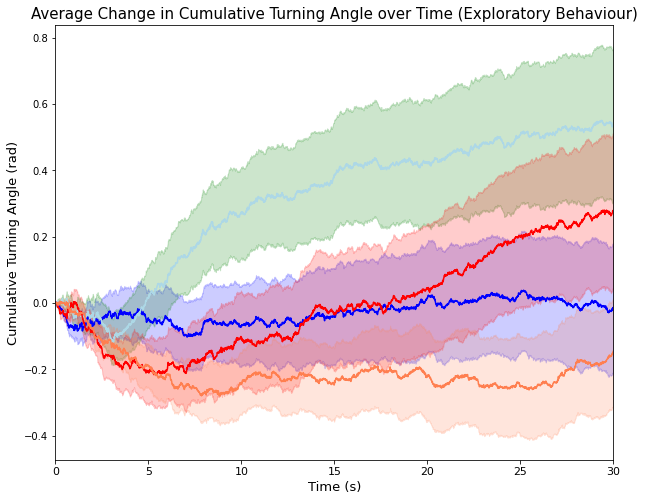

In [206]:
avg_pm_e_0_trajectory = np.mean(pm_comb_e_0[:,:,4],axis=0)
avg_pm_me_0_trajectory = np.mean(pm_comb_me_0[:,:,4],axis=0)

avg_pm_e_0_SEM = stats.sem(pm_comb_e_0[:,:,4],axis=0)
avg_pm_me_0_SEM = stats.sem(pm_comb_me_0[:,:,4],axis=0)
    
avg_am_e_0_trajectory = np.mean(am_comb_e_0[:,:,4],axis=0)
avg_am_me_0_trajectory = np.mean(am_comb_me_0[:,:,4],axis=0)

avg_am_e_0_SEM = stats.sem(am_comb_e_0[:,:,4],axis=0)
avg_am_me_0_SEM = stats.sem(am_comb_me_0[:,:,4],axis=0)

fig, ax = plt.subplots(1,1,figsize=(10,8))
plt.title("Average Change in Cumulative Turning Angle over Time (Exploratory Behaviour)",fontsize=15)
ax.set_xlabel("Time (s)",fontsize=13)
ax.set_ylabel("Cumulative Turning Angle (rad)",fontsize=13)
ax.set_xlim(0,3000)
x_ticks = [0, 500, 1000, 1500, 2000, 2500, 3000]
x_labels = [0, 5, 10, 15, 20, 25, 30] 
plt.xticks(x_ticks,x_labels,fontsize=11)
ax.plot(avg_pm_e_0_trajectory,c="b")
ax.plot(avg_pm_me_0_trajectory,c="lightblue")
ax.plot(avg_am_e_0_trajectory,c="r")
ax.plot(avg_am_me_0_trajectory,c="coral")
ax.fill_between(range(0,3000), avg_pm_e_0_trajectory-avg_pm_e_0_SEM, avg_pm_e_0_trajectory+avg_pm_e_0_SEM,color="b",alpha=0.2)
ax.fill_between(range(0,3000), avg_pm_me_0_trajectory-avg_pm_me_0_SEM, avg_pm_me_0_trajectory+avg_pm_me_0_SEM,\
                color="g",alpha=0.2)
ax.fill_between(range(0,3000), avg_am_e_0_trajectory-avg_am_e_0_SEM, avg_am_e_0_trajectory+avg_am_e_0_SEM,color="r",alpha=0.2)
ax.fill_between(range(0,3000), avg_am_me_0_trajectory-avg_am_me_0_SEM, avg_am_me_0_trajectory+avg_am_me_0_SEM,\
                color="coral",alpha=0.2)
plt.show()

## Mean & SEM of Cumulative Angles

In [207]:
am_e_0_cum = am_comb_e_0[:,-1,4]
am_me_0_cum = am_comb_me_0[:,-1,4]
pm_e_0_cum = pm_comb_e_0[:,-1,4]
pm_me_0_cum = pm_comb_me_0[:,-1,4]

<BarContainer object of 4 artists>

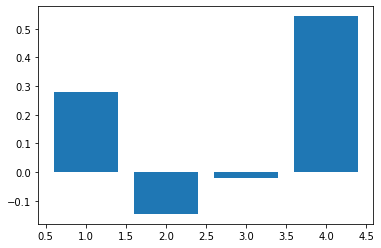

In [208]:
plt.bar([1,2,3,4],height=[np.mean(am_e_0_cum),np.mean(am_me_0_cum),np.mean(pm_e_0_cum),np.mean(pm_me_0_cum)])

In [209]:
am_e_0_sem = stats.sem(am_comb_e_0[:,-1,4])
am_me_0_sem = stats.sem(am_comb_me_0[:,-1,4])
pm_e_0_sem = stats.sem(pm_comb_e_0[:,-1,4])
pm_me_0_sem = stats.sem(pm_comb_me_0[:,-1,4])

## Cumulative Angle ANOVA

In [210]:
for m in ['e','me']:
    for t in ['pm','am']:
        exec(f"anova_df_{m}_{t}_0 = pd.DataFrame(columns=['medium','time','final_cum_angle'])")
        exec(f"anova_df_{m}_{t}_0['final_cum_angle'] = {t}_{m}_0_cum")
        exec(f"anova_df_{m}_{t}_0['medium'] = '{m}'")
        exec(f"anova_df_{m}_{t}_0['time'] = '{t}'")

In [211]:
anova_df_0 = pd.DataFrame(columns=['medium','time','final_cum_angle'])
anova_df_0 = pd.concat([anova_df_e_am_0,anova_df_e_pm_0,anova_df_me_am_0,anova_df_me_pm_0])
anova_df_0

,medium,time,final_cum_angle
0,e,am,-0.162022
1,e,am,5.928660
2,e,am,-2.876570
3,e,am,4.206860
4,e,am,-1.023789
...,...,...,...
584,me,pm,-0.071304
585,me,pm,0.015544
586,me,pm,-0.008779
587,me,pm,-0.013860


In [212]:
anova_df_0 = anova_df_0.reset_index()
anova_df_0 = anova_df_0.drop(columns='index')

In [213]:
anova_df_0_am = anova_df_0[anova_df_0['time']=='am']
anova_df_0_pm = anova_df_0[anova_df_0['time']=='pm']

In [214]:
cum_model_0 = ols(formula='final_cum_angle ~ C(medium, Sum) + C(time, Sum) + C(medium, Sum):C(time, Sum)'\
                       ,data=anova_df_0).fit()
anova_table_cum_0 = sm.stats.anova_lm(cum_model_0, typ=3)
anova_table_cum_0

,sum_sq,df,F,PR(>F)
Intercept,51.153221,1.0,2.277607,0.131414
"C(medium, Sum)",2.250099,1.0,0.100186,0.751640
"C(time, Sum)",18.091110,1.0,0.805510,0.369560
"C(medium, Sum):C(time, Sum)",115.418984,1.0,5.139054,0.023501
Residual,44356.901910,1975.0,NaN,NaN


In [215]:
am_cum_model_0 = ols(formula='final_cum_angle ~ C(medium, Sum)'\
                       ,data=anova_df_0_am).fit()
am_anova_table_cum_0 = sm.stats.anova_lm(am_cum_model_0, typ=3)
am_anova_table_cum_0

,sum_sq,df,F,PR(>F)
Intercept,3.488222,1.0,0.224812,0.635529
"C(medium, Sum)",35.467101,1.0,2.285818,0.130963
Residual,12195.697498,786.0,NaN,NaN


In [216]:
pm_cum_model_0 = ols(formula='final_cum_angle ~ C(medium, Sum)'\
                       ,data=anova_df_0_pm).fit()
pm_anova_table_cum_0 = sm.stats.anova_lm(pm_cum_model_0, typ=3)
pm_anova_table_cum_0

,sum_sq,df,F,PR(>F)
Intercept,81.760823,1.0,3.022698,0.082366
"C(medium, Sum)",94.214248,1.0,3.483102,0.062244
Residual,32161.204412,1189.0,NaN,NaN


## Event Table 

In [217]:
df_names_0 = ['am_e','am_me','pm_e','pm_me']
dataframes_0 = [am_comb_e_0, am_comb_me_0, pm_comb_e_0, pm_comb_me_0]

In [218]:
zero_event_table = pd.DataFrame(columns=['event_n','fish_n','event','duration_s','delta_theta_rad','distance',\
                                         'latency_s','time','medium'])

fish_counter = 1
for name,df in zip(df_names_0,dataframes_0):
    for fish in df:
        event_df = make_event_table(fish)
        event_df['time'] = name.split('_')[0]
        event_df['medium'] = name.split('_')[1]
        event_df['event_n'] = 0
        event_df['fish_n'] = fish_counter
        fish_counter += 1
        zero_event_table = pd.concat([zero_event_table,event_df])
        
zero_event_table['event_n'] = np.arange(1,len(zero_event_table)+1,1)
zero_event_table = zero_event_table.set_index('event_n')

zero_event_table

KeyboardInterrupt: 

In [ ]:
zero_event_table.to_csv('../saved_data/full_event_table_contrast_zero.csv')

In [219]:
### load zero_event_table ###
zero_event_table = pd.read_csv('../saved_data/full_event_table_contrast_zero.csv')
zero_event_table.set_index('event_n',inplace=True)

In [220]:
zero_event_table['delta_theta_rad'] = pd.to_numeric(zero_event_table['delta_theta_rad'])
zero_event_table['latency_s'] = pd.to_numeric(zero_event_table['latency_s'])
zero_event_table['distance'] = pd.to_numeric(zero_event_table['distance'])

In [221]:
am_events_0 = zero_event_table[zero_event_table['time']=='am']
pm_events_0 = zero_event_table[zero_event_table['time']=='pm']

In [222]:
pm_e_events_0 = pm_events_0[pm_events_0['medium'] == 'e']
pm_me_events_0 = pm_events_0[pm_events_0['medium'] == 'me']

am_e_events_0 = am_events_0[am_events_0['medium'] == 'e']
am_me_events_0 = am_events_0[am_events_0['medium'] == 'me']

## Delta theta ANOVA

In [223]:
bout_angle_model_0 = ols(formula='delta_theta_rad ~ C(medium, Sum) + C(time, Sum) + C(medium, Sum):C(time, Sum)'\
                       ,data=zero_event_table).fit()
anova_table_bout_0 = sm.stats.anova_lm(bout_angle_model_0, typ=3)
anova_table_bout_0

,sum_sq,df,F,PR(>F)
Intercept,3.436295,1.0,5.731027,0.016675
"C(medium, Sum)",0.288471,1.0,0.481110,0.487926
"C(time, Sum)",0.505051,1.0,0.842320,0.358743
"C(medium, Sum):C(time, Sum)",7.914733,1.0,13.200133,0.000280
Residual,15733.371919,26240.0,NaN,NaN


In [224]:
stats.f_oneway(pm_e_events_0['delta_theta_rad'],pm_me_events_0['delta_theta_rad'])

F_onewayResult(statistic=7.501597498701879, pvalue=0.0061702950961496535)

In [225]:
stats.f_oneway(am_e_events_0['delta_theta_rad'],am_me_events_0['delta_theta_rad'])

F_onewayResult(statistic=6.51437971588525, pvalue=0.01071987300924721)

In [226]:
am_bout_angle_model_0 = ols(formula='delta_theta_rad ~ C(medium, Sum)'\
                       ,data=am_events_0).fit()
am_anova_table_bout_0 = sm.stats.anova_lm(am_bout_angle_model_0, typ=3)
am_anova_table_bout_0

,sum_sq,df,F,PR(>F)
Intercept,0.459587,1.0,0.758249,0.383904
"C(medium, Sum)",3.948464,1.0,6.514380,0.010720
Residual,4624.658658,7630.0,NaN,NaN


In [227]:
pm_bout_angle_model_0 = ols(formula='delta_theta_rad ~ C(medium, Sum)'\
                       ,data=pm_events_0).fit()
pm_anova_table_bout_0 = sm.stats.anova_lm(pm_bout_angle_model_0, typ=3)
pm_anova_table_bout_0

,sum_sq,df,F,PR(>F)
Intercept,5.683458,1.0,9.521278,0.002034
"C(medium, Sum)",4.477867,1.0,7.501597,0.006170
Residual,11108.713261,18610.0,NaN,NaN


In [228]:
print('AM E2: ',np.mean(am_e_events_0['delta_theta_rad']))
print('AM Met: ',np.mean(am_me_events_0['delta_theta_rad']))

AM E2:  0.030620230103473256
AM Met:  -0.01504177182449303


{'whiskers': [<matplotlib.lines.Line2D at 0x13deec040>,
 'caps': [<matplotlib.lines.Line2D at 0x13def8850>,
 'boxes': [<matplotlib.lines.Line2D at 0x13def80d0>,
 'medians': [<matplotlib.lines.Line2D at 0x13def8df0>,
 'fliers': [<matplotlib.lines.Line2D at 0x13df08100>,
 'means': []}

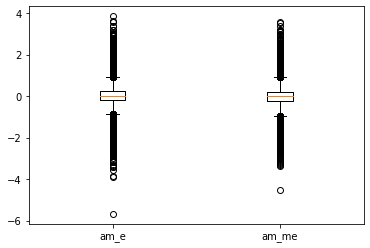

In [458]:
plt.boxplot([am_e_events_0['delta_theta_rad'],am_me_events_0['delta_theta_rad']],labels=['am_e','am_me'])
# plt.ylim(-1.5,2)

{'whiskers': [<matplotlib.lines.Line2D at 0x13de67f40>,
 'caps': [<matplotlib.lines.Line2D at 0x13de839a0>,
 'boxes': [<matplotlib.lines.Line2D at 0x13de83250>,
 'medians': [<matplotlib.lines.Line2D at 0x13de83f40>,
 'fliers': [<matplotlib.lines.Line2D at 0x13de8f250>,
 'means': []}

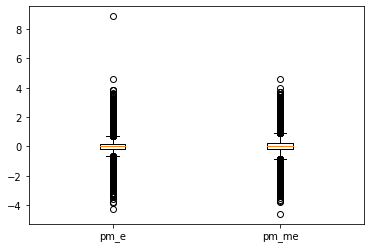

In [457]:
plt.boxplot([pm_e_events_0['delta_theta_rad'],pm_me_events_0['delta_theta_rad']],labels=['pm_e','pm_me'])
# plt.ylim(-1.5,2)

## Fish List

In [230]:
event_names_0 = ['am_e','am_me','pm_e','pm_me']
event_dataframes_0 = [am_e_events_0, am_me_events_0, pm_e_events_0, pm_me_events_0]

In [231]:
zero_fish_list = pd.DataFrame(columns=['fish_n','bouts_Hz','duration_avg','duration_sem','latency_avg',\
                                      'latency_sem','distance_avg','distance_sem','total_distance','time',\
                                       'medium'])

for name,df in zip(event_names_0,event_dataframes_0):
    fish_list = make_fish_list(df)
    fish_list['time'] = name.split('_')[0]
    fish_list['medium'] = name.split('_')[1]
#     fish_counter += 1
    zero_fish_list = pd.concat([zero_fish_list,fish_list])
        
zero_fish_list['fish_n'] = np.arange(1,len(zero_fish_list)+1,1)
zero_fish_list = zero_fish_list.set_index('fish_n')

zero_fish_list

/Users/katarzynakupczyk/.pyenv/versions/3.8.6/envs/dissertation2022/lib/python3.8/site-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/katarzynakupczyk/.pyenv/versions/3.8.6/envs/dissertation2022/lib/python3.8/site-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/katarzynakupczyk/.pyenv/versions/3.8.6/envs/dissertation2022/lib/python3.8/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/katarzynakupczyk/.pyenv/versions/3.8.6/envs/dissertation2022/lib/python3.8/site-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/katarzynakupczyk/.pyenv/versions/3.8.6/envs/dissert

,bouts_Hz,duration_avg,duration_sem,latency_avg,latency_sem,distance_avg,distance_sem,total_distance,time,medium
fish_n,,,,,,,,,,
1,0.766667,0.40913,0.008572,0.750909,0.065864,38.813441,1.73373,892.709137,am,e
2,0.5,0.475333,0.010773,1.42,0.359013,75.186549,6.207864,1127.798233,am,e
3,0.5,0.391333,0.024492,1.417857,0.43481,41.338405,4.441679,620.076073,am,e
4,0.333333,0.435,0.021871,1.228889,0.202062,59.296899,12.86991,592.968985,am,e
5,0.333333,0.36,0.023094,1.132222,0.205005,27.572011,2.798647,275.720112,am,e
...,...,...,...,...,...,...,...,...,...,...
1645,0.6,0.402222,0.019158,1.211765,0.111597,32.47917,2.226239,584.625056,pm,me
1646,0.566667,0.364118,0.020759,1.385625,0.140285,23.184686,1.943493,394.139667,pm,me
1647,0.1,0.253333,0.034801,2.755,1.295,14.82534,2.407136,44.476021,pm,me


In [232]:
zero_fish_list.to_csv('../saved_data/fish_list_contrast_zero.csv')

In [233]:
### load zero_fish_list ###
# zero_fish_list = pd.read_csv('../saved_data/fish_list_contrast_zero.csv')

In [234]:
zero_fish_list['bouts_Hz'] = pd.to_numeric(zero_fish_list['bouts_Hz'])
zero_fish_list['latency_avg'] = pd.to_numeric(zero_fish_list['latency_avg'])
zero_fish_list['distance_avg'] = pd.to_numeric(zero_fish_list['distance_avg'])
zero_fish_list['total_distance'] = pd.to_numeric(zero_fish_list['total_distance'])
zero_fish_list['duration_avg'] = pd.to_numeric(zero_fish_list['duration_avg'])

In [235]:
am_fish_list_0 = zero_fish_list[zero_fish_list['time']=='am']
pm_fish_list_0 = zero_fish_list[zero_fish_list['time']=='pm']

In [236]:
am_e_0_fish_list = am_fish_list_0[am_fish_list_0['medium']=='e']
am_me_0_fish_list = am_fish_list_0[am_fish_list_0['medium']=='me']

pm_e_0_fish_list = pm_fish_list_0[pm_fish_list_0['medium']=='e']
pm_me_0_fish_list = pm_fish_list_0[pm_fish_list_0['medium']=='me']

## Bout Frequency ANOVA

In [237]:
bouts_hz_model_0 = ols(formula='bouts_Hz ~ C(medium, Sum) + C(time, Sum) + C(medium, Sum):C(time, Sum)'\
                       ,data=zero_fish_list).fit()
anova_table_bouts_hz_0 = sm.stats.anova_lm(bouts_hz_model_0, typ=3)
anova_table_bouts_hz_0

,sum_sq,df,F,PR(>F)
Intercept,393.067015,1.0,5078.768641,0.000000e+00
"C(medium, Sum)",0.292138,1.0,3.774672,5.220452e-02
"C(time, Sum)",10.577241,1.0,136.667183,2.186988e-30
"C(medium, Sum):C(time, Sum)",0.490463,1.0,6.337204,1.191746e-02
Residual,127.313387,1645.0,NaN,NaN


In [238]:
pg.welch_anova(data=zero_fish_list,dv='bouts_Hz',between='medium')

,Source,ddof1,ddof2,F,p-unc,np2
0,medium,1,1646.992121,1.462455,0.226713,0.000887


In [239]:
am_bouts_hz_model_0 = ols(formula='bouts_Hz ~ C(medium,Sum)' ,data=am_fish_list_0).fit()
am_anova_table_bouts_hz_0 = sm.stats.anova_lm(am_bouts_hz_model_0, typ=3)
am_anova_table_bouts_hz_0

,sum_sq,df,F,PR(>F)
Intercept,107.842133,1.0,1789.328183,8.952236e-182
"C(medium, Sum)",0.604471,1.0,10.029441,1.619179e-03
Residual,35.980964,597.0,NaN,NaN


In [240]:
pm_bouts_hz_model_0 = ols(formula='bouts_Hz ~ C(medium,Sum)' ,data=pm_fish_list_0).fit()
pm_anova_table_bouts_hz_0 = sm.stats.anova_lm(pm_bouts_hz_model_0, typ=3)
pm_anova_table_bouts_hz_0

,sum_sq,df,F,PR(>F)
Intercept,366.581795,1.0,4206.367335,0.000000
"C(medium, Sum)",0.017583,1.0,0.201760,0.653397
Residual,91.332423,1048.0,NaN,NaN


In [241]:
pg.welch_anova(data=am_fish_list_0,dv='bouts_Hz',between='medium')

,Source,ddof1,ddof2,F,p-unc,np2
0,medium,1,596.885988,10.038184,0.001612,0.016522


In [242]:
pg.welch_anova(data=pm_fish_list_0,dv='bouts_Hz',between='medium')

,Source,ddof1,ddof2,F,p-unc,np2
0,medium,1,1045.869223,0.201842,0.653332,0.000192


## Event Duration, Distance, Latency ANOVA

In [243]:
am_duration_model_0 = ols(formula='duration_avg ~ C(medium, Sum)'\
                       ,data=am_fish_list_0).fit()
am_anova_table_duration_0 = sm.stats.anova_lm(am_duration_model_0, typ=3)
am_anova_table_duration_0

,sum_sq,df,F,PR(>F)
Intercept,97.736446,1.0,20358.083028,0.000000
"C(medium, Sum)",0.015689,1.0,3.267855,0.071153
Residual,2.866117,597.0,NaN,NaN


In [244]:
pm_duration_model_0 = ols(formula='duration_avg ~ C(medium, Sum)'\
                       ,data=pm_fish_list_0).fit()
pm_anova_table_duration_0 = sm.stats.anova_lm(pm_duration_model_0, typ=3)
pm_anova_table_duration_0

,sum_sq,df,F,PR(>F)
Intercept,159.227701,1.0,50595.829038,0.000000
"C(medium, Sum)",0.026976,1.0,8.571918,0.003488
Residual,3.298110,1048.0,NaN,NaN


In [245]:
am_latency_model_0 = ols(formula='latency_avg ~ C(medium, Sum)'\
                       ,data=am_fish_list_0).fit()
am_anova_table_latency_0 = sm.stats.anova_lm(am_latency_model_0, typ=3)
am_anova_table_latency_0

,sum_sq,df,F,PR(>F)
Intercept,2492.153848,1.0,485.260039,3.939094e-78
"C(medium, Sum)",1.390582,1.0,0.270767,6.030210e-01
Residual,2906.810707,566.0,NaN,NaN


In [246]:
pm_latency_model_0 = ols(formula='latency_avg ~ C(medium, Sum)'\
                       ,data=pm_fish_list_0).fit()
pm_anova_table_latency_0 = sm.stats.anova_lm(pm_latency_model_0, typ=3)
pm_anova_table_latency_0

,sum_sq,df,F,PR(>F)
Intercept,2757.433494,1.0,693.374564,4.127567e-117
"C(medium, Sum)",17.301708,1.0,4.350627,3.724240e-02
Residual,4072.274995,1024.0,NaN,NaN


In [247]:
distance_total_model_0 = ols(formula='total_distance ~ C(medium, Sum) + C(time, Sum) + C(medium, Sum):C(time, Sum)'\
                       ,data=zero_fish_list).fit()
anova_table_distance_total_0 = sm.stats.anova_lm(distance_total_model_0, typ=3)
anova_table_distance_total_0

,sum_sq,df,F,PR(>F)
Intercept,9.348906e+08,1.0,2394.802701,2.964394e-323
"C(medium, Sum)",5.128339e+05,1.0,1.313668,2.518983e-01
"C(time, Sum)",2.001869e+07,1.0,51.279607,1.203081e-12
"C(medium, Sum):C(time, Sum)",4.229587e+06,1.0,10.834452,1.017390e-03
Residual,6.421803e+08,1645.0,NaN,NaN
